In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
import random as rnd
import functools as func
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [5]:
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pylab as plt
import seaborn as sns
import plotly.io as pio
import itertools

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from neuralprophet import NeuralProphet, set_random_seed

In [6]:
T = 2000  #   Количество точек в ряду
T_test = 100   # Количество точек на тест
x = np.arange(0,T)  
N = 100    #  Количество периодов самой частой синусоиды


In [7]:
data_prefix = "M5/"
data_path = "sales_train_evaluation.csv"
data = pd.read_csv(data_path)

In [8]:
data

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  \
0         CA_1       CA    0    0    0    0  ...       2       4       0   
1         CA_1       CA    0    0    0    0  ...       0       1       2   
2         CA_1       CA    0    0    0    0  ...       1       0       2   
3         CA_1       CA    0    0    0    0  ...       1       1       0   
4         CA_1       CA    0    0    0    0  ...       0       0       0   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       1       0       3   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       0       0       1   
30488     WI_3       WI    0    0    0    0  ...       1       1       1   
30489     WI_3       WI    0    0    0    0  ...       1       2       0   

       d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
0           0       0       0       3       3       0       1  
1           1       1       0       0       0       0       0  
2           0       0       0       2       3       0       1  
3           4       0       1       3       0       2       6  
4           2       1       0       0       2       1       0  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       1       1       0       0       1       1  
30486       0       0       0       1       0       1       0  
30487       2       0       1       0       1       0       2  
30488       4       6       0       1       1       1       0  
30489       5       4       0       2       2       5       1  

[30490 rows x 1947 columns]

In [9]:
def downcast(df):

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df 

In [10]:
calendar = pd.read_csv("calendar.csv")

In [11]:
calendar = downcast(calendar)

In [12]:
# праздники
lst_events = calendar.event_name_1.dropna().unique().to_list()
events_df = pd.DataFrame(columns = ['event', 'ds'])
for strEvent in lst_events:
    events_df = events_df.append(pd.DataFrame({
        'event': strEvent,
        'ds': calendar.loc[(calendar[['event_name_1', 'event_name_2']] == strEvent).any(axis=1)].date.unique()
    }))
    
for strEvent in ['snap_CA','snap_TX','snap_WI']:
     events_df = events_df.append(pd.DataFrame({
        'event': strEvent,
        'ds': calendar.loc[(calendar[strEvent] > 0)].date.unique()
    }))

lst_events.extend(['snap_CA','snap_TX','snap_WI'])

events_df

event         ds
0    SuperBowl 2011-02-06
1    SuperBowl 2012-02-05
2    SuperBowl 2013-02-03
3    SuperBowl 2014-02-02
4    SuperBowl 2015-02-01
..         ...        ...
645    snap_WI 2016-06-09
646    snap_WI 2016-06-11
647    snap_WI 2016-06-12
648    snap_WI 2016-06-14
649    snap_WI 2016-06-15

[2117 rows x 2 columns]

In [13]:
data1 = data.iloc[:,6:]
arr = np.array(data1)
tt = torch.tensor(arr)
print(tt.shape)
tt2=torch.tensor(data1.values)
print(tt2.shape)

torch.Size([30490, 1941])
torch.Size([30490, 1941])


In [14]:
data1

d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  ...  d_1932  d_1933  \
0        0    0    0    0    0    0    0    0    0     0  ...       2       4   
1        0    0    0    0    0    0    0    0    0     0  ...       0       1   
2        0    0    0    0    0    0    0    0    0     0  ...       1       0   
3        0    0    0    0    0    0    0    0    0     0  ...       1       1   
4        0    0    0    0    0    0    0    0    0     0  ...       0       0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...     ...     ...   
30485    0    0    2    2    0    3    1    4    1     0  ...       1       0   
30486    0    0    0    0    0    5    0    1    1     3  ...       0       0   
30487    0    6    0    2    2    4    1    8    5     2  ...       0       0   
30488    0    0    0    0    0    0    0    0    0     0  ...       1       1   
30489    0    0    0    0    0    0    0    0    0     0  ...       1       2   

       d_1934  d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
0           0       0       0       0       3       3       0       1  
1           2       1       1       0       0       0       0       0  
2           2       0       0       0       2       3       0       1  
3           0       4       0       1       3       0       2       6  
4           0       2       1       0       0       2       1       0  
...       ...     ...     ...     ...     ...     ...     ...     ...  
30485       3       0       1       1       0       0       1       1  
30486       0       0       0       0       1       0       1       0  
30487       1       2       0       1       0       1       0       2  
30488       1       4       6       0       1       1       1       0  
30489       0       5       4       0       2       2       5       1  

[30490 rows x 1941 columns]

In [15]:
data22

NameError: name 'data22' is not defined

TypeError: unhashable type: 'numpy.ndarray'

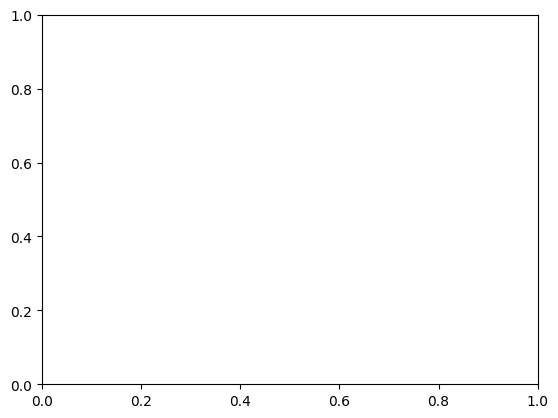

In [16]:
plt.plot(data)
plt.savefig('data1.png')
plt.legend()
plt.show()

In [ ]:
s = np.array([i for i in map(lambda d: sum(d)/1941.0, data1.values)])
m = np.array([i for i in map(lambda d: max(d), data1.values)])

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(s, label = "s")
plt.plot(m, label = "m")
plt.plot(m-s, label = "m-s")
plt.savefig('ms_m-s.png')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(s, label = "s")
plt.plot(m, label = "m")
plt.plot(m-s, label = "m-s")
plt.savefig('ms_m-s.png')
plt.legend()
plt.show()

In [17]:
s

NameError: name 's' is not defined

In [18]:
m

NameError: name 'm' is not defined

In [19]:
m1

NameError: name 'm1' is not defined

In [20]:
data22 = data1[s>10]
data22

NameError: name 's' is not defined

In [21]:

m1 = m[s>10]


NameError: name 'm' is not defined

In [22]:
ttsd = torch.tensor(m)     #  Тензор с величинами скачков
ttsp = torch.tensor(s)     #  Тензор с суммарным сдвигом
#ttsp = torch.zeros(all_shifts_prev.shape)
#tts = torch.tensor(all_shifts)
tt2=torch.tensor(m-s)                             #
#tt2 = torch.unsqueeze(torch.tensor(tt2), 1)
#tt2=tt2/(m2t)
#print(tt2.shape)
#print(m2t)
#tt2=tt2.transpose(0,1)
tt2 = torch.stack([tt2, tt2], 1)           #   Данные для предсказания (ряд повторяется два раза, чтобы обойти неизвестный баг)
tts2 = torch.stack([ttsp, ttsd], 1)        #   Общий тензор с внешними регрессорами (сдвигами и скачками)
print(tt2.shape)
print(tts2.shape)
tta = tt2.numpy()                                    #   Ряды данных для предсказания готовим для записи в файл, потому что так хочет лоадер (а вот регрессоры подадим отдельно)
tta[:,1] = tta[:,0]
np.savetxt("M5-lstnet22.txt", tta, delimiter=',')              #   Собственно запись в файл

NameError: name 'm' is not defined

In [131]:
tts2

tensor([[ 0.3261,  5.0000],
        [ 0.2576,  5.0000],
        [ 0.1592,  6.0000],
        ...,
        [ 0.8934, 20.0000],
        [ 0.3807, 12.0000],
        [ 0.7027, 12.0000]], dtype=torch.float64)

In [132]:
tt2=torch.tensor(data1.values)
m2t = torch.unsqueeze(torch.tensor(m1), 1)
#tt2=tt2/(m2t)
print(tt2.shape)
#print(m2t)
tt2=tt2.transpose(0,1)
print(tt2.shape)
tta = tt2.numpy()
np.savetxt("M5.txt", tta, delimiter=',')

torch.Size([30490, 1941])
torch.Size([1941, 30490])


In [133]:
# Чужой код (изменения только в обозначенных местах)

class Model(nn.Module):
    def __init__(self, args, data, regr_size=0):    #  Добавился последний параметр с количеством рядов-гегрессоров
        super(Model, self).__init__()
        self.use_cuda = args.cuda
        self.P = args.window;
        self.rs = regr_size
        self.m = data.m + regr_size    #  Вот здесь изменение в чужом коде - надо учесть ряды-регрессоры
        self.hidR = args.hidRNN;
        self.hidC = args.hidCNN;
        self.hidS = args.hidSkip;
        self.Ck = args.CNN_kernel;
        self.skip = args.skip;
        self.pt = int((self.P - self.Ck)/self.skip)
        self.hw = args.highway_window
        self.conv1 = nn.Conv2d(1, self.hidC, kernel_size = (self.Ck, self.m));
        self.GRU1 = nn.GRU(self.hidC, self.hidR);
        self.dropout = nn.Dropout(p = args.dropout);
        if (self.skip > 0):
            self.GRUskip = nn.GRU(self.hidC, self.hidS);
            self.linear1 = nn.Linear(self.hidR + self.skip * self.hidS, self.m - self.rs);
        else:
            self.linear1 = nn.Linear(self.hidR, self.m - self.rs);
        if (self.hw > 0):
            self.highway = nn.Linear(self.hw, 1);
            self.last = nn.Linear(self.m, self.m - self.rs)
        self.output = None;
        if (args.output_fun == 'sigmoid'):
            self.output = F.sigmoid;
        if (args.output_fun == 'tanh'):
            self.output = F.tanh;
 
    def forward(self, x):
        batch_size = x.size(0);
        
        #CNN
        c = x.view(-1, 1, self.P, self.m);
        c = F.relu(self.conv1(c));
        c = self.dropout(c);
        c = torch.squeeze(c, 3);
        
        # RNN 
        r = c.permute(2, 0, 1).contiguous();
        _, r = self.GRU1(r);
        r = self.dropout(torch.squeeze(r,0));

        
        #skip-rnn
        
        if (self.skip > 0):
            s = c[:,:, int(-self.pt * self.skip):].contiguous();
            s = s.view(batch_size, self.hidC, self.pt, self.skip);
            s = s.permute(2,0,3,1).contiguous();
            s = s.view(self.pt, batch_size * self.skip, self.hidC);
            _, s = self.GRUskip(s);
            s = s.view(batch_size, self.skip * self.hidS);
            s = self.dropout(s);
            r = torch.cat((r,s),1);
        
        res = self.linear1(r);
        
        #highway
        if (self.hw > 0):
            z = x[:, -self.hw:, :];
            z = z.permute(0,2,1).contiguous().view(-1, self.hw);
            z = self.highway(z);
            z = z.view(-1,self.m);
            z = self.last(z)
            res = res + z;
            
        if (self.output):
            res = self.output(res);
        return res;

In [134]:
# Чужой код с настройкой оптимизаторов - без изменений

import math
import torch.optim

class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = torch.optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = torch.optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = torch.optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = torch.optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm

    # decay learning rate if val perf does not improve or we hit the start_decay_at limit
    def updateLearningRate(self, ppl, epoch):
        if self.start_decay_at is not None and epoch >= self.start_decay_at:
            self.start_decay = True
        if self.last_ppl is not None and ppl > self.last_ppl:
            self.start_decay = True

        if self.start_decay:
            self.lr = self.lr * self.lr_decay
            print("Decaying learning rate to %g" % self.lr)
        #only decay for one epoch
        self.start_decay = False

        self.last_ppl = ppl

        self._makeOptimizer()

In [135]:
# Чужой код с загрузкой данных и формированием батчей для обучения. Здесь максимум изменений

import torch
import numpy as np;
from torch.autograd import Variable


def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.)/(len(x)))


#  Класс, который загружает данные и формирует батчи. В конструктор дополнительно подаем параметр regressors - тензор с рядами-регрессорами
class Data_utility(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, cuda, horizon, window, regressors, normalize = 2, def_scale = 1):
        self.cuda = cuda;
        self.P = window;
        self.h = horizon
        fin = open(file_name);
        self.rawdat = np.loadtxt(fin,delimiter=',');
        self.regr = regressors                                # Сохраняем сюда ряды-регрессоры
        self.dat = np.zeros(self.rawdat.shape);
        self.n, self.m = self.dat.shape;
        self.normalize = 2
        self.scale = np.ones(self.m)*def_scale;
        self._normalized(normalize);
        self._split(int(train * self.n), int((train+valid) * self.n), self.n);
        
        self.scale = torch.from_numpy(self.scale).float();
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.m);
            
        if self.cuda:
            self.scale = self.scale.cuda();
        self.scale = Variable(self.scale);
        
        self.rse = normal_std(tmp);
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)));
    
    def _normalized(self, normalize):
        #normalized by the maximum value of entire matrix.
       
        if (normalize == 0):
            self.dat = self.rawdat
            
        if (normalize == 1):
            self.dat = self.rawdat / np.max(self.rawdat);
            
        #normlized by the maximum value of each row(sensor).
        if (normalize == 2):
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:,i]));
                self.dat[:,i] = self.rawdat[:,i] / np.max(np.abs(self.rawdat[:,i]));
            
        
    def _split(self, train, valid, test):
        
        train_set = range(self.P+self.h-1, train);
        valid_set = range(train, valid);
        test_set = range(valid, self.n);
        self.train = self._batchify(train_set, self.h);
        self.valid = self._batchify(valid_set, self.h);
        self.test = self._batchify(test_set, self.h);
        
        
    def _batchify(self, idx_set, horizon):
        
        n = len(idx_set);
        X = torch.zeros((n,self.P,self.m));
        XR = torch.zeros((n,self.P,self.m));      #   В этом тензоре будут регрессоры
        Y = torch.zeros((n,self.m));
        
        for i in range(n):
            end = idx_set[i] - self.h + 1;
            start = end - self.P;
            X[i,:,:] = torch.from_numpy(self.dat[start:end, :]);
            if (self.regr != None):
                XR[i,:,:] = self.regr[start:end, :];              #  Нарезаем ряды-регрессоры на такие же батчи, как и ряды исходных данных для прогноза
                     
            Y[i,:] = torch.from_numpy(self.dat[idx_set[i], :]);
            #Y[i,:] = self.regr[idx_set[i], :];
            
        if (self.regr != None):
            X = torch.cat([X, XR], dim=2)           #  Приклеиваем регрессоры к батчам исходных данных

        return [X, Y];

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        length = len(inputs)
        #print("len = " + str(length))
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            #print("end_idx = " + str(end_idx))
            excerpt = index[start_idx:end_idx]
            #print("start_idx = " + str(start_idx))
            #print(excerpt)
            #print(inputs.shape)
            #print(targets.shape)
            X = inputs[excerpt]; Y = targets[excerpt];
            if (self.cuda):
                X = X.cuda();
                Y = Y.cuda();  
            yield Variable(X), Variable(Y);
            start_idx += batch_size

In [136]:
# Чужой код почти без изменений, только в конце устанавливаются параметры


import argparse
import math
import time
import sys

import torch
import torch.nn as nn

import numpy as np;
import importlib


def evaluate(data, X, Y, model, evaluateL2, evaluateL1, batch_size):
    model.eval();
    total_loss = 0;
    total_loss_l1 = 0;
    n_samples = 0;
    predict = None;
    test = None;
    
    for X, Y in data.get_batches(X, Y, batch_size, False):
        output = model(X);
        if predict is None:
            predict = output;
            test = Y;
        else:
            predict = torch.cat((predict,output));
            test = torch.cat((test, Y));
        
        scale = data.scale.expand(output.size(0), data.m)
        total_loss += evaluateL2(output * scale, Y * scale).item()
        total_loss_l1 += evaluateL1(output * scale, Y * scale).item()
        n_samples += (output.size(0) * data.m);
    rse = math.sqrt(total_loss / n_samples)/data.rse
    rae = (total_loss_l1/n_samples)/data.rae
    
    predict = predict.data.cpu().numpy();
    Ytest = test.data.cpu().numpy();
    sigma_p = (predict).std(axis = 0);
    sigma_g = (Ytest).std(axis = 0);
    mean_p = predict.mean(axis = 0)
    mean_g = Ytest.mean(axis = 0)
    index = (sigma_g!=0);
    correlation = ((predict - mean_p) * (Ytest - mean_g)).mean(axis = 0)/(sigma_p * sigma_g);
    correlation = (correlation[index]).mean();
    return rse, rae, correlation, predict, Ytest;

def train(data, X, Y, model, criterion, optim, batch_size):
    model.train();
    total_loss = 0;
    n_samples = 0;
    for X, Y in data.get_batches(X, Y, batch_size, True):
        model.zero_grad();
        output = model(X);
        scale = data.scale.expand(output.size(0), data.m)
        loss = criterion(output * scale, Y * scale);
        loss.backward();
        grad_norm = optim.step();
        total_loss += loss.item();
        n_samples += (output.size(0) * data.m);
    return total_loss / n_samples

sys.argv = "main --gpu 0 --horizon 24 --data data/electricity.txt --save save/elec.pt --output_fun Linear".split(" ")
    
parser = argparse.ArgumentParser(description='PyTorch Time series forecasting')
parser.add_argument('--data', type=str, required=True,
                    help='location of the data file')
parser.add_argument('--model', type=str, default='LSTNet',
                    help='')
parser.add_argument('--hidCNN', type=int, default=100,
                    help='number of CNN hidden units')
parser.add_argument('--hidRNN', type=int, default=100,
                    help='number of RNN hidden units')
parser.add_argument('--window', type=int, default=24 * 7,
                    help='window size')
parser.add_argument('--CNN_kernel', type=int, default=6,
                    help='the kernel size of the CNN layers')
parser.add_argument('--highway_window', type=int, default=24,
                    help='The window size of the highway component')
parser.add_argument('--clip', type=float, default=10.,
                    help='gradient clipping')
parser.add_argument('--epochs', type=int, default=100,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                    help='batch size')
parser.add_argument('--dropout', type=float, default=0.2,
                    help='dropout applied to layers (0 = no dropout)')
parser.add_argument('--seed', type=int, default=54321,
                    help='random seed')
parser.add_argument('--gpu', type=int, default=None)
parser.add_argument('--log_interval', type=int, default=2000, metavar='N',
                    help='report interval')
parser.add_argument('--save', type=str,  default='model/model.pt',
                    help='path to save the final model')
parser.add_argument('--cuda', type=str, default=True)
parser.add_argument('--optim', type=str, default='adam')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--horizon', type=int, default=12)
parser.add_argument('--skip', type=float, default=24)
parser.add_argument('--hidSkip', type=int, default=5)
parser.add_argument('--L1Loss', type=bool, default=True)
parser.add_argument('--normalize', type=int, default=2)
parser.add_argument('--output_fun', type=str, default='sigmoid')

args = parser.parse_args()

args.data = 'sin_regr_1.txt'     #  Файл исходных данных (они сохраняются сюда после генерации, регрессоров не содержат)
args.save = 'sin_regr_1.pt'      #  Сюда сохраняется модель

args.epochs = 5000               #  Количество эпох обучения


In [137]:
tts2.size()

torch.Size([30490, 2])

In [138]:
# Чужой код. Создавая экземпляр класса с данными подаем туда тензор с регрессорами tts2

args.cuda = args.gpu is not None
if args.cuda:
    torch.cuda.set_device(args.gpu)
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    else:
        torch.cuda.manual_seed(args.seed)

# Создаем экземпляр класса с данными подаем туда тензор с регрессорами tts2
Data = Data_utility(args.data, 0.6, 0.2, args.cuda, args.horizon, args.window,  tts2, args.normalize, def_scale=1)
print(Data.rse);

model = Model(args, Data, 2);

if args.cuda:
    model.cuda()
    
nParams = sum([p.nelement() for p in model.parameters()])
print('* number of parameters: %d' % nParams)


tensor(18.9057)
* number of parameters: 65182


In [139]:
 # Чужой код без изменений (определяем лоссы)

if args.L1Loss:
    criterion = nn.L1Loss(size_average=False);
else:
    criterion = nn.MSELoss(size_average=False);
evaluateL2 = nn.MSELoss(size_average=False);
evaluateL1 = nn.L1Loss(size_average=False)
if args.cuda:
    criterion = criterion.cuda()
    evaluateL1 = evaluateL1.cuda();
    evaluateL2 = evaluateL2.cuda();
    


In [140]:
# Чужой код без изменений (создание экземпляра оптимизатора)

best_val = 10000000;
optim = Optim(
    model.parameters(), args.optim, args.lr, args.clip,
)

In [141]:
args.epochs = 10000 

In [142]:
#  Чужой код без изменений (запускаем обучение)
    
'''--gpu 3 
   --data data/traffic.txt 
   --save save/traffic.pt 
   --hidSkip 10'''


# At any point you can hit Ctrl + C to break out of training early.
try:
    print('begin training');
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optim, args.batch_size)
        val_loss, val_rae, val_corr, _, _ = evaluate(Data, Data.valid[0], Data.valid[1], model, evaluateL2, evaluateL1, args.batch_size);
        print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr))
        # Save the model if the validation loss is the best we've seen so far.

        if val_loss < best_val:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val = val_loss
        if epoch % 5 == 0:
            test_acc, test_rae, test_corr, _, _  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
            print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')


begin training
| end of epoch   1 | time:  6.22s | train_loss 260.2988 | valid rse 1.0726 | valid rae 1.1405 | valid corr  0.0254
| end of epoch   2 | time:  3.45s | train_loss 11.8081 | valid rse 0.9606 | valid rae 0.8739 | valid corr  0.0985
| end of epoch   3 | time:  3.43s | train_loss 10.5097 | valid rse 1.0465 | valid rae 1.1836 | valid corr  0.1595
| end of epoch   4 | time:  3.43s | train_loss 9.6148 | valid rse 0.9337 | valid rae 0.7930 | valid corr  0.1634
| end of epoch   5 | time:  3.54s | train_loss 9.1645 | valid rse 0.8684 | valid rae 0.7160 | valid corr  0.1906
test rse 0.9946 | test rae 0.8240 | test corr 0.2331
| end of epoch   6 | time:  3.84s | train_loss 8.9298 | valid rse 0.9093 | valid rae 0.8702 | valid corr  0.1073
| end of epoch   7 | time:  3.86s | train_loss 9.0508 | valid rse 0.9331 | valid rae 0.7950 | valid corr  0.1941
| end of epoch   8 | time:  3.77s | train_loss 8.9340 | valid rse 0.9604 | valid rae 0.9106 | valid corr  0.2021
| end of epoch   9 | tim

| end of epoch  68 | time:  3.85s | train_loss 7.6163 | valid rse 0.8634 | valid rae 0.6849 | valid corr  0.2190
| end of epoch  69 | time:  3.78s | train_loss 7.6080 | valid rse 0.8713 | valid rae 0.6773 | valid corr  0.2054
| end of epoch  70 | time:  3.81s | train_loss 7.6129 | valid rse 0.8767 | valid rae 0.6742 | valid corr  0.2022
test rse 1.0067 | test rae 0.7804 | test corr 0.2427
| end of epoch  71 | time:  3.80s | train_loss 7.5941 | valid rse 0.8721 | valid rae 0.6767 | valid corr  0.2005
| end of epoch  72 | time:  3.92s | train_loss 7.6074 | valid rse 0.8943 | valid rae 0.6778 | valid corr  0.1978
| end of epoch  73 | time:  3.81s | train_loss 7.6000 | valid rse 0.8708 | valid rae 0.6803 | valid corr  0.2021
| end of epoch  74 | time:  3.84s | train_loss 7.6061 | valid rse 0.8809 | valid rae 0.6702 | valid corr  0.2098
| end of epoch  75 | time:  3.87s | train_loss 7.6053 | valid rse 0.8912 | valid rae 0.6729 | valid corr  0.2029
test rse 1.0206 | test rae 0.7823 | test co

| end of epoch 135 | time:  3.87s | train_loss 7.5574 | valid rse 0.8659 | valid rae 0.6862 | valid corr  0.2063
test rse 0.9930 | test rae 0.7937 | test corr 0.2396
| end of epoch 136 | time:  3.87s | train_loss 7.5355 | valid rse 0.8682 | valid rae 0.6963 | valid corr  0.1905
| end of epoch 137 | time:  3.87s | train_loss 7.5623 | valid rse 0.8712 | valid rae 0.6780 | valid corr  0.2123
| end of epoch 138 | time:  3.92s | train_loss 7.5733 | valid rse 0.8891 | valid rae 0.6777 | valid corr  0.2074
| end of epoch 139 | time:  3.90s | train_loss 7.5368 | valid rse 0.8674 | valid rae 0.6879 | valid corr  0.1999
| end of epoch 140 | time:  3.85s | train_loss 7.5611 | valid rse 0.8773 | valid rae 0.6702 | valid corr  0.2150
test rse 1.0076 | test rae 0.7786 | test corr 0.2542
| end of epoch 141 | time:  3.84s | train_loss 7.5619 | valid rse 0.8854 | valid rae 0.6829 | valid corr  0.2147
| end of epoch 142 | time:  3.99s | train_loss 7.5582 | valid rse 0.8829 | valid rae 0.6719 | valid cor

| end of epoch 201 | time:  3.92s | train_loss 7.5292 | valid rse 0.8667 | valid rae 0.6907 | valid corr  0.2046
| end of epoch 202 | time:  3.89s | train_loss 7.5133 | valid rse 0.8901 | valid rae 0.6817 | valid corr  0.2092
| end of epoch 203 | time:  3.88s | train_loss 7.5457 | valid rse 0.8888 | valid rae 0.6723 | valid corr  0.2017
| end of epoch 204 | time:  4.01s | train_loss 7.5227 | valid rse 0.8712 | valid rae 0.6740 | valid corr  0.2115
| end of epoch 205 | time:  3.94s | train_loss 7.5323 | valid rse 0.8718 | valid rae 0.6771 | valid corr  0.2136
test rse 1.0037 | test rae 0.7874 | test corr 0.2373
| end of epoch 206 | time:  3.88s | train_loss 7.5006 | valid rse 0.8780 | valid rae 0.6685 | valid corr  0.2097
| end of epoch 207 | time:  3.92s | train_loss 7.5474 | valid rse 0.8747 | valid rae 0.6734 | valid corr  0.2017
| end of epoch 208 | time:  3.94s | train_loss 7.5016 | valid rse 0.8642 | valid rae 0.6989 | valid corr  0.2018
| end of epoch 209 | time:  3.99s | train_l

| end of epoch 268 | time:  3.83s | train_loss 7.4898 | valid rse 0.8899 | valid rae 0.6822 | valid corr  0.2245
| end of epoch 269 | time:  3.91s | train_loss 7.4519 | valid rse 0.8753 | valid rae 0.6738 | valid corr  0.2085
| end of epoch 270 | time:  3.98s | train_loss 7.4890 | valid rse 0.8715 | valid rae 0.6692 | valid corr  0.2295
test rse 1.0011 | test rae 0.7792 | test corr 0.2525
| end of epoch 271 | time:  4.00s | train_loss 7.4784 | valid rse 0.8725 | valid rae 0.6715 | valid corr  0.2160
| end of epoch 272 | time:  3.97s | train_loss 7.4751 | valid rse 0.8878 | valid rae 0.6741 | valid corr  0.2088
| end of epoch 273 | time:  3.95s | train_loss 7.4676 | valid rse 0.8736 | valid rae 0.6775 | valid corr  0.2043
| end of epoch 274 | time:  3.92s | train_loss 7.4554 | valid rse 0.8809 | valid rae 0.6721 | valid corr  0.2090
| end of epoch 275 | time:  3.91s | train_loss 7.4745 | valid rse 0.8827 | valid rae 0.6705 | valid corr  0.2089
test rse 1.0128 | test rae 0.7808 | test co

| end of epoch 335 | time:  3.93s | train_loss 7.4208 | valid rse 0.8719 | valid rae 0.6718 | valid corr  0.2196
test rse 1.0031 | test rae 0.7817 | test corr 0.2459
| end of epoch 336 | time:  3.92s | train_loss 7.4641 | valid rse 0.8771 | valid rae 0.6730 | valid corr  0.2082
| end of epoch 337 | time:  3.94s | train_loss 7.4464 | valid rse 0.8753 | valid rae 0.6708 | valid corr  0.2054
| end of epoch 338 | time:  3.87s | train_loss 7.4268 | valid rse 0.8726 | valid rae 0.6720 | valid corr  0.2125
| end of epoch 339 | time:  3.94s | train_loss 7.4210 | valid rse 0.8653 | valid rae 0.6841 | valid corr  0.2104
| end of epoch 340 | time:  3.92s | train_loss 7.4421 | valid rse 0.8661 | valid rae 0.6929 | valid corr  0.2077
test rse 0.9948 | test rae 0.8048 | test corr 0.2279
| end of epoch 341 | time:  3.92s | train_loss 7.4602 | valid rse 0.8665 | valid rae 0.6812 | valid corr  0.2104
| end of epoch 342 | time:  3.91s | train_loss 7.4296 | valid rse 0.8692 | valid rae 0.6770 | valid cor

| end of epoch 401 | time:  3.95s | train_loss 7.4096 | valid rse 0.8857 | valid rae 0.6781 | valid corr  0.2003
| end of epoch 402 | time:  4.01s | train_loss 7.3970 | valid rse 0.8760 | valid rae 0.6726 | valid corr  0.2052
| end of epoch 403 | time:  3.96s | train_loss 7.4209 | valid rse 0.8716 | valid rae 0.6747 | valid corr  0.2082
| end of epoch 404 | time:  3.98s | train_loss 7.4067 | valid rse 0.8734 | valid rae 0.6703 | valid corr  0.2195
| end of epoch 405 | time:  3.98s | train_loss 7.4326 | valid rse 0.8734 | valid rae 0.6732 | valid corr  0.2114
test rse 1.0041 | test rae 0.7830 | test corr 0.2442
| end of epoch 406 | time:  3.98s | train_loss 7.4019 | valid rse 0.8733 | valid rae 0.6725 | valid corr  0.2113
| end of epoch 407 | time:  3.98s | train_loss 7.4208 | valid rse 0.8798 | valid rae 0.6702 | valid corr  0.2022
| end of epoch 408 | time:  4.03s | train_loss 7.4303 | valid rse 0.8754 | valid rae 0.6736 | valid corr  0.1996
| end of epoch 409 | time:  4.10s | train_l

| end of epoch 468 | time:  4.02s | train_loss 7.4107 | valid rse 0.8660 | valid rae 0.6851 | valid corr  0.2021
| end of epoch 469 | time:  3.99s | train_loss 7.4269 | valid rse 0.8824 | valid rae 0.6722 | valid corr  0.2033
| end of epoch 470 | time:  3.97s | train_loss 7.4120 | valid rse 0.8780 | valid rae 0.6704 | valid corr  0.2167
test rse 1.0133 | test rae 0.7827 | test corr 0.2352
| end of epoch 471 | time:  4.02s | train_loss 7.4202 | valid rse 0.8732 | valid rae 0.6744 | valid corr  0.2155
| end of epoch 472 | time:  3.98s | train_loss 7.4317 | valid rse 0.8884 | valid rae 0.6829 | valid corr  0.2220
| end of epoch 473 | time:  3.96s | train_loss 7.4182 | valid rse 0.8710 | valid rae 0.6738 | valid corr  0.2089
| end of epoch 474 | time:  3.93s | train_loss 7.4105 | valid rse 0.8779 | valid rae 0.6713 | valid corr  0.2262
| end of epoch 475 | time:  4.01s | train_loss 7.4333 | valid rse 0.8808 | valid rae 0.6747 | valid corr  0.1988
test rse 1.0088 | test rae 0.7849 | test co

| end of epoch 535 | time:  3.92s | train_loss 7.3908 | valid rse 0.8759 | valid rae 0.6709 | valid corr  0.2146
test rse 1.0039 | test rae 0.7788 | test corr 0.2513
| end of epoch 536 | time:  3.87s | train_loss 7.4141 | valid rse 0.8813 | valid rae 0.6760 | valid corr  0.2029
| end of epoch 537 | time:  3.89s | train_loss 7.4206 | valid rse 0.8718 | valid rae 0.6716 | valid corr  0.2222
| end of epoch 538 | time:  4.01s | train_loss 7.4125 | valid rse 0.8677 | valid rae 0.6767 | valid corr  0.2150
| end of epoch 539 | time:  3.93s | train_loss 7.3678 | valid rse 0.8664 | valid rae 0.6825 | valid corr  0.2122
| end of epoch 540 | time:  3.90s | train_loss 7.4108 | valid rse 0.8882 | valid rae 0.6789 | valid corr  0.2131
test rse 1.0225 | test rae 0.7943 | test corr 0.2330
| end of epoch 541 | time:  3.93s | train_loss 7.3937 | valid rse 0.8746 | valid rae 0.6736 | valid corr  0.2138
| end of epoch 542 | time:  3.93s | train_loss 7.4010 | valid rse 0.8695 | valid rae 0.6718 | valid cor

| end of epoch 601 | time:  3.97s | train_loss 7.4178 | valid rse 0.8917 | valid rae 0.6832 | valid corr  0.2125
| end of epoch 602 | time:  3.94s | train_loss 7.4141 | valid rse 0.8997 | valid rae 0.7055 | valid corr  0.2111
| end of epoch 603 | time:  3.95s | train_loss 7.4153 | valid rse 0.8764 | valid rae 0.6732 | valid corr  0.2101
| end of epoch 604 | time:  3.97s | train_loss 7.4080 | valid rse 0.8670 | valid rae 0.6772 | valid corr  0.2213
| end of epoch 605 | time:  3.94s | train_loss 7.3885 | valid rse 0.8747 | valid rae 0.6722 | valid corr  0.2163
test rse 1.0075 | test rae 0.7807 | test corr 0.2401
| end of epoch 606 | time:  3.89s | train_loss 7.3889 | valid rse 0.8675 | valid rae 0.6767 | valid corr  0.2201
| end of epoch 607 | time:  3.95s | train_loss 7.4161 | valid rse 0.8675 | valid rae 0.6773 | valid corr  0.2164
| end of epoch 608 | time:  3.92s | train_loss 7.4195 | valid rse 0.8651 | valid rae 0.6876 | valid corr  0.2081
| end of epoch 609 | time:  3.89s | train_l

| end of epoch 668 | time:  3.95s | train_loss 7.3650 | valid rse 0.8705 | valid rae 0.6788 | valid corr  0.2090
| end of epoch 669 | time:  3.92s | train_loss 7.3589 | valid rse 0.8839 | valid rae 0.6717 | valid corr  0.2123
| end of epoch 670 | time:  3.97s | train_loss 7.3755 | valid rse 0.8708 | valid rae 0.6750 | valid corr  0.2104
test rse 1.0025 | test rae 0.7806 | test corr 0.2443
| end of epoch 671 | time:  3.93s | train_loss 7.3630 | valid rse 0.8848 | valid rae 0.6730 | valid corr  0.2084
| end of epoch 672 | time:  3.96s | train_loss 7.3567 | valid rse 0.8600 | valid rae 0.6987 | valid corr  0.2156
| end of epoch 673 | time:  3.93s | train_loss 7.3865 | valid rse 0.8724 | valid rae 0.6710 | valid corr  0.2158
| end of epoch 674 | time:  3.96s | train_loss 7.3841 | valid rse 0.8820 | valid rae 0.6713 | valid corr  0.2058
| end of epoch 675 | time:  3.96s | train_loss 7.3776 | valid rse 0.8749 | valid rae 0.6711 | valid corr  0.2099
test rse 1.0063 | test rae 0.7812 | test co

| end of epoch 735 | time:  3.77s | train_loss 7.3687 | valid rse 0.8923 | valid rae 0.6856 | valid corr  0.2103
test rse 1.0242 | test rae 0.8016 | test corr 0.2457
| end of epoch 736 | time:  3.73s | train_loss 7.3892 | valid rse 0.8776 | valid rae 0.6700 | valid corr  0.2077
| end of epoch 737 | time:  3.76s | train_loss 7.3560 | valid rse 0.8696 | valid rae 0.6809 | valid corr  0.2078
| end of epoch 738 | time:  3.74s | train_loss 7.3623 | valid rse 0.8880 | valid rae 0.6785 | valid corr  0.1949
| end of epoch 739 | time:  3.74s | train_loss 7.3903 | valid rse 0.8710 | valid rae 0.6715 | valid corr  0.2234
| end of epoch 740 | time:  3.75s | train_loss 7.3681 | valid rse 0.8779 | valid rae 0.6691 | valid corr  0.2165
test rse 1.0083 | test rae 0.7794 | test corr 0.2510
| end of epoch 741 | time:  3.74s | train_loss 7.3575 | valid rse 0.8628 | valid rae 0.6775 | valid corr  0.2284
| end of epoch 742 | time:  3.71s | train_loss 7.3533 | valid rse 0.8898 | valid rae 0.6902 | valid cor

| end of epoch 801 | time:  3.75s | train_loss 7.3531 | valid rse 0.8931 | valid rae 0.6810 | valid corr  0.2025
| end of epoch 802 | time:  3.73s | train_loss 7.3725 | valid rse 0.8614 | valid rae 0.7070 | valid corr  0.2085
| end of epoch 803 | time:  3.75s | train_loss 7.3684 | valid rse 0.8872 | valid rae 0.6791 | valid corr  0.2209
| end of epoch 804 | time:  3.76s | train_loss 7.3735 | valid rse 0.8674 | valid rae 0.6771 | valid corr  0.2187
| end of epoch 805 | time:  3.73s | train_loss 7.3333 | valid rse 0.8734 | valid rae 0.6720 | valid corr  0.2121
test rse 1.0008 | test rae 0.7796 | test corr 0.2569
| end of epoch 806 | time:  3.75s | train_loss 7.3717 | valid rse 0.8744 | valid rae 0.6825 | valid corr  0.1915
| end of epoch 807 | time:  3.74s | train_loss 7.3794 | valid rse 0.8731 | valid rae 0.6729 | valid corr  0.2170
| end of epoch 808 | time:  3.75s | train_loss 7.3432 | valid rse 0.8626 | valid rae 0.6929 | valid corr  0.2122
| end of epoch 809 | time:  3.73s | train_l

| end of epoch 868 | time:  3.74s | train_loss 7.3918 | valid rse 0.8736 | valid rae 0.6725 | valid corr  0.2170
| end of epoch 869 | time:  3.72s | train_loss 7.3573 | valid rse 0.8712 | valid rae 0.6717 | valid corr  0.2239
| end of epoch 870 | time:  3.72s | train_loss 7.3592 | valid rse 0.8760 | valid rae 0.6718 | valid corr  0.2199
test rse 1.0186 | test rae 0.7846 | test corr 0.2296
| end of epoch 871 | time:  3.72s | train_loss 7.3303 | valid rse 0.8774 | valid rae 0.6714 | valid corr  0.2175
| end of epoch 872 | time:  3.71s | train_loss 7.3559 | valid rse 0.8782 | valid rae 0.6739 | valid corr  0.2130
| end of epoch 873 | time:  3.72s | train_loss 7.3546 | valid rse 0.8619 | valid rae 0.6879 | valid corr  0.2193
| end of epoch 874 | time:  3.72s | train_loss 7.3285 | valid rse 0.8862 | valid rae 0.6697 | valid corr  0.2155
| end of epoch 875 | time:  3.74s | train_loss 7.3492 | valid rse 0.8791 | valid rae 0.6734 | valid corr  0.2062
test rse 1.0121 | test rae 0.7829 | test co

| end of epoch 935 | time:  3.75s | train_loss 7.3396 | valid rse 0.8833 | valid rae 0.6757 | valid corr  0.2090
test rse 1.0173 | test rae 0.7857 | test corr 0.2338
| end of epoch 936 | time:  3.74s | train_loss 7.3259 | valid rse 0.8802 | valid rae 0.6684 | valid corr  0.2172
| end of epoch 937 | time:  3.75s | train_loss 7.3473 | valid rse 0.8835 | valid rae 0.6758 | valid corr  0.2065
| end of epoch 938 | time:  3.71s | train_loss 7.3498 | valid rse 0.8777 | valid rae 0.6706 | valid corr  0.2253
| end of epoch 939 | time:  3.72s | train_loss 7.3517 | valid rse 0.8629 | valid rae 0.7023 | valid corr  0.2145
| end of epoch 940 | time:  3.75s | train_loss 7.3641 | valid rse 0.8749 | valid rae 0.6836 | valid corr  0.1836
test rse 1.0110 | test rae 0.7930 | test corr 0.2031
| end of epoch 941 | time:  3.74s | train_loss 7.3550 | valid rse 0.8646 | valid rae 0.6830 | valid corr  0.2155
| end of epoch 942 | time:  3.72s | train_loss 7.3461 | valid rse 0.8750 | valid rae 0.6733 | valid cor

| end of epoch 1001 | time:  3.74s | train_loss 7.3234 | valid rse 0.8782 | valid rae 0.6720 | valid corr  0.2073
| end of epoch 1002 | time:  3.73s | train_loss 7.3138 | valid rse 0.8730 | valid rae 0.6705 | valid corr  0.2144
| end of epoch 1003 | time:  3.75s | train_loss 7.3604 | valid rse 0.8763 | valid rae 0.6735 | valid corr  0.2129
| end of epoch 1004 | time:  3.71s | train_loss 7.3204 | valid rse 0.8776 | valid rae 0.6717 | valid corr  0.2180
| end of epoch 1005 | time:  3.72s | train_loss 7.3265 | valid rse 0.8725 | valid rae 0.6720 | valid corr  0.2144
test rse 1.0063 | test rae 0.7811 | test corr 0.2459
| end of epoch 1006 | time:  3.73s | train_loss 7.3629 | valid rse 0.8837 | valid rae 0.6729 | valid corr  0.2076
| end of epoch 1007 | time:  3.71s | train_loss 7.3605 | valid rse 0.8649 | valid rae 0.6851 | valid corr  0.2123
| end of epoch 1008 | time:  3.72s | train_loss 7.3633 | valid rse 0.8756 | valid rae 0.6740 | valid corr  0.2068
| end of epoch 1009 | time:  3.75s 

| end of epoch 1067 | time:  3.79s | train_loss 7.3902 | valid rse 0.8688 | valid rae 0.6785 | valid corr  0.2147
| end of epoch 1068 | time:  3.78s | train_loss 7.3457 | valid rse 0.8819 | valid rae 0.6705 | valid corr  0.2231
| end of epoch 1069 | time:  3.72s | train_loss 7.3729 | valid rse 0.8655 | valid rae 0.6872 | valid corr  0.2157
| end of epoch 1070 | time:  3.74s | train_loss 7.3341 | valid rse 0.8739 | valid rae 0.6722 | valid corr  0.2120
test rse 1.0085 | test rae 0.7793 | test corr 0.2427
| end of epoch 1071 | time:  3.72s | train_loss 7.3707 | valid rse 0.8702 | valid rae 0.6721 | valid corr  0.2232
| end of epoch 1072 | time:  3.72s | train_loss 7.4223 | valid rse 0.8685 | valid rae 0.6783 | valid corr  0.2185
| end of epoch 1073 | time:  3.74s | train_loss 7.3400 | valid rse 0.8782 | valid rae 0.6708 | valid corr  0.2167
| end of epoch 1074 | time:  3.73s | train_loss 7.4620 | valid rse 0.8884 | valid rae 0.6827 | valid corr  0.2143
| end of epoch 1075 | time:  3.75s 

| end of epoch 1133 | time:  3.71s | train_loss 7.3301 | valid rse 0.8643 | valid rae 0.6839 | valid corr  0.2200
| end of epoch 1134 | time:  3.75s | train_loss 7.3462 | valid rse 0.8917 | valid rae 0.6862 | valid corr  0.1996
| end of epoch 1135 | time:  3.73s | train_loss 7.3360 | valid rse 0.8701 | valid rae 0.6718 | valid corr  0.2242
test rse 1.0029 | test rae 0.7798 | test corr 0.2544
| end of epoch 1136 | time:  3.74s | train_loss 7.3337 | valid rse 0.8766 | valid rae 0.6772 | valid corr  0.2089
| end of epoch 1137 | time:  3.70s | train_loss 7.3343 | valid rse 0.8796 | valid rae 0.6789 | valid corr  0.2114
| end of epoch 1138 | time:  3.74s | train_loss 7.3261 | valid rse 0.8836 | valid rae 0.6724 | valid corr  0.2149
| end of epoch 1139 | time:  3.72s | train_loss 7.3267 | valid rse 0.8807 | valid rae 0.6716 | valid corr  0.2151
| end of epoch 1140 | time:  3.76s | train_loss 7.3441 | valid rse 0.8685 | valid rae 0.6771 | valid corr  0.2137
test rse 0.9988 | test rae 0.7827 |

| end of epoch 1199 | time:  3.73s | train_loss 7.7743 | valid rse 0.8757 | valid rae 0.6786 | valid corr  0.2163
| end of epoch 1200 | time:  3.75s | train_loss 7.7261 | valid rse 0.9020 | valid rae 0.6884 | valid corr  0.2086
test rse 1.0363 | test rae 0.8016 | test corr 0.2239
| end of epoch 1201 | time:  3.73s | train_loss 7.7382 | valid rse 0.8862 | valid rae 0.6743 | valid corr  0.1892
| end of epoch 1202 | time:  3.70s | train_loss 7.7118 | valid rse 0.8773 | valid rae 0.6822 | valid corr  0.2091
| end of epoch 1203 | time:  3.71s | train_loss 7.6980 | valid rse 0.8741 | valid rae 0.6772 | valid corr  0.2105
| end of epoch 1204 | time:  3.73s | train_loss 7.6865 | valid rse 0.8909 | valid rae 0.6831 | valid corr  0.2060
| end of epoch 1205 | time:  3.71s | train_loss 7.6555 | valid rse 0.8879 | valid rae 0.6738 | valid corr  0.2052
test rse 1.0190 | test rae 0.7844 | test corr 0.2440
| end of epoch 1206 | time:  3.75s | train_loss 7.6805 | valid rse 0.8704 | valid rae 0.6750 | v

| end of epoch 1265 | time:  3.70s | train_loss 7.3549 | valid rse 0.8805 | valid rae 0.6758 | valid corr  0.2228
test rse 1.0131 | test rae 0.7912 | test corr 0.2483
| end of epoch 1266 | time:  3.74s | train_loss 7.4076 | valid rse 0.8621 | valid rae 0.6865 | valid corr  0.2283
| end of epoch 1267 | time:  3.74s | train_loss 7.3612 | valid rse 0.8734 | valid rae 0.6741 | valid corr  0.2172
| end of epoch 1268 | time:  3.74s | train_loss 7.3890 | valid rse 0.8837 | valid rae 0.6689 | valid corr  0.2207
| end of epoch 1269 | time:  3.71s | train_loss 7.3433 | valid rse 0.8734 | valid rae 0.6790 | valid corr  0.1998
| end of epoch 1270 | time:  3.74s | train_loss 7.3796 | valid rse 0.8864 | valid rae 0.6738 | valid corr  0.2212
test rse 1.0227 | test rae 0.7926 | test corr 0.2445
| end of epoch 1271 | time:  3.75s | train_loss 7.3601 | valid rse 0.8727 | valid rae 0.6717 | valid corr  0.2156
| end of epoch 1272 | time:  3.72s | train_loss 7.3277 | valid rse 0.8663 | valid rae 0.6854 | v

test rse 1.0071 | test rae 0.7834 | test corr 0.2345
| end of epoch 1331 | time:  3.76s | train_loss 7.3363 | valid rse 0.8697 | valid rae 0.6800 | valid corr  0.2064
| end of epoch 1332 | time:  3.75s | train_loss 7.3486 | valid rse 0.8929 | valid rae 0.6848 | valid corr  0.2140
| end of epoch 1333 | time:  3.72s | train_loss 7.3373 | valid rse 0.8600 | valid rae 0.7009 | valid corr  0.2188
| end of epoch 1334 | time:  3.72s | train_loss 7.3236 | valid rse 0.8641 | valid rae 0.6937 | valid corr  0.2158
| end of epoch 1335 | time:  3.73s | train_loss 7.3669 | valid rse 0.8665 | valid rae 0.6788 | valid corr  0.2230
test rse 1.0025 | test rae 0.7863 | test corr 0.2380
| end of epoch 1336 | time:  3.78s | train_loss 7.3407 | valid rse 0.8849 | valid rae 0.6735 | valid corr  0.2208
| end of epoch 1337 | time:  3.83s | train_loss 7.3737 | valid rse 0.8763 | valid rae 0.6681 | valid corr  0.2213
| end of epoch 1338 | time:  3.73s | train_loss 7.3660 | valid rse 0.8726 | valid rae 0.6750 | v

| end of epoch 1397 | time:  3.72s | train_loss 7.3759 | valid rse 0.8832 | valid rae 0.6699 | valid corr  0.2124
| end of epoch 1398 | time:  3.74s | train_loss 7.3736 | valid rse 0.8727 | valid rae 0.6699 | valid corr  0.2187
| end of epoch 1399 | time:  3.73s | train_loss 7.3635 | valid rse 0.8709 | valid rae 0.6732 | valid corr  0.2164
| end of epoch 1400 | time:  3.76s | train_loss 7.3383 | valid rse 0.8751 | valid rae 0.6667 | valid corr  0.2208
test rse 1.0087 | test rae 0.7787 | test corr 0.2440
| end of epoch 1401 | time:  3.74s | train_loss 7.3418 | valid rse 0.8785 | valid rae 0.6675 | valid corr  0.2179
| end of epoch 1402 | time:  3.74s | train_loss 7.3592 | valid rse 0.8881 | valid rae 0.6783 | valid corr  0.2178
| end of epoch 1403 | time:  3.75s | train_loss 7.4182 | valid rse 0.8754 | valid rae 0.6678 | valid corr  0.2186
| end of epoch 1404 | time:  3.76s | train_loss 7.3194 | valid rse 0.8704 | valid rae 0.6811 | valid corr  0.1992
| end of epoch 1405 | time:  3.72s 

| end of epoch 1463 | time:  3.72s | train_loss 7.6244 | valid rse 0.8801 | valid rae 0.6748 | valid corr  0.1910
| end of epoch 1464 | time:  3.74s | train_loss 7.5640 | valid rse 0.8694 | valid rae 0.6771 | valid corr  0.2182
| end of epoch 1465 | time:  3.73s | train_loss 7.6458 | valid rse 0.8717 | valid rae 0.6920 | valid corr  0.1963
test rse 1.0023 | test rae 0.8053 | test corr 0.2385
| end of epoch 1466 | time:  3.71s | train_loss 7.6419 | valid rse 0.8668 | valid rae 0.6939 | valid corr  0.2069
| end of epoch 1467 | time:  3.74s | train_loss 7.7046 | valid rse 0.9078 | valid rae 0.7288 | valid corr  0.0872
| end of epoch 1468 | time:  3.72s | train_loss 7.7223 | valid rse 0.8829 | valid rae 0.6714 | valid corr  0.2208
| end of epoch 1469 | time:  3.74s | train_loss 7.7089 | valid rse 0.8677 | valid rae 0.6817 | valid corr  0.2193
| end of epoch 1470 | time:  3.71s | train_loss 7.6460 | valid rse 0.8642 | valid rae 0.6928 | valid corr  0.2130
test rse 0.9964 | test rae 0.7996 |

| end of epoch 1529 | time:  3.70s | train_loss 7.3547 | valid rse 0.8881 | valid rae 0.6733 | valid corr  0.2006
| end of epoch 1530 | time:  3.72s | train_loss 7.3995 | valid rse 0.8745 | valid rae 0.6711 | valid corr  0.2087
test rse 1.0090 | test rae 0.7792 | test corr 0.2348
| end of epoch 1531 | time:  3.71s | train_loss 7.3535 | valid rse 0.8745 | valid rae 0.6693 | valid corr  0.2162
| end of epoch 1532 | time:  3.72s | train_loss 7.3609 | valid rse 0.8775 | valid rae 0.6675 | valid corr  0.2181
| end of epoch 1533 | time:  3.74s | train_loss 7.3428 | valid rse 0.8941 | valid rae 0.6863 | valid corr  0.2201
| end of epoch 1534 | time:  3.71s | train_loss 7.3487 | valid rse 0.8724 | valid rae 0.6798 | valid corr  0.2040
| end of epoch 1535 | time:  3.72s | train_loss 7.3708 | valid rse 0.8723 | valid rae 0.6758 | valid corr  0.2100
test rse 1.0069 | test rae 0.7841 | test corr 0.2297
| end of epoch 1536 | time:  3.72s | train_loss 7.3515 | valid rse 0.8897 | valid rae 0.6781 | v

| end of epoch 1595 | time:  3.72s | train_loss 7.9610 | valid rse 0.8813 | valid rae 0.6863 | valid corr  0.1753
test rse 1.0071 | test rae 0.7969 | test corr 0.2198
| end of epoch 1596 | time:  3.68s | train_loss 7.9821 | valid rse 0.8839 | valid rae 0.6930 | valid corr  0.1934
| end of epoch 1597 | time:  3.67s | train_loss 7.8661 | valid rse 0.8788 | valid rae 0.6912 | valid corr  0.1720
| end of epoch 1598 | time:  3.73s | train_loss 7.9130 | valid rse 0.8961 | valid rae 0.6874 | valid corr  0.1898
| end of epoch 1599 | time:  3.70s | train_loss 7.9619 | valid rse 0.8845 | valid rae 0.6975 | valid corr  0.1465
| end of epoch 1600 | time:  3.69s | train_loss 7.8976 | valid rse 0.8570 | valid rae 0.7340 | valid corr  0.2069
test rse 0.9780 | test rae 0.8566 | test corr 0.2313
| end of epoch 1601 | time:  3.75s | train_loss 7.9016 | valid rse 0.8769 | valid rae 0.6968 | valid corr  0.1773
| end of epoch 1602 | time:  3.76s | train_loss 7.9121 | valid rse 0.8681 | valid rae 0.7088 | v

test rse 1.0124 | test rae 0.7826 | test corr 0.2420
| end of epoch 1661 | time:  3.70s | train_loss 7.3905 | valid rse 0.8831 | valid rae 0.6703 | valid corr  0.2006
| end of epoch 1662 | time:  3.72s | train_loss 7.4043 | valid rse 0.8738 | valid rae 0.6740 | valid corr  0.2020
| end of epoch 1663 | time:  3.71s | train_loss 7.3995 | valid rse 0.8760 | valid rae 0.6733 | valid corr  0.1988
| end of epoch 1664 | time:  3.71s | train_loss 7.3809 | valid rse 0.8869 | valid rae 0.6785 | valid corr  0.2147
| end of epoch 1665 | time:  3.69s | train_loss 7.4003 | valid rse 0.8717 | valid rae 0.6795 | valid corr  0.1991
test rse 1.0028 | test rae 0.7891 | test corr 0.2377
| end of epoch 1666 | time:  3.71s | train_loss 7.3924 | valid rse 0.8933 | valid rae 0.6788 | valid corr  0.1974
| end of epoch 1667 | time:  3.69s | train_loss 7.4137 | valid rse 0.8882 | valid rae 0.6715 | valid corr  0.2031
| end of epoch 1668 | time:  3.71s | train_loss 7.4018 | valid rse 0.9014 | valid rae 0.6911 | v

| end of epoch 1727 | time:  3.72s | train_loss 9.9921 | valid rse 0.8761 | valid rae 0.7872 | valid corr  0.0481
| end of epoch 1728 | time:  3.71s | train_loss 9.5891 | valid rse 0.8928 | valid rae 0.7443 | valid corr  -0.0108
| end of epoch 1729 | time:  3.71s | train_loss 9.2892 | valid rse 0.8938 | valid rae 0.7348 | valid corr  0.0111
| end of epoch 1730 | time:  3.71s | train_loss 9.6178 | valid rse 0.9065 | valid rae 0.9875 | valid corr  0.0467
test rse 1.0129 | test rae 1.1064 | test corr 0.1006
| end of epoch 1731 | time:  3.71s | train_loss 10.6778 | valid rse 0.8744 | valid rae 0.7700 | valid corr  0.0845
| end of epoch 1732 | time:  3.75s | train_loss 48.8021 | valid rse 1.4887 | valid rae 2.1361 | valid corr  0.1169
| end of epoch 1733 | time:  3.72s | train_loss 21.9114 | valid rse 1.1564 | valid rae 1.5138 | valid corr  0.1028
| end of epoch 1734 | time:  3.72s | train_loss 13.5653 | valid rse 0.9274 | valid rae 0.9300 | valid corr  0.0260
| end of epoch 1735 | time:  3

| end of epoch 1793 | time:  3.72s | train_loss 9.0371 | valid rse 0.8712 | valid rae 0.7405 | valid corr  0.1478
| end of epoch 1794 | time:  3.74s | train_loss 8.9805 | valid rse 0.8829 | valid rae 0.7215 | valid corr  0.1232
| end of epoch 1795 | time:  3.69s | train_loss 8.3298 | valid rse 0.8806 | valid rae 0.7051 | valid corr  0.1543
test rse 1.0075 | test rae 0.8235 | test corr 0.1858
| end of epoch 1796 | time:  3.71s | train_loss 8.1404 | valid rse 0.8820 | valid rae 0.7104 | valid corr  0.1327
| end of epoch 1797 | time:  3.78s | train_loss 8.0278 | valid rse 0.8889 | valid rae 0.7009 | valid corr  0.1434
| end of epoch 1798 | time:  3.71s | train_loss 8.4674 | valid rse 0.8795 | valid rae 0.9953 | valid corr  0.1678
| end of epoch 1799 | time:  3.71s | train_loss 9.1111 | valid rse 0.8989 | valid rae 0.7069 | valid corr  0.1355
| end of epoch 1800 | time:  3.69s | train_loss 9.9503 | valid rse 0.8839 | valid rae 0.7637 | valid corr  0.0443
test rse 1.0107 | test rae 0.8735 |

| end of epoch 1859 | time:  3.65s | train_loss 7.8176 | valid rse 0.8991 | valid rae 0.6846 | valid corr  0.1993
| end of epoch 1860 | time:  3.70s | train_loss 7.8369 | valid rse 0.8638 | valid rae 0.6992 | valid corr  0.2007
test rse 0.9892 | test rae 0.8063 | test corr 0.2311
| end of epoch 1861 | time:  3.67s | train_loss 7.8589 | valid rse 0.8713 | valid rae 0.6843 | valid corr  0.2085
| end of epoch 1862 | time:  3.70s | train_loss 7.7884 | valid rse 0.8748 | valid rae 0.6813 | valid corr  0.1990
| end of epoch 1863 | time:  3.69s | train_loss 7.8054 | valid rse 0.9020 | valid rae 0.6867 | valid corr  0.1770
| end of epoch 1864 | time:  3.70s | train_loss 7.7779 | valid rse 0.8890 | valid rae 0.6815 | valid corr  0.2023
| end of epoch 1865 | time:  3.71s | train_loss 7.8030 | valid rse 0.8656 | valid rae 0.7089 | valid corr  0.1825
test rse 0.9878 | test rae 0.8165 | test corr 0.2301
| end of epoch 1866 | time:  3.70s | train_loss 7.8130 | valid rse 0.8699 | valid rae 0.6789 | v

| end of epoch 1925 | time:  3.66s | train_loss 7.7414 | valid rse 0.8801 | valid rae 0.6723 | valid corr  0.2118
test rse 1.0099 | test rae 0.7832 | test corr 0.2388
| end of epoch 1926 | time:  3.71s | train_loss 7.7253 | valid rse 0.8817 | valid rae 0.6708 | valid corr  0.2071
| end of epoch 1927 | time:  3.68s | train_loss 7.7955 | valid rse 0.8646 | valid rae 0.6947 | valid corr  0.2047
| end of epoch 1928 | time:  3.69s | train_loss 7.7193 | valid rse 0.8885 | valid rae 0.6777 | valid corr  0.2084
| end of epoch 1929 | time:  3.66s | train_loss 7.7398 | valid rse 0.8773 | valid rae 0.6722 | valid corr  0.2075
| end of epoch 1930 | time:  3.68s | train_loss 7.7136 | valid rse 0.8820 | valid rae 0.6716 | valid corr  0.2036
test rse 1.0120 | test rae 0.7807 | test corr 0.2357
| end of epoch 1931 | time:  3.68s | train_loss 7.7752 | valid rse 0.8644 | valid rae 0.7178 | valid corr  0.1960
| end of epoch 1932 | time:  3.70s | train_loss 7.7392 | valid rse 0.8580 | valid rae 0.7290 | v

test rse 0.9956 | test rae 0.7963 | test corr 0.2349
| end of epoch 1991 | time:  3.73s | train_loss 7.6935 | valid rse 0.8627 | valid rae 0.6995 | valid corr  0.2106
| end of epoch 1992 | time:  3.74s | train_loss 7.7178 | valid rse 0.8896 | valid rae 0.6744 | valid corr  0.1988
| end of epoch 1993 | time:  3.70s | train_loss 7.6773 | valid rse 0.8703 | valid rae 0.6833 | valid corr  0.2014
| end of epoch 1994 | time:  3.70s | train_loss 7.7138 | valid rse 0.8652 | valid rae 0.6909 | valid corr  0.2111
| end of epoch 1995 | time:  3.69s | train_loss 7.7046 | valid rse 0.8662 | valid rae 0.6882 | valid corr  0.2077
test rse 0.9925 | test rae 0.7970 | test corr 0.2371
| end of epoch 1996 | time:  3.74s | train_loss 7.6970 | valid rse 0.8741 | valid rae 0.6738 | valid corr  0.2044
| end of epoch 1997 | time:  3.71s | train_loss 7.7358 | valid rse 0.8656 | valid rae 0.6860 | valid corr  0.2115
| end of epoch 1998 | time:  3.67s | train_loss 7.7278 | valid rse 0.8817 | valid rae 0.6722 | v

| end of epoch 2057 | time:  3.71s | train_loss 7.6661 | valid rse 0.8715 | valid rae 0.6831 | valid corr  0.2009
| end of epoch 2058 | time:  3.71s | train_loss 7.6474 | valid rse 0.8816 | valid rae 0.6723 | valid corr  0.2077
| end of epoch 2059 | time:  3.72s | train_loss 7.6488 | valid rse 0.8824 | valid rae 0.6740 | valid corr  0.1899
| end of epoch 2060 | time:  3.73s | train_loss 7.6329 | valid rse 0.8641 | valid rae 0.7089 | valid corr  0.1980
test rse 0.9899 | test rae 0.8059 | test corr 0.2444
| end of epoch 2061 | time:  3.73s | train_loss 7.6844 | valid rse 0.8812 | valid rae 0.6834 | valid corr  0.1740
| end of epoch 2062 | time:  3.69s | train_loss 7.6746 | valid rse 0.8758 | valid rae 0.6765 | valid corr  0.1976
| end of epoch 2063 | time:  3.67s | train_loss 7.6320 | valid rse 0.8806 | valid rae 0.6737 | valid corr  0.1972
| end of epoch 2064 | time:  3.69s | train_loss 7.6262 | valid rse 0.8876 | valid rae 0.6737 | valid corr  0.2008
| end of epoch 2065 | time:  3.69s 

| end of epoch 2123 | time:  3.72s | train_loss 7.6301 | valid rse 0.8721 | valid rae 0.6871 | valid corr  0.1925
| end of epoch 2124 | time:  3.70s | train_loss 7.6620 | valid rse 0.8669 | valid rae 0.7034 | valid corr  0.2034
| end of epoch 2125 | time:  3.72s | train_loss 7.6305 | valid rse 0.8746 | valid rae 0.6793 | valid corr  0.2048
test rse 1.0042 | test rae 0.7885 | test corr 0.2440
| end of epoch 2126 | time:  3.73s | train_loss 7.6043 | valid rse 0.8744 | valid rae 0.6827 | valid corr  0.1879
| end of epoch 2127 | time:  3.70s | train_loss 7.6035 | valid rse 0.8704 | valid rae 0.6899 | valid corr  0.2047
| end of epoch 2128 | time:  3.69s | train_loss 7.6169 | valid rse 0.8798 | valid rae 0.6756 | valid corr  0.2028
| end of epoch 2129 | time:  3.71s | train_loss 7.5794 | valid rse 0.8680 | valid rae 0.7071 | valid corr  0.1925
| end of epoch 2130 | time:  3.71s | train_loss 7.5879 | valid rse 0.8673 | valid rae 0.6934 | valid corr  0.1996
test rse 0.9903 | test rae 0.7947 |

| end of epoch 2189 | time:  3.71s | train_loss 7.5678 | valid rse 0.8729 | valid rae 0.6853 | valid corr  0.2034
| end of epoch 2190 | time:  3.71s | train_loss 7.5860 | valid rse 0.8778 | valid rae 0.6780 | valid corr  0.2016
test rse 1.0011 | test rae 0.7843 | test corr 0.2547
| end of epoch 2191 | time:  3.72s | train_loss 7.5660 | valid rse 0.8980 | valid rae 0.6849 | valid corr  0.1577
| end of epoch 2192 | time:  3.72s | train_loss 7.5963 | valid rse 0.8690 | valid rae 0.6905 | valid corr  0.1976
| end of epoch 2193 | time:  3.70s | train_loss 7.5669 | valid rse 0.8829 | valid rae 0.6778 | valid corr  0.1879
| end of epoch 2194 | time:  3.75s | train_loss 7.5885 | valid rse 0.8623 | valid rae 0.7151 | valid corr  0.2089
| end of epoch 2195 | time:  3.73s | train_loss 7.5805 | valid rse 0.8765 | valid rae 0.6818 | valid corr  0.2084
test rse 1.0044 | test rae 0.7896 | test corr 0.2457
| end of epoch 2196 | time:  3.70s | train_loss 7.5661 | valid rse 0.8816 | valid rae 0.6725 | v

| end of epoch 2255 | time:  3.70s | train_loss 7.5750 | valid rse 0.8731 | valid rae 0.6842 | valid corr  0.1989
test rse 0.9981 | test rae 0.7902 | test corr 0.2586
| end of epoch 2256 | time:  3.72s | train_loss 7.5907 | valid rse 0.8811 | valid rae 0.6832 | valid corr  0.1648
| end of epoch 2257 | time:  3.69s | train_loss 7.5568 | valid rse 0.8626 | valid rae 0.7102 | valid corr  0.2030
| end of epoch 2258 | time:  3.67s | train_loss 7.5666 | valid rse 0.8673 | valid rae 0.6894 | valid corr  0.2164
| end of epoch 2259 | time:  3.69s | train_loss 7.5733 | valid rse 0.8847 | valid rae 0.6766 | valid corr  0.1975
| end of epoch 2260 | time:  3.70s | train_loss 7.5289 | valid rse 0.8856 | valid rae 0.6776 | valid corr  0.1827
test rse 1.0130 | test rae 0.7836 | test corr 0.2514
| end of epoch 2261 | time:  3.71s | train_loss 7.5524 | valid rse 0.8703 | valid rae 0.6893 | valid corr  0.2082
| end of epoch 2262 | time:  3.69s | train_loss 7.5552 | valid rse 0.8804 | valid rae 0.6803 | v

test rse 0.9914 | test rae 0.8029 | test corr 0.2517
| end of epoch 2321 | time:  3.71s | train_loss 7.5423 | valid rse 0.8861 | valid rae 0.6785 | valid corr  0.1771
| end of epoch 2322 | time:  3.72s | train_loss 7.5406 | valid rse 0.8768 | valid rae 0.6769 | valid corr  0.2044
| end of epoch 2323 | time:  3.71s | train_loss 7.5368 | valid rse 0.8768 | valid rae 0.6838 | valid corr  0.1922
| end of epoch 2324 | time:  3.70s | train_loss 7.5371 | valid rse 0.8791 | valid rae 0.6734 | valid corr  0.2124
| end of epoch 2325 | time:  3.72s | train_loss 7.5197 | valid rse 0.8743 | valid rae 0.6828 | valid corr  0.1899
test rse 0.9973 | test rae 0.7897 | test corr 0.2469
| end of epoch 2326 | time:  3.73s | train_loss 7.5348 | valid rse 0.8788 | valid rae 0.6764 | valid corr  0.2121
| end of epoch 2327 | time:  3.73s | train_loss 7.5281 | valid rse 0.8716 | valid rae 0.6826 | valid corr  0.2071
| end of epoch 2328 | time:  3.69s | train_loss 7.5429 | valid rse 0.8835 | valid rae 0.6795 | v

| end of epoch 2387 | time:  3.73s | train_loss 7.4937 | valid rse 0.8763 | valid rae 0.6824 | valid corr  0.1927
| end of epoch 2388 | time:  3.71s | train_loss 7.5303 | valid rse 0.8773 | valid rae 0.6756 | valid corr  0.2085
| end of epoch 2389 | time:  3.74s | train_loss 7.5000 | valid rse 0.8789 | valid rae 0.6744 | valid corr  0.2122
| end of epoch 2390 | time:  3.74s | train_loss 7.5269 | valid rse 0.8757 | valid rae 0.6820 | valid corr  0.1951
test rse 1.0001 | test rae 0.7901 | test corr 0.2506
| end of epoch 2391 | time:  3.71s | train_loss 7.5102 | valid rse 0.8795 | valid rae 0.6762 | valid corr  0.2070
| end of epoch 2392 | time:  3.71s | train_loss 7.5150 | valid rse 0.8802 | valid rae 0.6781 | valid corr  0.1964
| end of epoch 2393 | time:  3.72s | train_loss 7.5008 | valid rse 0.8759 | valid rae 0.6898 | valid corr  0.1851
| end of epoch 2394 | time:  3.70s | train_loss 7.5056 | valid rse 0.8807 | valid rae 0.6731 | valid corr  0.2121
| end of epoch 2395 | time:  3.67s 

| end of epoch 2453 | time:  3.68s | train_loss 7.5349 | valid rse 0.8746 | valid rae 0.6826 | valid corr  0.1960
| end of epoch 2454 | time:  3.70s | train_loss 7.5189 | valid rse 0.8696 | valid rae 0.6880 | valid corr  0.2003
| end of epoch 2455 | time:  3.70s | train_loss 7.5044 | valid rse 0.8878 | valid rae 0.6765 | valid corr  0.2097
test rse 1.0142 | test rae 0.7858 | test corr 0.2483
| end of epoch 2456 | time:  3.72s | train_loss 7.5031 | valid rse 0.8873 | valid rae 0.6759 | valid corr  0.2059
| end of epoch 2457 | time:  3.71s | train_loss 7.5083 | valid rse 0.8963 | valid rae 0.6820 | valid corr  0.1799
| end of epoch 2458 | time:  3.71s | train_loss 7.4959 | valid rse 0.8888 | valid rae 0.6797 | valid corr  0.1962
| end of epoch 2459 | time:  3.70s | train_loss 7.5025 | valid rse 0.8805 | valid rae 0.6725 | valid corr  0.2196
| end of epoch 2460 | time:  3.71s | train_loss 7.5139 | valid rse 0.8668 | valid rae 0.6909 | valid corr  0.2153
test rse 0.9905 | test rae 0.8041 |

| end of epoch 2519 | time:  3.72s | train_loss 7.5117 | valid rse 0.8704 | valid rae 0.6964 | valid corr  0.2034
| end of epoch 2520 | time:  3.69s | train_loss 7.4923 | valid rse 0.8642 | valid rae 0.7041 | valid corr  0.2107
test rse 0.9877 | test rae 0.8111 | test corr 0.2508
| end of epoch 2521 | time:  3.74s | train_loss 7.4847 | valid rse 0.8933 | valid rae 0.6795 | valid corr  0.2018
| end of epoch 2522 | time:  3.74s | train_loss 7.5181 | valid rse 0.8797 | valid rae 0.6762 | valid corr  0.2076
| end of epoch 2523 | time:  3.73s | train_loss 7.4855 | valid rse 0.8783 | valid rae 0.6765 | valid corr  0.1980
| end of epoch 2524 | time:  3.68s | train_loss 7.4906 | valid rse 0.8771 | valid rae 0.6788 | valid corr  0.2059
| end of epoch 2525 | time:  3.70s | train_loss 7.5038 | valid rse 0.8678 | valid rae 0.6915 | valid corr  0.2066
test rse 0.9899 | test rae 0.7989 | test corr 0.2504
| end of epoch 2526 | time:  3.71s | train_loss 7.4950 | valid rse 0.8809 | valid rae 0.6777 | v

| end of epoch 2585 | time:  3.71s | train_loss 7.5049 | valid rse 0.8706 | valid rae 0.6856 | valid corr  0.2108
test rse 0.9976 | test rae 0.7940 | test corr 0.2513
| end of epoch 2586 | time:  3.74s | train_loss 7.4781 | valid rse 0.8832 | valid rae 0.6746 | valid corr  0.2012
| end of epoch 2587 | time:  3.71s | train_loss 7.5019 | valid rse 0.8790 | valid rae 0.6750 | valid corr  0.2105
| end of epoch 2588 | time:  3.73s | train_loss 7.4706 | valid rse 0.8881 | valid rae 0.6768 | valid corr  0.1996
| end of epoch 2589 | time:  3.74s | train_loss 7.4805 | valid rse 0.8711 | valid rae 0.6806 | valid corr  0.2091
| end of epoch 2590 | time:  3.74s | train_loss 7.4753 | valid rse 0.8790 | valid rae 0.6742 | valid corr  0.2165
test rse 1.0033 | test rae 0.7836 | test corr 0.2556
| end of epoch 2591 | time:  3.75s | train_loss 7.4888 | valid rse 0.8855 | valid rae 0.6774 | valid corr  0.2095
| end of epoch 2592 | time:  3.73s | train_loss 7.4780 | valid rse 0.8689 | valid rae 0.6813 | v

test rse 0.9839 | test rae 0.8232 | test corr 0.2564
| end of epoch 2651 | time:  3.72s | train_loss 7.4723 | valid rse 0.8933 | valid rae 0.6796 | valid corr  0.2034
| end of epoch 2652 | time:  3.72s | train_loss 7.4759 | valid rse 0.8702 | valid rae 0.6889 | valid corr  0.2063
| end of epoch 2653 | time:  3.72s | train_loss 7.4625 | valid rse 0.8673 | valid rae 0.6840 | valid corr  0.2199
| end of epoch 2654 | time:  3.72s | train_loss 7.4631 | valid rse 0.8863 | valid rae 0.6800 | valid corr  0.2182
| end of epoch 2655 | time:  3.69s | train_loss 7.5092 | valid rse 0.8827 | valid rae 0.6755 | valid corr  0.2051
test rse 1.0093 | test rae 0.7832 | test corr 0.2546
| end of epoch 2656 | time:  3.70s | train_loss 7.4868 | valid rse 0.8848 | valid rae 0.6740 | valid corr  0.2011
| end of epoch 2657 | time:  3.71s | train_loss 7.4649 | valid rse 0.8801 | valid rae 0.6717 | valid corr  0.2122
| end of epoch 2658 | time:  3.72s | train_loss 7.4788 | valid rse 0.8665 | valid rae 0.6895 | v

| end of epoch 2717 | time:  3.74s | train_loss 7.4724 | valid rse 0.8716 | valid rae 0.6778 | valid corr  0.2220
| end of epoch 2718 | time:  3.69s | train_loss 7.5016 | valid rse 0.8891 | valid rae 0.6796 | valid corr  0.1859
| end of epoch 2719 | time:  3.69s | train_loss 7.4961 | valid rse 0.8739 | valid rae 0.6856 | valid corr  0.2043
| end of epoch 2720 | time:  3.72s | train_loss 7.5018 | valid rse 0.8799 | valid rae 0.6761 | valid corr  0.2144
test rse 1.0071 | test rae 0.7790 | test corr 0.2585
| end of epoch 2721 | time:  3.71s | train_loss 7.4655 | valid rse 0.8773 | valid rae 0.6777 | valid corr  0.2102
| end of epoch 2722 | time:  3.69s | train_loss 7.4668 | valid rse 0.8784 | valid rae 0.6766 | valid corr  0.2080
| end of epoch 2723 | time:  3.71s | train_loss 7.6752 | valid rse 0.8748 | valid rae 0.6857 | valid corr  0.2027
| end of epoch 2724 | time:  3.71s | train_loss 7.4790 | valid rse 0.8625 | valid rae 0.7022 | valid corr  0.2287
| end of epoch 2725 | time:  3.70s 

| end of epoch 2783 | time:  3.71s | train_loss 7.4780 | valid rse 0.8642 | valid rae 0.6995 | valid corr  0.2101
| end of epoch 2784 | time:  3.70s | train_loss 7.4706 | valid rse 0.8626 | valid rae 0.7080 | valid corr  0.2168
| end of epoch 2785 | time:  3.69s | train_loss 7.4823 | valid rse 0.8819 | valid rae 0.6710 | valid corr  0.2143
test rse 1.0042 | test rae 0.7835 | test corr 0.2558
| end of epoch 2786 | time:  3.75s | train_loss 7.4825 | valid rse 0.8825 | valid rae 0.6747 | valid corr  0.1978
| end of epoch 2787 | time:  3.72s | train_loss 7.4559 | valid rse 0.8776 | valid rae 0.6784 | valid corr  0.2054
| end of epoch 2788 | time:  3.71s | train_loss 7.4867 | valid rse 0.8734 | valid rae 0.6835 | valid corr  0.1945
| end of epoch 2789 | time:  3.72s | train_loss 7.4759 | valid rse 0.8716 | valid rae 0.6793 | valid corr  0.2143
| end of epoch 2790 | time:  3.69s | train_loss 7.4598 | valid rse 0.8818 | valid rae 0.6730 | valid corr  0.2074
test rse 1.0053 | test rae 0.7847 |

| end of epoch 2849 | time:  3.69s | train_loss 7.4513 | valid rse 0.8771 | valid rae 0.6779 | valid corr  0.2045
| end of epoch 2850 | time:  3.71s | train_loss 7.4544 | valid rse 0.8874 | valid rae 0.6735 | valid corr  0.2020
test rse 1.0170 | test rae 0.7866 | test corr 0.2298
| end of epoch 2851 | time:  3.73s | train_loss 7.4599 | valid rse 0.8815 | valid rae 0.6736 | valid corr  0.2007
| end of epoch 2852 | time:  3.74s | train_loss 7.4899 | valid rse 0.8684 | valid rae 0.6932 | valid corr  0.1993
| end of epoch 2853 | time:  3.72s | train_loss 8.2629 | valid rse 0.8731 | valid rae 0.6778 | valid corr  0.2187
| end of epoch 2854 | time:  3.71s | train_loss 7.5540 | valid rse 0.8803 | valid rae 0.6814 | valid corr  0.1899
| end of epoch 2855 | time:  3.74s | train_loss 7.4995 | valid rse 0.8950 | valid rae 0.6832 | valid corr  0.1994
test rse 1.0230 | test rae 0.7971 | test corr 0.2461
| end of epoch 2856 | time:  3.73s | train_loss 7.4862 | valid rse 0.8788 | valid rae 0.6733 | v

| end of epoch 2915 | time:  3.74s | train_loss 7.5422 | valid rse 0.8691 | valid rae 0.6821 | valid corr  0.2190
test rse 0.9962 | test rae 0.7961 | test corr 0.2458
| end of epoch 2916 | time:  3.74s | train_loss 7.4755 | valid rse 0.8816 | valid rae 0.6770 | valid corr  0.2019
| end of epoch 2917 | time:  3.77s | train_loss 7.4481 | valid rse 0.8755 | valid rae 0.6768 | valid corr  0.2069
| end of epoch 2918 | time:  3.71s | train_loss 7.4610 | valid rse 0.8890 | valid rae 0.6784 | valid corr  0.1856
| end of epoch 2919 | time:  3.77s | train_loss 7.4388 | valid rse 0.8918 | valid rae 0.6780 | valid corr  0.2068
| end of epoch 2920 | time:  3.74s | train_loss 8.2082 | valid rse 0.8749 | valid rae 0.6743 | valid corr  0.2211
test rse 1.0049 | test rae 0.7873 | test corr 0.2351
| end of epoch 2921 | time:  3.74s | train_loss 7.5614 | valid rse 0.8812 | valid rae 0.6764 | valid corr  0.1971
| end of epoch 2922 | time:  3.74s | train_loss 7.5983 | valid rse 0.8725 | valid rae 0.6791 | v

test rse 1.0044 | test rae 0.7941 | test corr 0.2274
| end of epoch 2981 | time:  3.71s | train_loss 7.4378 | valid rse 0.8890 | valid rae 0.6776 | valid corr  0.2052
| end of epoch 2982 | time:  3.71s | train_loss 7.4736 | valid rse 0.8806 | valid rae 0.6732 | valid corr  0.2157
| end of epoch 2983 | time:  3.71s | train_loss 7.4646 | valid rse 0.8729 | valid rae 0.6828 | valid corr  0.2058
| end of epoch 2984 | time:  3.70s | train_loss 7.4821 | valid rse 0.8700 | valid rae 0.6892 | valid corr  0.2066
| end of epoch 2985 | time:  3.72s | train_loss 7.4824 | valid rse 0.8878 | valid rae 0.6737 | valid corr  0.2101
test rse 1.0164 | test rae 0.7853 | test corr 0.2420
| end of epoch 2986 | time:  3.70s | train_loss 7.4645 | valid rse 0.8691 | valid rae 0.6863 | valid corr  0.2061
| end of epoch 2987 | time:  3.72s | train_loss 7.4714 | valid rse 0.8742 | valid rae 0.6765 | valid corr  0.2090
| end of epoch 2988 | time:  3.71s | train_loss 7.4501 | valid rse 0.8680 | valid rae 0.6995 | v

| end of epoch 3047 | time:  3.71s | train_loss 7.4560 | valid rse 0.8766 | valid rae 0.6820 | valid corr  0.1805
| end of epoch 3048 | time:  3.70s | train_loss 7.4456 | valid rse 0.8846 | valid rae 0.6804 | valid corr  0.1825
| end of epoch 3049 | time:  3.71s | train_loss 7.4240 | valid rse 0.8719 | valid rae 0.6829 | valid corr  0.2159
| end of epoch 3050 | time:  3.71s | train_loss 7.4354 | valid rse 0.8768 | valid rae 0.6752 | valid corr  0.2108
test rse 1.0038 | test rae 0.7907 | test corr 0.2466
| end of epoch 3051 | time:  3.70s | train_loss 7.4425 | valid rse 0.8725 | valid rae 0.6797 | valid corr  0.2114
| end of epoch 3052 | time:  3.71s | train_loss 7.4236 | valid rse 0.8771 | valid rae 0.6742 | valid corr  0.2158
| end of epoch 3053 | time:  3.71s | train_loss 7.4442 | valid rse 0.8660 | valid rae 0.6914 | valid corr  0.2259
| end of epoch 3054 | time:  3.71s | train_loss 7.4384 | valid rse 0.8896 | valid rae 0.6760 | valid corr  0.2010
| end of epoch 3055 | time:  3.69s 

| end of epoch 3113 | time:  3.70s | train_loss 7.4339 | valid rse 0.8911 | valid rae 0.6805 | valid corr  0.2265
| end of epoch 3114 | time:  3.72s | train_loss 7.4208 | valid rse 0.8756 | valid rae 0.6719 | valid corr  0.2203
| end of epoch 3115 | time:  3.71s | train_loss 7.4352 | valid rse 0.8735 | valid rae 0.6739 | valid corr  0.2290
test rse 1.0034 | test rae 0.7859 | test corr 0.2479
| end of epoch 3116 | time:  3.69s | train_loss 7.4628 | valid rse 0.8878 | valid rae 0.6742 | valid corr  0.2182
| end of epoch 3117 | time:  3.71s | train_loss 7.4286 | valid rse 0.8778 | valid rae 0.6741 | valid corr  0.2148
| end of epoch 3118 | time:  3.70s | train_loss 7.4305 | valid rse 0.8714 | valid rae 0.6778 | valid corr  0.2183
| end of epoch 3119 | time:  3.68s | train_loss 7.4335 | valid rse 0.8702 | valid rae 0.6805 | valid corr  0.2194
| end of epoch 3120 | time:  3.77s | train_loss 7.4322 | valid rse 0.8730 | valid rae 0.6764 | valid corr  0.2243
test rse 1.0005 | test rae 0.7881 |

| end of epoch 3179 | time:  3.69s | train_loss 7.4417 | valid rse 0.8690 | valid rae 0.6873 | valid corr  0.2108
| end of epoch 3180 | time:  3.70s | train_loss 7.5049 | valid rse 0.8835 | valid rae 0.6740 | valid corr  0.2122
test rse 1.0108 | test rae 0.7879 | test corr 0.2389
| end of epoch 3181 | time:  3.70s | train_loss 7.4528 | valid rse 0.8807 | valid rae 0.6787 | valid corr  0.1942
| end of epoch 3182 | time:  3.69s | train_loss 7.4221 | valid rse 0.8753 | valid rae 0.6746 | valid corr  0.2118
| end of epoch 3183 | time:  3.74s | train_loss 7.4524 | valid rse 0.8791 | valid rae 0.6729 | valid corr  0.2103
| end of epoch 3184 | time:  3.72s | train_loss 7.4392 | valid rse 0.8683 | valid rae 0.6896 | valid corr  0.2065
| end of epoch 3185 | time:  3.71s | train_loss 7.4313 | valid rse 0.8790 | valid rae 0.6759 | valid corr  0.2021
test rse 1.0043 | test rae 0.7864 | test corr 0.2437
| end of epoch 3186 | time:  3.72s | train_loss 7.4476 | valid rse 0.8845 | valid rae 0.6748 | v

| end of epoch 3245 | time:  3.73s | train_loss 7.4576 | valid rse 0.8838 | valid rae 0.6729 | valid corr  0.2292
test rse 1.0084 | test rae 0.7863 | test corr 0.2573
| end of epoch 3246 | time:  3.72s | train_loss 7.4225 | valid rse 0.8736 | valid rae 0.6748 | valid corr  0.2207
| end of epoch 3247 | time:  3.69s | train_loss 7.4997 | valid rse 0.9199 | valid rae 0.7467 | valid corr  0.2123
| end of epoch 3248 | time:  3.69s | train_loss 7.4597 | valid rse 0.8671 | valid rae 0.6815 | valid corr  0.2245
| end of epoch 3249 | time:  3.72s | train_loss 7.4364 | valid rse 0.8738 | valid rae 0.6734 | valid corr  0.2317
| end of epoch 3250 | time:  3.67s | train_loss 7.6910 | valid rse 0.8737 | valid rae 0.6739 | valid corr  0.2302
test rse 1.0013 | test rae 0.7856 | test corr 0.2486
| end of epoch 3251 | time:  3.72s | train_loss 7.4378 | valid rse 0.8624 | valid rae 0.6990 | valid corr  0.2214
| end of epoch 3252 | time:  3.73s | train_loss 7.4520 | valid rse 0.8737 | valid rae 0.6741 | v

test rse 1.0054 | test rae 0.7837 | test corr 0.2484
| end of epoch 3311 | time:  3.71s | train_loss 7.3930 | valid rse 0.8811 | valid rae 0.6743 | valid corr  0.2189
| end of epoch 3312 | time:  3.73s | train_loss 7.4156 | valid rse 0.8959 | valid rae 0.6833 | valid corr  0.2127
| end of epoch 3313 | time:  3.70s | train_loss 7.4158 | valid rse 0.8794 | valid rae 0.6731 | valid corr  0.2210
| end of epoch 3314 | time:  3.69s | train_loss 7.4060 | valid rse 0.8988 | valid rae 0.6866 | valid corr  0.2051
| end of epoch 3315 | time:  3.70s | train_loss 7.4440 | valid rse 0.8758 | valid rae 0.6807 | valid corr  0.2090
test rse 1.0006 | test rae 0.7918 | test corr 0.2435
| end of epoch 3316 | time:  3.73s | train_loss 7.4043 | valid rse 0.8842 | valid rae 0.6741 | valid corr  0.2180
| end of epoch 3317 | time:  3.87s | train_loss 7.4655 | valid rse 0.8890 | valid rae 0.6773 | valid corr  0.2191
| end of epoch 3318 | time:  3.71s | train_loss 7.4447 | valid rse 0.8721 | valid rae 0.6868 | v

| end of epoch 3377 | time:  3.73s | train_loss 7.4565 | valid rse 0.8653 | valid rae 0.6837 | valid corr  0.2165
| end of epoch 3378 | time:  3.74s | train_loss 7.4321 | valid rse 0.8744 | valid rae 0.6827 | valid corr  0.2032
| end of epoch 3379 | time:  3.71s | train_loss 7.4631 | valid rse 0.8741 | valid rae 0.6777 | valid corr  0.2180
| end of epoch 3380 | time:  3.69s | train_loss 7.4345 | valid rse 0.8905 | valid rae 0.6824 | valid corr  0.1864
test rse 1.0175 | test rae 0.7983 | test corr 0.2268
| end of epoch 3381 | time:  3.68s | train_loss 7.4104 | valid rse 0.8797 | valid rae 0.6716 | valid corr  0.2253
| end of epoch 3382 | time:  3.72s | train_loss 7.3806 | valid rse 0.8761 | valid rae 0.6752 | valid corr  0.2149
| end of epoch 3383 | time:  3.75s | train_loss 7.4132 | valid rse 0.8737 | valid rae 0.6838 | valid corr  0.1950
| end of epoch 3384 | time:  3.75s | train_loss 7.4518 | valid rse 0.8675 | valid rae 0.6867 | valid corr  0.2147
| end of epoch 3385 | time:  3.72s 

| end of epoch 3443 | time:  3.71s | train_loss 7.4217 | valid rse 0.8788 | valid rae 0.6707 | valid corr  0.2228
| end of epoch 3444 | time:  3.72s | train_loss 7.4125 | valid rse 0.8782 | valid rae 0.6705 | valid corr  0.2214
| end of epoch 3445 | time:  3.69s | train_loss 7.4251 | valid rse 0.8648 | valid rae 0.6885 | valid corr  0.2297
test rse 0.9889 | test rae 0.7990 | test corr 0.2494
| end of epoch 3446 | time:  3.71s | train_loss 7.4530 | valid rse 0.8689 | valid rae 0.6826 | valid corr  0.2264
| end of epoch 3447 | time:  3.75s | train_loss 7.4139 | valid rse 0.8722 | valid rae 0.6738 | valid corr  0.2227
| end of epoch 3448 | time:  3.72s | train_loss 7.4987 | valid rse 0.8675 | valid rae 0.6870 | valid corr  0.2215
| end of epoch 3449 | time:  3.73s | train_loss 7.4646 | valid rse 0.8722 | valid rae 0.6796 | valid corr  0.2153
| end of epoch 3450 | time:  3.70s | train_loss 7.4607 | valid rse 0.8678 | valid rae 0.6826 | valid corr  0.2256
test rse 0.9961 | test rae 0.7902 |

| end of epoch 3509 | time:  3.72s | train_loss 7.4385 | valid rse 0.8709 | valid rae 0.6777 | valid corr  0.2224
| end of epoch 3510 | time:  3.70s | train_loss 7.4037 | valid rse 0.8618 | valid rae 0.6983 | valid corr  0.2184
test rse 0.9840 | test rae 0.8119 | test corr 0.2531
| end of epoch 3511 | time:  3.72s | train_loss 7.4002 | valid rse 0.8829 | valid rae 0.6739 | valid corr  0.2211
| end of epoch 3512 | time:  3.70s | train_loss 7.4652 | valid rse 0.8763 | valid rae 0.6801 | valid corr  0.1998
| end of epoch 3513 | time:  3.71s | train_loss 7.4240 | valid rse 0.8809 | valid rae 0.6725 | valid corr  0.2120
| end of epoch 3514 | time:  3.72s | train_loss 7.4337 | valid rse 0.8821 | valid rae 0.6754 | valid corr  0.2014
| end of epoch 3515 | time:  3.70s | train_loss 7.4215 | valid rse 0.8780 | valid rae 0.6747 | valid corr  0.2115
test rse 1.0026 | test rae 0.7951 | test corr 0.2127
| end of epoch 3516 | time:  3.70s | train_loss 7.3968 | valid rse 0.8768 | valid rae 0.6760 | v

| end of epoch 3575 | time:  3.74s | train_loss 7.3952 | valid rse 0.8841 | valid rae 0.6746 | valid corr  0.2094
test rse 1.0154 | test rae 0.7876 | test corr 0.2421
| end of epoch 3576 | time:  3.72s | train_loss 7.4273 | valid rse 0.8779 | valid rae 0.6712 | valid corr  0.2185
| end of epoch 3577 | time:  3.71s | train_loss 7.4281 | valid rse 0.8818 | valid rae 0.6727 | valid corr  0.2116
| end of epoch 3578 | time:  3.73s | train_loss 7.3949 | valid rse 0.8773 | valid rae 0.6761 | valid corr  0.2094
| end of epoch 3579 | time:  3.73s | train_loss 7.4071 | valid rse 0.8695 | valid rae 0.6788 | valid corr  0.2249
| end of epoch 3580 | time:  3.72s | train_loss 7.4361 | valid rse 0.8850 | valid rae 0.6739 | valid corr  0.2027
test rse 1.0091 | test rae 0.7825 | test corr 0.2513
| end of epoch 3581 | time:  3.73s | train_loss 7.4052 | valid rse 0.8768 | valid rae 0.6812 | valid corr  0.2019
| end of epoch 3582 | time:  3.73s | train_loss 7.4335 | valid rse 0.8787 | valid rae 0.6762 | v

test rse 1.0051 | test rae 0.7830 | test corr 0.2474
| end of epoch 3641 | time:  3.70s | train_loss 7.4212 | valid rse 0.8862 | valid rae 0.6751 | valid corr  0.2330
| end of epoch 3642 | time:  3.70s | train_loss 7.4544 | valid rse 0.8606 | valid rae 0.6995 | valid corr  0.2280
| end of epoch 3643 | time:  3.69s | train_loss 7.4061 | valid rse 0.8947 | valid rae 0.6792 | valid corr  0.2068
| end of epoch 3644 | time:  3.71s | train_loss 7.4088 | valid rse 0.8899 | valid rae 0.6757 | valid corr  0.2091
| end of epoch 3645 | time:  3.71s | train_loss 7.4327 | valid rse 0.8707 | valid rae 0.6763 | valid corr  0.2426
test rse 0.9992 | test rae 0.7841 | test corr 0.2536
| end of epoch 3646 | time:  3.71s | train_loss 7.4434 | valid rse 0.8782 | valid rae 0.6738 | valid corr  0.2267
| end of epoch 3647 | time:  3.71s | train_loss 7.3845 | valid rse 0.8827 | valid rae 0.6709 | valid corr  0.2177
| end of epoch 3648 | time:  3.73s | train_loss 7.4379 | valid rse 0.8828 | valid rae 0.6712 | v

| end of epoch 3707 | time:  3.74s | train_loss 7.4472 | valid rse 0.8685 | valid rae 0.6901 | valid corr  0.2157
| end of epoch 3708 | time:  3.73s | train_loss 7.4293 | valid rse 0.8774 | valid rae 0.6693 | valid corr  0.2257
| end of epoch 3709 | time:  3.86s | train_loss 7.3958 | valid rse 0.8796 | valid rae 0.6713 | valid corr  0.2235
| end of epoch 3710 | time:  3.70s | train_loss 7.4436 | valid rse 0.8725 | valid rae 0.6839 | valid corr  0.2185
test rse 1.0016 | test rae 0.7909 | test corr 0.2515
| end of epoch 3711 | time:  3.69s | train_loss 7.3922 | valid rse 0.8794 | valid rae 0.6723 | valid corr  0.2202
| end of epoch 3712 | time:  3.72s | train_loss 7.3984 | valid rse 0.8726 | valid rae 0.6757 | valid corr  0.2247
| end of epoch 3713 | time:  3.71s | train_loss 7.4220 | valid rse 0.8819 | valid rae 0.6724 | valid corr  0.2250
| end of epoch 3714 | time:  3.71s | train_loss 7.3948 | valid rse 0.8801 | valid rae 0.6716 | valid corr  0.2249
| end of epoch 3715 | time:  3.70s 

| end of epoch 3773 | time:  3.72s | train_loss 7.3820 | valid rse 0.8849 | valid rae 0.6759 | valid corr  0.2195
| end of epoch 3774 | time:  3.72s | train_loss 7.4035 | valid rse 0.8798 | valid rae 0.6741 | valid corr  0.2202
| end of epoch 3775 | time:  3.69s | train_loss 7.3904 | valid rse 0.8831 | valid rae 0.6700 | valid corr  0.2236
test rse 1.0099 | test rae 0.7819 | test corr 0.2519
| end of epoch 3776 | time:  3.71s | train_loss 7.3765 | valid rse 0.8768 | valid rae 0.6705 | valid corr  0.2186
| end of epoch 3777 | time:  3.71s | train_loss 7.3916 | valid rse 0.8693 | valid rae 0.6809 | valid corr  0.2206
| end of epoch 3778 | time:  3.70s | train_loss 7.4045 | valid rse 0.8824 | valid rae 0.6762 | valid corr  0.2115
| end of epoch 3779 | time:  3.70s | train_loss 7.3903 | valid rse 0.8762 | valid rae 0.6731 | valid corr  0.2165
| end of epoch 3780 | time:  3.71s | train_loss 7.4240 | valid rse 0.8662 | valid rae 0.6893 | valid corr  0.2220
test rse 0.9889 | test rae 0.8083 |

| end of epoch 3839 | time:  3.71s | train_loss 7.4079 | valid rse 0.8723 | valid rae 0.6789 | valid corr  0.2172
| end of epoch 3840 | time:  3.74s | train_loss 7.3776 | valid rse 0.8770 | valid rae 0.6760 | valid corr  0.2173
test rse 1.0001 | test rae 0.7856 | test corr 0.2520
| end of epoch 3841 | time:  3.69s | train_loss 7.4029 | valid rse 0.8693 | valid rae 0.6795 | valid corr  0.2211
| end of epoch 3842 | time:  3.70s | train_loss 7.3648 | valid rse 0.8708 | valid rae 0.6803 | valid corr  0.2212
| end of epoch 3843 | time:  3.69s | train_loss 7.3935 | valid rse 0.8677 | valid rae 0.6853 | valid corr  0.2311
| end of epoch 3844 | time:  3.71s | train_loss 7.3800 | valid rse 0.8749 | valid rae 0.6722 | valid corr  0.2329
| end of epoch 3845 | time:  3.69s | train_loss 7.4094 | valid rse 0.8745 | valid rae 0.6723 | valid corr  0.2283
test rse 1.0001 | test rae 0.7877 | test corr 0.2376
| end of epoch 3846 | time:  3.70s | train_loss 7.3839 | valid rse 0.8682 | valid rae 0.6871 | v

| end of epoch 3905 | time:  3.70s | train_loss 7.3996 | valid rse 0.8752 | valid rae 0.6752 | valid corr  0.2216
test rse 1.0401 | test rae 0.8016 | test corr 0.1073
| end of epoch 3906 | time:  3.69s | train_loss 7.3905 | valid rse 0.8790 | valid rae 0.6724 | valid corr  0.2204
| end of epoch 3907 | time:  3.70s | train_loss 7.3993 | valid rse 0.8715 | valid rae 0.6704 | valid corr  0.2292
| end of epoch 3908 | time:  3.70s | train_loss 7.4667 | valid rse 0.8731 | valid rae 0.6720 | valid corr  0.2315
| end of epoch 3909 | time:  3.72s | train_loss 7.3896 | valid rse 0.8696 | valid rae 0.6797 | valid corr  0.2230
| end of epoch 3910 | time:  3.72s | train_loss 7.3815 | valid rse 0.8794 | valid rae 0.6723 | valid corr  0.2272
test rse 1.0100 | test rae 0.7861 | test corr 0.2310
| end of epoch 3911 | time:  3.72s | train_loss 7.3948 | valid rse 0.8731 | valid rae 0.6765 | valid corr  0.2258
| end of epoch 3912 | time:  3.71s | train_loss 7.3799 | valid rse 0.8747 | valid rae 0.6713 | v

test rse 1.0082 | test rae 0.7841 | test corr 0.2583
| end of epoch 3971 | time:  3.72s | train_loss 7.3660 | valid rse 0.8776 | valid rae 0.6720 | valid corr  0.2248
| end of epoch 3972 | time:  3.71s | train_loss 7.3897 | valid rse 0.8731 | valid rae 0.6775 | valid corr  0.2180
| end of epoch 3973 | time:  3.70s | train_loss 7.3626 | valid rse 0.8843 | valid rae 0.6738 | valid corr  0.2193
| end of epoch 3974 | time:  3.75s | train_loss 7.4061 | valid rse 0.8706 | valid rae 0.6781 | valid corr  0.2209
| end of epoch 3975 | time:  3.72s | train_loss 7.3831 | valid rse 0.8791 | valid rae 0.6707 | valid corr  0.2250
test rse 1.0050 | test rae 0.7796 | test corr 0.2588
| end of epoch 3976 | time:  3.71s | train_loss 7.4014 | valid rse 0.8685 | valid rae 0.6804 | valid corr  0.2190
| end of epoch 3977 | time:  3.73s | train_loss 7.4558 | valid rse 0.8767 | valid rae 0.6744 | valid corr  0.2195
| end of epoch 3978 | time:  3.71s | train_loss 7.4088 | valid rse 0.8772 | valid rae 0.6769 | v

| end of epoch 4037 | time:  3.71s | train_loss 7.4445 | valid rse 0.8856 | valid rae 0.6751 | valid corr  0.2186
| end of epoch 4038 | time:  3.71s | train_loss 7.3844 | valid rse 0.8851 | valid rae 0.6723 | valid corr  0.2131
| end of epoch 4039 | time:  3.72s | train_loss 7.3932 | valid rse 0.8820 | valid rae 0.6699 | valid corr  0.2227
| end of epoch 4040 | time:  3.71s | train_loss 7.3962 | valid rse 0.8809 | valid rae 0.6736 | valid corr  0.2021
test rse 1.0192 | test rae 0.8025 | test corr 0.1592
| end of epoch 4041 | time:  3.75s | train_loss 7.4342 | valid rse 0.8767 | valid rae 0.6778 | valid corr  0.2082
| end of epoch 4042 | time:  3.73s | train_loss 7.4120 | valid rse 0.8899 | valid rae 0.6758 | valid corr  0.2198
| end of epoch 4043 | time:  3.90s | train_loss 7.3802 | valid rse 0.8698 | valid rae 0.6788 | valid corr  0.2176
| end of epoch 4044 | time:  3.71s | train_loss 7.3762 | valid rse 0.8718 | valid rae 0.6769 | valid corr  0.2261
| end of epoch 4045 | time:  3.74s 

| end of epoch 4103 | time:  3.70s | train_loss 7.3930 | valid rse 0.8870 | valid rae 0.6747 | valid corr  0.2297
| end of epoch 4104 | time:  3.71s | train_loss 7.4019 | valid rse 0.8769 | valid rae 0.6724 | valid corr  0.2275
| end of epoch 4105 | time:  3.68s | train_loss 7.4041 | valid rse 0.8772 | valid rae 0.6742 | valid corr  0.2221
test rse 1.0145 | test rae 0.7950 | test corr 0.1640
| end of epoch 4106 | time:  3.72s | train_loss 7.3712 | valid rse 0.8778 | valid rae 0.6716 | valid corr  0.2189
| end of epoch 4107 | time:  3.70s | train_loss 7.9883 | valid rse 0.8852 | valid rae 0.6814 | valid corr  0.2137
| end of epoch 4108 | time:  3.70s | train_loss 8.9631 | valid rse 0.8840 | valid rae 0.6802 | valid corr  0.1922
| end of epoch 4109 | time:  3.71s | train_loss 7.6689 | valid rse 0.8799 | valid rae 0.6805 | valid corr  0.1968
| end of epoch 4110 | time:  3.72s | train_loss 7.5010 | valid rse 0.8761 | valid rae 0.6734 | valid corr  0.2173
test rse 2.1736 | test rae 0.9429 |

| end of epoch 4169 | time:  3.69s | train_loss 7.3951 | valid rse 0.8869 | valid rae 0.6733 | valid corr  0.2259
| end of epoch 4170 | time:  3.72s | train_loss 7.3624 | valid rse 0.8727 | valid rae 0.6795 | valid corr  0.2212
test rse 3.6936 | test rae 1.2294 | test corr -0.0065
| end of epoch 4171 | time:  3.72s | train_loss 8.8496 | valid rse 0.8762 | valid rae 0.6758 | valid corr  0.2125
| end of epoch 4172 | time:  3.70s | train_loss 7.9926 | valid rse 0.8832 | valid rae 0.6732 | valid corr  0.2244
| end of epoch 4173 | time:  3.70s | train_loss 8.0702 | valid rse 0.8705 | valid rae 0.6732 | valid corr  0.2233
| end of epoch 4174 | time:  3.70s | train_loss 7.6066 | valid rse 0.8765 | valid rae 0.6739 | valid corr  0.2218
| end of epoch 4175 | time:  3.71s | train_loss 7.4712 | valid rse 0.8724 | valid rae 0.6731 | valid corr  0.2209
test rse 1.1511 | test rae 0.8648 | test corr 0.1015
| end of epoch 4176 | time:  3.70s | train_loss 7.5193 | valid rse 0.8658 | valid rae 0.6824 | 

| end of epoch 4235 | time:  3.72s | train_loss 7.3759 | valid rse 0.8800 | valid rae 0.6720 | valid corr  0.2142
test rse 1.0097 | test rae 0.7848 | test corr 0.2292
| end of epoch 4236 | time:  3.72s | train_loss 7.3647 | valid rse 0.8756 | valid rae 0.6702 | valid corr  0.2282
| end of epoch 4237 | time:  3.73s | train_loss 7.3699 | valid rse 0.8648 | valid rae 0.6865 | valid corr  0.2276
| end of epoch 4238 | time:  3.72s | train_loss 7.8180 | valid rse 0.8807 | valid rae 0.6764 | valid corr  0.1997
| end of epoch 4239 | time:  3.74s | train_loss 7.5198 | valid rse 0.8719 | valid rae 0.6852 | valid corr  0.2004
| end of epoch 4240 | time:  3.70s | train_loss 7.4486 | valid rse 0.9000 | valid rae 0.6894 | valid corr  0.2111
test rse 1.0306 | test rae 0.8106 | test corr 0.1877
| end of epoch 4241 | time:  3.69s | train_loss 7.3970 | valid rse 0.8818 | valid rae 0.6729 | valid corr  0.2203
| end of epoch 4242 | time:  3.71s | train_loss 7.3800 | valid rse 0.8767 | valid rae 0.6724 | v

test rse 1.0133 | test rae 0.7912 | test corr 0.2124
| end of epoch 4301 | time:  3.70s | train_loss 7.3819 | valid rse 0.8782 | valid rae 0.6711 | valid corr  0.2155
| end of epoch 4302 | time:  3.70s | train_loss 7.3833 | valid rse 0.8742 | valid rae 0.6734 | valid corr  0.2114
| end of epoch 4303 | time:  3.73s | train_loss 7.3623 | valid rse 0.8785 | valid rae 0.6730 | valid corr  0.2189
| end of epoch 4304 | time:  3.72s | train_loss 7.5524 | valid rse 0.8784 | valid rae 0.6737 | valid corr  0.2156
| end of epoch 4305 | time:  3.70s | train_loss 7.4489 | valid rse 0.8856 | valid rae 0.6730 | valid corr  0.2182
test rse 1.0122 | test rae 0.7834 | test corr 0.2427
| end of epoch 4306 | time:  3.71s | train_loss 7.5145 | valid rse 0.8857 | valid rae 0.6772 | valid corr  0.2131
| end of epoch 4307 | time:  3.72s | train_loss 7.5046 | valid rse 0.8653 | valid rae 0.6830 | valid corr  0.2237
| end of epoch 4308 | time:  3.72s | train_loss 7.4189 | valid rse 0.8727 | valid rae 0.6870 | v

| end of epoch 4367 | time:  3.69s | train_loss 7.3497 | valid rse 0.8769 | valid rae 0.6717 | valid corr  0.2194
| end of epoch 4368 | time:  3.69s | train_loss 7.3998 | valid rse 0.8835 | valid rae 0.6764 | valid corr  0.2002
| end of epoch 4369 | time:  3.68s | train_loss 7.3785 | valid rse 0.8669 | valid rae 0.6820 | valid corr  0.2174
| end of epoch 4370 | time:  3.71s | train_loss 7.3977 | valid rse 0.8687 | valid rae 0.6752 | valid corr  0.2328
test rse 1.0816 | test rae 0.8807 | test corr 0.1065
| end of epoch 4371 | time:  3.72s | train_loss 7.4313 | valid rse 0.8691 | valid rae 0.6800 | valid corr  0.2206
| end of epoch 4372 | time:  3.71s | train_loss 7.3790 | valid rse 0.8755 | valid rae 0.6759 | valid corr  0.2091
| end of epoch 4373 | time:  3.71s | train_loss 7.3858 | valid rse 0.8810 | valid rae 0.6752 | valid corr  0.2167
| end of epoch 4374 | time:  3.70s | train_loss 7.4066 | valid rse 0.8911 | valid rae 0.6782 | valid corr  0.2108
| end of epoch 4375 | time:  3.72s 

| end of epoch 4433 | time:  3.68s | train_loss 7.3913 | valid rse 0.8743 | valid rae 0.6764 | valid corr  0.2268
| end of epoch 4434 | time:  3.72s | train_loss 7.3707 | valid rse 0.8798 | valid rae 0.6733 | valid corr  0.2126
| end of epoch 4435 | time:  3.71s | train_loss 7.3776 | valid rse 0.8808 | valid rae 0.6714 | valid corr  0.2139
test rse 1.0119 | test rae 0.7909 | test corr 0.1930
| end of epoch 4436 | time:  3.71s | train_loss 7.3319 | valid rse 0.8717 | valid rae 0.6807 | valid corr  0.2139
| end of epoch 4437 | time:  3.70s | train_loss 7.3546 | valid rse 0.8803 | valid rae 0.6741 | valid corr  0.2329
| end of epoch 4438 | time:  3.73s | train_loss 7.3628 | valid rse 0.8795 | valid rae 0.6720 | valid corr  0.2275
| end of epoch 4439 | time:  3.74s | train_loss 7.3782 | valid rse 0.8928 | valid rae 0.6785 | valid corr  0.2111
| end of epoch 4440 | time:  3.71s | train_loss 7.3596 | valid rse 0.8754 | valid rae 0.6737 | valid corr  0.2325
test rse 1.3547 | test rae 0.8658 |

| end of epoch 4499 | time:  3.70s | train_loss 7.4155 | valid rse 0.8628 | valid rae 0.7068 | valid corr  0.2127
| end of epoch 4500 | time:  3.67s | train_loss 7.6684 | valid rse 0.8896 | valid rae 0.6794 | valid corr  0.2006
test rse 2.1441 | test rae 1.1599 | test corr 0.0602
| end of epoch 4501 | time:  3.68s | train_loss 7.3898 | valid rse 0.8811 | valid rae 0.6733 | valid corr  0.2238
| end of epoch 4502 | time:  3.73s | train_loss 7.3666 | valid rse 0.8889 | valid rae 0.6785 | valid corr  0.2076
| end of epoch 4503 | time:  3.70s | train_loss 7.4862 | valid rse 0.8769 | valid rae 0.6756 | valid corr  0.2183
| end of epoch 4504 | time:  3.71s | train_loss 7.3653 | valid rse 0.8803 | valid rae 0.6731 | valid corr  0.2156
| end of epoch 4505 | time:  3.70s | train_loss 7.3908 | valid rse 0.8698 | valid rae 0.6818 | valid corr  0.2165
test rse 1.0161 | test rae 0.7949 | test corr 0.1469
| end of epoch 4506 | time:  3.73s | train_loss 7.3975 | valid rse 0.8803 | valid rae 0.6735 | v

| end of epoch 4565 | time:  3.71s | train_loss 7.4093 | valid rse 0.8846 | valid rae 0.6769 | valid corr  0.2138
test rse 1.1066 | test rae 0.8364 | test corr 0.1023
| end of epoch 4566 | time:  3.71s | train_loss 7.3766 | valid rse 0.8742 | valid rae 0.6742 | valid corr  0.2267
| end of epoch 4567 | time:  3.70s | train_loss 7.3590 | valid rse 0.8710 | valid rae 0.6818 | valid corr  0.2165
| end of epoch 4568 | time:  3.71s | train_loss 7.3468 | valid rse 0.8774 | valid rae 0.6756 | valid corr  0.2106
| end of epoch 4569 | time:  3.70s | train_loss 7.3567 | valid rse 0.8768 | valid rae 0.6725 | valid corr  0.2200
| end of epoch 4570 | time:  3.71s | train_loss 7.3449 | valid rse 0.8860 | valid rae 0.6719 | valid corr  0.2136
test rse 1.0098 | test rae 0.7872 | test corr 0.2289
| end of epoch 4571 | time:  3.73s | train_loss 7.3744 | valid rse 0.8825 | valid rae 0.6727 | valid corr  0.2113
| end of epoch 4572 | time:  3.69s | train_loss 7.3868 | valid rse 0.8717 | valid rae 0.6811 | v

test rse 1.0093 | test rae 0.8002 | test corr 0.1797
| end of epoch 4631 | time:  3.70s | train_loss 7.4487 | valid rse 0.8750 | valid rae 0.6772 | valid corr  0.2108
| end of epoch 4632 | time:  3.70s | train_loss 7.3759 | valid rse 0.8820 | valid rae 0.6759 | valid corr  0.2020
| end of epoch 4633 | time:  3.72s | train_loss 7.3829 | valid rse 0.8839 | valid rae 0.6735 | valid corr  0.2103
| end of epoch 4634 | time:  3.70s | train_loss 7.3784 | valid rse 0.8715 | valid rae 0.6759 | valid corr  0.2250
| end of epoch 4635 | time:  3.71s | train_loss 7.3945 | valid rse 0.8811 | valid rae 0.6737 | valid corr  0.2064
test rse 1.0077 | test rae 0.7880 | test corr 0.2378
| end of epoch 4636 | time:  3.69s | train_loss 7.3460 | valid rse 0.8691 | valid rae 0.6779 | valid corr  0.2274
| end of epoch 4637 | time:  3.70s | train_loss 7.3719 | valid rse 0.8800 | valid rae 0.6728 | valid corr  0.2105
| end of epoch 4638 | time:  3.70s | train_loss 7.3492 | valid rse 0.8794 | valid rae 0.6742 | v

| end of epoch 4697 | time:  3.70s | train_loss 7.3950 | valid rse 0.8801 | valid rae 0.6752 | valid corr  0.2115
| end of epoch 4698 | time:  3.70s | train_loss 7.3733 | valid rse 0.8780 | valid rae 0.6709 | valid corr  0.2294
| end of epoch 4699 | time:  3.74s | train_loss 7.3799 | valid rse 0.8758 | valid rae 0.6764 | valid corr  0.2135
| end of epoch 4700 | time:  3.68s | train_loss 7.3791 | valid rse 0.8838 | valid rae 0.6713 | valid corr  0.2213
test rse 1.0127 | test rae 0.7849 | test corr 0.2307
| end of epoch 4701 | time:  3.74s | train_loss 7.3975 | valid rse 0.8745 | valid rae 0.6748 | valid corr  0.2256
| end of epoch 4702 | time:  3.73s | train_loss 7.3589 | valid rse 0.8768 | valid rae 0.6729 | valid corr  0.2203
| end of epoch 4703 | time:  3.68s | train_loss 7.3439 | valid rse 0.8744 | valid rae 0.6769 | valid corr  0.2120
| end of epoch 4704 | time:  3.72s | train_loss 7.3427 | valid rse 0.8749 | valid rae 0.6757 | valid corr  0.2163
| end of epoch 4705 | time:  3.70s 

| end of epoch 4763 | time:  3.71s | train_loss 7.3685 | valid rse 0.8745 | valid rae 0.6722 | valid corr  0.2153
| end of epoch 4764 | time:  3.73s | train_loss 7.3421 | valid rse 0.8806 | valid rae 0.6771 | valid corr  0.2045
| end of epoch 4765 | time:  3.72s | train_loss 7.3407 | valid rse 0.8663 | valid rae 0.6914 | valid corr  0.2143
test rse 0.9949 | test rae 0.8029 | test corr 0.2383
| end of epoch 4766 | time:  3.68s | train_loss 7.3621 | valid rse 0.8720 | valid rae 0.6822 | valid corr  0.2067
| end of epoch 4767 | time:  3.69s | train_loss 7.3730 | valid rse 0.8825 | valid rae 0.6697 | valid corr  0.2239
| end of epoch 4768 | time:  3.71s | train_loss 7.3547 | valid rse 0.8925 | valid rae 0.6902 | valid corr  0.1744
| end of epoch 4769 | time:  3.68s | train_loss 7.4250 | valid rse 0.8800 | valid rae 0.6707 | valid corr  0.2262
| end of epoch 4770 | time:  3.66s | train_loss 7.3398 | valid rse 0.8697 | valid rae 0.6839 | valid corr  0.2184
test rse 0.9994 | test rae 0.8023 |

| end of epoch 4829 | time:  3.70s | train_loss 7.3212 | valid rse 0.8766 | valid rae 0.6770 | valid corr  0.2281
| end of epoch 4830 | time:  3.69s | train_loss 7.3730 | valid rse 0.8764 | valid rae 0.6680 | valid corr  0.2315
test rse 1.0073 | test rae 0.7815 | test corr 0.2428
| end of epoch 4831 | time:  3.69s | train_loss 7.3496 | valid rse 0.8656 | valid rae 0.6871 | valid corr  0.2247
| end of epoch 4832 | time:  3.69s | train_loss 7.3411 | valid rse 0.8813 | valid rae 0.6764 | valid corr  0.2142
| end of epoch 4833 | time:  3.70s | train_loss 7.3997 | valid rse 0.8771 | valid rae 0.6698 | valid corr  0.2269
| end of epoch 4834 | time:  3.67s | train_loss 7.3454 | valid rse 0.8829 | valid rae 0.6722 | valid corr  0.2284
| end of epoch 4835 | time:  3.69s | train_loss 7.3276 | valid rse 0.8681 | valid rae 0.6725 | valid corr  0.2333
test rse 0.9978 | test rae 0.7853 | test corr 0.2446
| end of epoch 4836 | time:  3.70s | train_loss 7.3546 | valid rse 0.8809 | valid rae 0.6700 | v

| end of epoch 4895 | time:  3.74s | train_loss 7.3550 | valid rse 0.8833 | valid rae 0.6747 | valid corr  0.2131
test rse 1.0153 | test rae 0.7834 | test corr 0.2439
| end of epoch 4896 | time:  3.70s | train_loss 7.3439 | valid rse 0.8675 | valid rae 0.6825 | valid corr  0.2225
| end of epoch 4897 | time:  3.70s | train_loss 7.3416 | valid rse 0.8711 | valid rae 0.6805 | valid corr  0.2149
| end of epoch 4898 | time:  3.72s | train_loss 7.3753 | valid rse 0.8898 | valid rae 0.6846 | valid corr  0.2111
| end of epoch 4899 | time:  3.69s | train_loss 7.4136 | valid rse 0.8642 | valid rae 0.6892 | valid corr  0.2365
| end of epoch 4900 | time:  3.71s | train_loss 7.3656 | valid rse 0.8847 | valid rae 0.6826 | valid corr  0.2354
test rse 1.0144 | test rae 0.7911 | test corr 0.2543
| end of epoch 4901 | time:  3.71s | train_loss 7.3664 | valid rse 0.8697 | valid rae 0.6791 | valid corr  0.2235
| end of epoch 4902 | time:  3.71s | train_loss 7.3471 | valid rse 0.8761 | valid rae 0.6721 | v

test rse 1.0064 | test rae 0.7818 | test corr 0.2505
| end of epoch 4961 | time:  3.72s | train_loss 7.3398 | valid rse 0.8807 | valid rae 0.6730 | valid corr  0.2253
| end of epoch 4962 | time:  3.74s | train_loss 7.3929 | valid rse 0.8718 | valid rae 0.6793 | valid corr  0.2197
| end of epoch 4963 | time:  3.69s | train_loss 7.3226 | valid rse 0.8626 | valid rae 0.6868 | valid corr  0.2368
| end of epoch 4964 | time:  3.71s | train_loss 7.3309 | valid rse 0.8954 | valid rae 0.6852 | valid corr  0.2220
| end of epoch 4965 | time:  3.70s | train_loss 7.4169 | valid rse 0.8869 | valid rae 0.6754 | valid corr  0.2216
test rse 1.0175 | test rae 0.7951 | test corr 0.2096
| end of epoch 4966 | time:  3.70s | train_loss 7.3876 | valid rse 0.8793 | valid rae 0.6716 | valid corr  0.2296
| end of epoch 4967 | time:  3.67s | train_loss 7.3858 | valid rse 0.8746 | valid rae 0.6757 | valid corr  0.2133
| end of epoch 4968 | time:  3.68s | train_loss 7.3562 | valid rse 0.8869 | valid rae 0.6751 | v

| end of epoch 5027 | time:  3.68s | train_loss 7.3793 | valid rse 0.8825 | valid rae 0.6739 | valid corr  0.2150
| end of epoch 5028 | time:  3.70s | train_loss 7.3460 | valid rse 0.8828 | valid rae 0.6757 | valid corr  0.2130
| end of epoch 5029 | time:  3.70s | train_loss 7.3239 | valid rse 0.8696 | valid rae 0.6769 | valid corr  0.2207
| end of epoch 5030 | time:  3.67s | train_loss 7.3384 | valid rse 0.8778 | valid rae 0.6721 | valid corr  0.2280
test rse 1.0130 | test rae 0.7880 | test corr 0.2254
| end of epoch 5031 | time:  3.67s | train_loss 7.3137 | valid rse 0.8695 | valid rae 0.6815 | valid corr  0.2254
| end of epoch 5032 | time:  3.71s | train_loss 7.3819 | valid rse 0.8734 | valid rae 0.6721 | valid corr  0.2281
| end of epoch 5033 | time:  3.74s | train_loss 7.3158 | valid rse 0.8781 | valid rae 0.6719 | valid corr  0.2272
| end of epoch 5034 | time:  3.70s | train_loss 7.3188 | valid rse 0.8804 | valid rae 0.6731 | valid corr  0.2305
| end of epoch 5035 | time:  3.73s 

| end of epoch 5093 | time:  3.70s | train_loss 7.3613 | valid rse 0.8804 | valid rae 0.6721 | valid corr  0.2116
| end of epoch 5094 | time:  3.71s | train_loss 7.3761 | valid rse 0.8804 | valid rae 0.6743 | valid corr  0.2182
| end of epoch 5095 | time:  3.70s | train_loss 7.4389 | valid rse 0.8821 | valid rae 0.6719 | valid corr  0.2170
test rse 1.0122 | test rae 0.7857 | test corr 0.2415
| end of epoch 5096 | time:  3.71s | train_loss 7.3535 | valid rse 0.8728 | valid rae 0.6757 | valid corr  0.2224
| end of epoch 5097 | time:  3.69s | train_loss 7.3910 | valid rse 0.8841 | valid rae 0.6746 | valid corr  0.2252
| end of epoch 5098 | time:  3.67s | train_loss 7.3725 | valid rse 0.8899 | valid rae 0.6764 | valid corr  0.2267
| end of epoch 5099 | time:  3.71s | train_loss 7.4798 | valid rse 0.8832 | valid rae 0.6716 | valid corr  0.2209
| end of epoch 5100 | time:  3.71s | train_loss 7.3293 | valid rse 0.8682 | valid rae 0.6842 | valid corr  0.2246
test rse 0.9951 | test rae 0.8012 |

| end of epoch 5159 | time:  3.70s | train_loss 7.3229 | valid rse 0.8694 | valid rae 0.6772 | valid corr  0.2255
| end of epoch 5160 | time:  3.68s | train_loss 7.3202 | valid rse 0.8677 | valid rae 0.6845 | valid corr  0.2156
test rse 1.0078 | test rae 0.8056 | test corr 0.1826
| end of epoch 5161 | time:  3.68s | train_loss 7.3257 | valid rse 0.8813 | valid rae 0.6709 | valid corr  0.2241
| end of epoch 5162 | time:  3.67s | train_loss 7.3408 | valid rse 0.8736 | valid rae 0.6730 | valid corr  0.2198
| end of epoch 5163 | time:  3.68s | train_loss 7.3998 | valid rse 0.8803 | valid rae 0.6701 | valid corr  0.2214
| end of epoch 5164 | time:  3.69s | train_loss 7.3534 | valid rse 0.8705 | valid rae 0.6741 | valid corr  0.2259
| end of epoch 5165 | time:  3.67s | train_loss 7.3108 | valid rse 0.8785 | valid rae 0.6735 | valid corr  0.2162
test rse 1.0089 | test rae 0.7878 | test corr 0.2302
| end of epoch 5166 | time:  3.69s | train_loss 7.4063 | valid rse 0.8798 | valid rae 0.6690 | v

| end of epoch 5225 | time:  3.76s | train_loss 8.0576 | valid rse 0.8714 | valid rae 0.6877 | valid corr  0.1978
test rse 0.9949 | test rae 0.8041 | test corr 0.2268
| end of epoch 5226 | time:  3.89s | train_loss 8.0202 | valid rse 0.8650 | valid rae 0.7070 | valid corr  0.2010
| end of epoch 5227 | time:  3.77s | train_loss 7.9786 | valid rse 0.8678 | valid rae 0.7049 | valid corr  0.1963
| end of epoch 5228 | time:  3.88s | train_loss 7.9293 | valid rse 0.8695 | valid rae 0.6919 | valid corr  0.1920
| end of epoch 5229 | time:  3.90s | train_loss 7.9551 | valid rse 0.9015 | valid rae 0.6914 | valid corr  0.1676
| end of epoch 5230 | time:  3.86s | train_loss 7.9414 | valid rse 0.8827 | valid rae 0.6900 | valid corr  0.1887
test rse 1.0141 | test rae 0.7978 | test corr 0.2201
| end of epoch 5231 | time:  3.87s | train_loss 7.9164 | valid rse 0.8822 | valid rae 0.6789 | valid corr  0.1980
| end of epoch 5232 | time:  3.88s | train_loss 7.8669 | valid rse 0.8733 | valid rae 0.6917 | v

test rse 1.0110 | test rae 0.7878 | test corr 0.2337
| end of epoch 5291 | time:  3.67s | train_loss 7.6588 | valid rse 0.8863 | valid rae 0.6738 | valid corr  0.1907
| end of epoch 5292 | time:  3.71s | train_loss 7.6879 | valid rse 0.8671 | valid rae 0.6861 | valid corr  0.2102
| end of epoch 5293 | time:  3.70s | train_loss 7.6819 | valid rse 0.8776 | valid rae 0.6715 | valid corr  0.2091
| end of epoch 5294 | time:  3.67s | train_loss 7.7191 | valid rse 0.8540 | valid rae 0.7428 | valid corr  0.2133
| end of epoch 5295 | time:  3.68s | train_loss 7.6825 | valid rse 0.8733 | valid rae 0.6794 | valid corr  0.1986
test rse 1.0048 | test rae 0.7861 | test corr 0.2299
| end of epoch 5296 | time:  3.68s | train_loss 7.6765 | valid rse 0.8864 | valid rae 0.6746 | valid corr  0.1891
| end of epoch 5297 | time:  3.72s | train_loss 7.7058 | valid rse 0.8831 | valid rae 0.6730 | valid corr  0.1981
| end of epoch 5298 | time:  3.67s | train_loss 7.7868 | valid rse 0.8933 | valid rae 0.6889 | v

| end of epoch 5357 | time:  3.70s | train_loss 7.5850 | valid rse 0.8685 | valid rae 0.6908 | valid corr  0.1976
| end of epoch 5358 | time:  3.67s | train_loss 7.5906 | valid rse 0.8716 | valid rae 0.6829 | valid corr  0.2014
| end of epoch 5359 | time:  3.71s | train_loss 7.5830 | valid rse 0.8621 | valid rae 0.7001 | valid corr  0.2157
| end of epoch 5360 | time:  3.68s | train_loss 7.5908 | valid rse 0.8834 | valid rae 0.6746 | valid corr  0.1848
test rse 1.0166 | test rae 0.7875 | test corr 0.2087
| end of epoch 5361 | time:  3.71s | train_loss 7.5932 | valid rse 0.8825 | valid rae 0.6788 | valid corr  0.1913
| end of epoch 5362 | time:  3.71s | train_loss 7.5738 | valid rse 0.8714 | valid rae 0.6918 | valid corr  0.1912
| end of epoch 5363 | time:  3.68s | train_loss 7.5871 | valid rse 0.8903 | valid rae 0.6753 | valid corr  0.1997
| end of epoch 5364 | time:  3.74s | train_loss 7.5546 | valid rse 0.8742 | valid rae 0.6834 | valid corr  0.2069
| end of epoch 5365 | time:  3.71s 

| end of epoch 5423 | time:  3.72s | train_loss 7.5265 | valid rse 0.8728 | valid rae 0.6838 | valid corr  0.2146
| end of epoch 5424 | time:  3.67s | train_loss 7.5237 | valid rse 0.8862 | valid rae 0.6759 | valid corr  0.1944
| end of epoch 5425 | time:  3.70s | train_loss 7.5370 | valid rse 0.8729 | valid rae 0.6867 | valid corr  0.1901
test rse 1.0001 | test rae 0.7929 | test corr 0.2368
| end of epoch 5426 | time:  3.68s | train_loss 7.5390 | valid rse 0.8746 | valid rae 0.6801 | valid corr  0.2107
| end of epoch 5427 | time:  3.70s | train_loss 7.5427 | valid rse 0.8875 | valid rae 0.6757 | valid corr  0.2137
| end of epoch 5428 | time:  3.67s | train_loss 7.5059 | valid rse 0.8752 | valid rae 0.6763 | valid corr  0.2140
| end of epoch 5429 | time:  3.67s | train_loss 7.5372 | valid rse 0.8845 | valid rae 0.6744 | valid corr  0.2117
| end of epoch 5430 | time:  3.69s | train_loss 7.5339 | valid rse 0.8685 | valid rae 0.6816 | valid corr  0.2091
test rse 0.9960 | test rae 0.7901 |

| end of epoch 5489 | time:  3.68s | train_loss 7.5115 | valid rse 0.8834 | valid rae 0.6709 | valid corr  0.2074
| end of epoch 5490 | time:  3.69s | train_loss 7.5183 | valid rse 0.8755 | valid rae 0.6759 | valid corr  0.2084
test rse 1.0040 | test rae 0.7862 | test corr 0.2498
| end of epoch 5491 | time:  3.69s | train_loss 7.5165 | valid rse 0.8815 | valid rae 0.6723 | valid corr  0.2081
| end of epoch 5492 | time:  3.67s | train_loss 7.4918 | valid rse 0.8864 | valid rae 0.6720 | valid corr  0.2122
| end of epoch 5493 | time:  3.69s | train_loss 7.5317 | valid rse 0.8705 | valid rae 0.6826 | valid corr  0.2100
| end of epoch 5494 | time:  3.68s | train_loss 7.5007 | valid rse 0.8799 | valid rae 0.6758 | valid corr  0.1952
| end of epoch 5495 | time:  3.71s | train_loss 7.5595 | valid rse 0.8690 | valid rae 0.6952 | valid corr  0.1978
test rse 0.9925 | test rae 0.8024 | test corr 0.2492
| end of epoch 5496 | time:  3.66s | train_loss 7.5253 | valid rse 0.8739 | valid rae 0.6879 | v

| end of epoch 5555 | time:  3.69s | train_loss 7.5152 | valid rse 0.8861 | valid rae 0.6716 | valid corr  0.2144
test rse 1.0128 | test rae 0.7843 | test corr 0.2526
| end of epoch 5556 | time:  3.71s | train_loss 7.4682 | valid rse 0.8845 | valid rae 0.6693 | valid corr  0.2237
| end of epoch 5557 | time:  3.70s | train_loss 7.4882 | valid rse 0.8823 | valid rae 0.6705 | valid corr  0.2351
| end of epoch 5558 | time:  3.68s | train_loss 7.4788 | valid rse 0.8663 | valid rae 0.6792 | valid corr  0.2341
| end of epoch 5559 | time:  3.71s | train_loss 7.4881 | valid rse 0.8774 | valid rae 0.6762 | valid corr  0.2039
| end of epoch 5560 | time:  3.71s | train_loss 7.5093 | valid rse 0.8761 | valid rae 0.6740 | valid corr  0.2223
test rse 1.0085 | test rae 0.7809 | test corr 0.2558
| end of epoch 5561 | time:  3.74s | train_loss 7.4877 | valid rse 0.8714 | valid rae 0.6722 | valid corr  0.2286
| end of epoch 5562 | time:  3.69s | train_loss 7.5092 | valid rse 0.8716 | valid rae 0.6779 | v

test rse 1.0207 | test rae 0.7863 | test corr 0.2498
| end of epoch 5621 | time:  3.72s | train_loss 7.6288 | valid rse 0.8721 | valid rae 0.6834 | valid corr  0.2078
| end of epoch 5622 | time:  3.70s | train_loss 7.5350 | valid rse 0.8789 | valid rae 0.6740 | valid corr  0.2178
| end of epoch 5623 | time:  3.72s | train_loss 7.4836 | valid rse 0.8849 | valid rae 0.6725 | valid corr  0.2322
| end of epoch 5624 | time:  3.77s | train_loss 7.4779 | valid rse 0.8747 | valid rae 0.6736 | valid corr  0.2315
| end of epoch 5625 | time:  3.73s | train_loss 7.5601 | valid rse 0.8695 | valid rae 0.6822 | valid corr  0.2175
test rse 1.0002 | test rae 0.7903 | test corr 0.2409
| end of epoch 5626 | time:  3.71s | train_loss 7.4746 | valid rse 0.8774 | valid rae 0.6731 | valid corr  0.2266
| end of epoch 5627 | time:  3.73s | train_loss 7.4890 | valid rse 0.8792 | valid rae 0.6690 | valid corr  0.2337
| end of epoch 5628 | time:  3.71s | train_loss 7.4936 | valid rse 0.8651 | valid rae 0.6841 | v

| end of epoch 5687 | time:  3.68s | train_loss 7.4803 | valid rse 0.8841 | valid rae 0.6693 | valid corr  0.2299
| end of epoch 5688 | time:  3.66s | train_loss 7.4742 | valid rse 0.8807 | valid rae 0.6738 | valid corr  0.2279
| end of epoch 5689 | time:  3.68s | train_loss 7.4340 | valid rse 0.8827 | valid rae 0.6704 | valid corr  0.2260
| end of epoch 5690 | time:  3.67s | train_loss 7.4389 | valid rse 0.8915 | valid rae 0.6795 | valid corr  0.2329
test rse 1.0269 | test rae 0.7976 | test corr 0.2551
| end of epoch 5691 | time:  3.71s | train_loss 7.5331 | valid rse 0.8793 | valid rae 0.6702 | valid corr  0.2378
| end of epoch 5692 | time:  3.70s | train_loss 7.5417 | valid rse 0.8758 | valid rae 0.6794 | valid corr  0.2080
| end of epoch 5693 | time:  3.70s | train_loss 7.5419 | valid rse 0.8764 | valid rae 0.6770 | valid corr  0.1989
| end of epoch 5694 | time:  3.69s | train_loss 7.4617 | valid rse 0.8897 | valid rae 0.6782 | valid corr  0.2042
| end of epoch 5695 | time:  3.68s 

| end of epoch 5753 | time:  3.68s | train_loss 7.4586 | valid rse 0.8902 | valid rae 0.6807 | valid corr  0.2162
| end of epoch 5754 | time:  3.69s | train_loss 7.4569 | valid rse 0.8911 | valid rae 0.6865 | valid corr  0.2255
| end of epoch 5755 | time:  3.68s | train_loss 7.4818 | valid rse 0.8671 | valid rae 0.6922 | valid corr  0.2010
test rse 0.9909 | test rae 0.8109 | test corr 0.2200
| end of epoch 5756 | time:  3.67s | train_loss 7.4479 | valid rse 0.8760 | valid rae 0.6775 | valid corr  0.2221
| end of epoch 5757 | time:  3.67s | train_loss 7.4740 | valid rse 0.8811 | valid rae 0.6719 | valid corr  0.2201
| end of epoch 5758 | time:  3.70s | train_loss 7.4313 | valid rse 0.8667 | valid rae 0.6845 | valid corr  0.2266
| end of epoch 5759 | time:  3.71s | train_loss 7.4712 | valid rse 0.8846 | valid rae 0.6780 | valid corr  0.2184
| end of epoch 5760 | time:  3.67s | train_loss 7.4481 | valid rse 0.8762 | valid rae 0.6788 | valid corr  0.2163
test rse 1.0088 | test rae 0.7883 |

| end of epoch 5819 | time:  3.70s | train_loss 7.4657 | valid rse 0.8798 | valid rae 0.6756 | valid corr  0.2153
| end of epoch 5820 | time:  3.72s | train_loss 7.4645 | valid rse 0.8750 | valid rae 0.6822 | valid corr  0.2231
test rse 1.0064 | test rae 0.7885 | test corr 0.2455
| end of epoch 5821 | time:  3.70s | train_loss 7.4440 | valid rse 0.8773 | valid rae 0.6772 | valid corr  0.2181
| end of epoch 5822 | time:  3.73s | train_loss 7.4232 | valid rse 0.8778 | valid rae 0.6750 | valid corr  0.2151
| end of epoch 5823 | time:  3.70s | train_loss 7.4279 | valid rse 0.8782 | valid rae 0.6733 | valid corr  0.2238
| end of epoch 5824 | time:  3.70s | train_loss 7.4453 | valid rse 0.8868 | valid rae 0.6825 | valid corr  0.2231
| end of epoch 5825 | time:  3.67s | train_loss 7.4550 | valid rse 0.8749 | valid rae 0.6760 | valid corr  0.2169
test rse 1.0080 | test rae 0.7922 | test corr 0.2331
| end of epoch 5826 | time:  3.69s | train_loss 7.4344 | valid rse 0.8730 | valid rae 0.6873 | v

| end of epoch 5885 | time:  3.70s | train_loss 7.4504 | valid rse 0.8884 | valid rae 0.6755 | valid corr  0.2081
test rse 1.0176 | test rae 0.7864 | test corr 0.2483
| end of epoch 5886 | time:  3.68s | train_loss 7.5327 | valid rse 0.8814 | valid rae 0.6716 | valid corr  0.2269
| end of epoch 5887 | time:  3.69s | train_loss 7.4573 | valid rse 0.8796 | valid rae 0.6721 | valid corr  0.2271
| end of epoch 5888 | time:  3.69s | train_loss 7.3993 | valid rse 0.8774 | valid rae 0.6731 | valid corr  0.2335
| end of epoch 5889 | time:  3.65s | train_loss 7.4393 | valid rse 0.8825 | valid rae 0.6753 | valid corr  0.2268
| end of epoch 5890 | time:  3.67s | train_loss 7.4165 | valid rse 0.8670 | valid rae 0.6795 | valid corr  0.2430
test rse 0.9950 | test rae 0.7944 | test corr 0.2566
| end of epoch 5891 | time:  3.70s | train_loss 7.4503 | valid rse 0.8700 | valid rae 0.6745 | valid corr  0.2308
| end of epoch 5892 | time:  3.71s | train_loss 7.4155 | valid rse 0.8764 | valid rae 0.6757 | v

test rse 1.0076 | test rae 0.7878 | test corr 0.2387
| end of epoch 5951 | time:  3.67s | train_loss 7.5389 | valid rse 0.8889 | valid rae 0.6795 | valid corr  0.2254
| end of epoch 5952 | time:  3.68s | train_loss 7.5071 | valid rse 0.8921 | valid rae 0.6771 | valid corr  0.2205
| end of epoch 5953 | time:  3.68s | train_loss 7.4159 | valid rse 0.8996 | valid rae 0.6895 | valid corr  0.2198
| end of epoch 5954 | time:  3.66s | train_loss 7.4510 | valid rse 0.8750 | valid rae 0.6735 | valid corr  0.2271
| end of epoch 5955 | time:  3.69s | train_loss 7.4437 | valid rse 0.8618 | valid rae 0.6955 | valid corr  0.2226
test rse 0.9915 | test rae 0.8021 | test corr 0.2423
| end of epoch 5956 | time:  3.66s | train_loss 7.4284 | valid rse 0.8813 | valid rae 0.6765 | valid corr  0.2306
| end of epoch 5957 | time:  3.67s | train_loss 7.4231 | valid rse 0.8862 | valid rae 0.6756 | valid corr  0.2280
| end of epoch 5958 | time:  3.66s | train_loss 7.4338 | valid rse 0.8688 | valid rae 0.6858 | v

| end of epoch 6017 | time:  3.67s | train_loss 7.4338 | valid rse 0.8678 | valid rae 0.6751 | valid corr  0.2319
| end of epoch 6018 | time:  3.68s | train_loss 7.4191 | valid rse 0.8775 | valid rae 0.6727 | valid corr  0.2179
| end of epoch 6019 | time:  3.67s | train_loss 7.4434 | valid rse 0.8899 | valid rae 0.6801 | valid corr  0.2203
| end of epoch 6020 | time:  3.65s | train_loss 7.4622 | valid rse 0.8826 | valid rae 0.6757 | valid corr  0.2103
test rse 1.0180 | test rae 0.7860 | test corr 0.2400
| end of epoch 6021 | time:  3.67s | train_loss 7.3824 | valid rse 0.8678 | valid rae 0.6857 | valid corr  0.2120
| end of epoch 6022 | time:  3.65s | train_loss 7.4230 | valid rse 0.8826 | valid rae 0.6737 | valid corr  0.2211
| end of epoch 6023 | time:  3.65s | train_loss 7.4569 | valid rse 0.8673 | valid rae 0.6817 | valid corr  0.2219
| end of epoch 6024 | time:  3.67s | train_loss 7.4612 | valid rse 0.8696 | valid rae 0.6857 | valid corr  0.2111
| end of epoch 6025 | time:  3.67s 

| end of epoch 6083 | time:  3.69s | train_loss 7.3992 | valid rse 0.8859 | valid rae 0.6768 | valid corr  0.2141
| end of epoch 6084 | time:  3.69s | train_loss 7.4070 | valid rse 0.8789 | valid rae 0.6707 | valid corr  0.2369
| end of epoch 6085 | time:  3.68s | train_loss 7.4199 | valid rse 0.8793 | valid rae 0.6735 | valid corr  0.2247
test rse 1.0124 | test rae 0.7883 | test corr 0.2376
| end of epoch 6086 | time:  3.68s | train_loss 7.4112 | valid rse 0.8683 | valid rae 0.6850 | valid corr  0.2226
| end of epoch 6087 | time:  3.67s | train_loss 7.3975 | valid rse 0.8620 | valid rae 0.6929 | valid corr  0.2288
| end of epoch 6088 | time:  3.68s | train_loss 7.3982 | valid rse 0.8861 | valid rae 0.6808 | valid corr  0.2207
| end of epoch 6089 | time:  3.69s | train_loss 7.4091 | valid rse 0.8767 | valid rae 0.6731 | valid corr  0.2277
| end of epoch 6090 | time:  3.68s | train_loss 7.4058 | valid rse 0.8666 | valid rae 0.6892 | valid corr  0.2213
test rse 0.9988 | test rae 0.7972 |

| end of epoch 6149 | time:  3.70s | train_loss 7.4052 | valid rse 0.8806 | valid rae 0.6743 | valid corr  0.2219
| end of epoch 6150 | time:  3.68s | train_loss 7.3875 | valid rse 0.8864 | valid rae 0.6777 | valid corr  0.2113
test rse 1.0169 | test rae 0.7873 | test corr 0.2490
| end of epoch 6151 | time:  3.68s | train_loss 7.4118 | valid rse 0.8674 | valid rae 0.6887 | valid corr  0.2223
| end of epoch 6152 | time:  3.70s | train_loss 7.3800 | valid rse 0.8824 | valid rae 0.6726 | valid corr  0.2259
| end of epoch 6153 | time:  3.68s | train_loss 7.4381 | valid rse 0.8863 | valid rae 0.6784 | valid corr  0.2175
| end of epoch 6154 | time:  3.69s | train_loss 7.4001 | valid rse 0.8842 | valid rae 0.6754 | valid corr  0.2057
| end of epoch 6155 | time:  3.71s | train_loss 7.4270 | valid rse 0.8902 | valid rae 0.6806 | valid corr  0.2030
test rse 1.0223 | test rae 0.7918 | test corr 0.2411
| end of epoch 6156 | time:  3.72s | train_loss 7.5453 | valid rse 0.8829 | valid rae 0.6746 | v

| end of epoch 6215 | time:  3.67s | train_loss 7.4184 | valid rse 0.8757 | valid rae 0.6813 | valid corr  0.1963
test rse 1.0055 | test rae 0.7911 | test corr 0.2412
| end of epoch 6216 | time:  3.69s | train_loss 7.4270 | valid rse 0.8795 | valid rae 0.6732 | valid corr  0.2186
| end of epoch 6217 | time:  3.68s | train_loss 7.3864 | valid rse 0.8684 | valid rae 0.6900 | valid corr  0.2023
| end of epoch 6218 | time:  3.69s | train_loss 7.4524 | valid rse 0.8816 | valid rae 0.6736 | valid corr  0.2090
| end of epoch 6219 | time:  3.70s | train_loss 7.6628 | valid rse 0.8627 | valid rae 0.6997 | valid corr  0.2332
| end of epoch 6220 | time:  3.69s | train_loss 7.6571 | valid rse 0.8853 | valid rae 0.6769 | valid corr  0.2168
test rse 1.0162 | test rae 0.7939 | test corr 0.2328
| end of epoch 6221 | time:  3.69s | train_loss 7.6075 | valid rse 0.8852 | valid rae 0.6747 | valid corr  0.2208
| end of epoch 6222 | time:  3.70s | train_loss 7.4531 | valid rse 0.8815 | valid rae 0.6824 | v

test rse 1.0017 | test rae 0.7859 | test corr 0.2424
| end of epoch 6281 | time:  3.73s | train_loss 7.6978 | valid rse 0.8723 | valid rae 0.6785 | valid corr  0.2096
| end of epoch 6282 | time:  3.69s | train_loss 7.7062 | valid rse 0.8687 | valid rae 0.6815 | valid corr  0.2206
| end of epoch 6283 | time:  3.67s | train_loss 7.8713 | valid rse 0.8860 | valid rae 0.6753 | valid corr  0.2256
| end of epoch 6284 | time:  3.66s | train_loss 7.7314 | valid rse 0.8953 | valid rae 0.6898 | valid corr  0.2104
| end of epoch 6285 | time:  3.70s | train_loss 7.7348 | valid rse 0.8821 | valid rae 0.6744 | valid corr  0.2115
test rse 1.0140 | test rae 0.7867 | test corr 0.2412
| end of epoch 6286 | time:  3.69s | train_loss 7.7390 | valid rse 0.8703 | valid rae 0.6880 | valid corr  0.2132
| end of epoch 6287 | time:  3.70s | train_loss 7.7274 | valid rse 0.8899 | valid rae 0.6812 | valid corr  0.2192
| end of epoch 6288 | time:  3.73s | train_loss 7.6962 | valid rse 0.8931 | valid rae 0.6811 | v

| end of epoch 6347 | time:  3.69s | train_loss 7.5797 | valid rse 0.8803 | valid rae 0.6730 | valid corr  0.2248
| end of epoch 6348 | time:  3.66s | train_loss 7.4548 | valid rse 0.8680 | valid rae 0.6822 | valid corr  0.2257
| end of epoch 6349 | time:  3.70s | train_loss 7.4593 | valid rse 0.8709 | valid rae 0.6773 | valid corr  0.2279
| end of epoch 6350 | time:  3.71s | train_loss 7.4325 | valid rse 0.8741 | valid rae 0.6700 | valid corr  0.2325
test rse 1.0064 | test rae 0.7816 | test corr 0.2593
| end of epoch 6351 | time:  3.70s | train_loss 7.4283 | valid rse 0.8674 | valid rae 0.6850 | valid corr  0.2245
| end of epoch 6352 | time:  3.71s | train_loss 7.3901 | valid rse 0.8783 | valid rae 0.6723 | valid corr  0.2155
| end of epoch 6353 | time:  3.70s | train_loss 7.4418 | valid rse 0.8742 | valid rae 0.6716 | valid corr  0.2216
| end of epoch 6354 | time:  3.66s | train_loss 7.4656 | valid rse 0.8964 | valid rae 0.6835 | valid corr  0.2256
| end of epoch 6355 | time:  3.67s 

| end of epoch 6413 | time:  3.69s | train_loss 7.4530 | valid rse 0.8591 | valid rae 0.7057 | valid corr  0.2222
| end of epoch 6414 | time:  3.68s | train_loss 7.4179 | valid rse 0.8725 | valid rae 0.6741 | valid corr  0.2290
| end of epoch 6415 | time:  3.69s | train_loss 7.3846 | valid rse 0.8668 | valid rae 0.6837 | valid corr  0.2098
test rse 0.9944 | test rae 0.7920 | test corr 0.2430
| end of epoch 6416 | time:  3.69s | train_loss 7.4075 | valid rse 0.8908 | valid rae 0.6910 | valid corr  0.2084
| end of epoch 6417 | time:  3.68s | train_loss 7.3934 | valid rse 0.8745 | valid rae 0.6733 | valid corr  0.2239
| end of epoch 6418 | time:  3.69s | train_loss 7.3826 | valid rse 0.8746 | valid rae 0.6766 | valid corr  0.2179
| end of epoch 6419 | time:  3.69s | train_loss 7.4106 | valid rse 0.8724 | valid rae 0.6799 | valid corr  0.2128
| end of epoch 6420 | time:  3.68s | train_loss 7.3850 | valid rse 0.8668 | valid rae 0.6837 | valid corr  0.2238
test rse 0.9977 | test rae 0.7959 |

| end of epoch 6479 | time:  3.67s | train_loss 7.4227 | valid rse 0.8851 | valid rae 0.6784 | valid corr  0.2255
| end of epoch 6480 | time:  3.71s | train_loss 7.3980 | valid rse 0.8642 | valid rae 0.6868 | valid corr  0.2364
test rse 0.9965 | test rae 0.8008 | test corr 0.2412
| end of epoch 6481 | time:  3.69s | train_loss 7.3830 | valid rse 0.8698 | valid rae 0.6745 | valid corr  0.2274
| end of epoch 6482 | time:  3.71s | train_loss 7.3967 | valid rse 0.8695 | valid rae 0.6859 | valid corr  0.2143
| end of epoch 6483 | time:  3.71s | train_loss 7.3949 | valid rse 0.8757 | valid rae 0.6723 | valid corr  0.2287
| end of epoch 6484 | time:  3.72s | train_loss 7.3758 | valid rse 0.8803 | valid rae 0.6771 | valid corr  0.2031
| end of epoch 6485 | time:  3.69s | train_loss 7.3783 | valid rse 0.8901 | valid rae 0.6776 | valid corr  0.2229
test rse 1.0265 | test rae 0.7926 | test corr 0.2320
| end of epoch 6486 | time:  3.67s | train_loss 7.3829 | valid rse 0.8646 | valid rae 0.6828 | v

| end of epoch 6545 | time:  3.67s | train_loss 7.4812 | valid rse 0.8844 | valid rae 0.6728 | valid corr  0.2253
test rse 1.0167 | test rae 0.7815 | test corr 0.2458
| end of epoch 6546 | time:  3.68s | train_loss 7.3733 | valid rse 0.8723 | valid rae 0.6759 | valid corr  0.2271
| end of epoch 6547 | time:  3.67s | train_loss 7.6364 | valid rse 0.8782 | valid rae 0.6690 | valid corr  0.2293
| end of epoch 6548 | time:  3.70s | train_loss 7.4579 | valid rse 0.8685 | valid rae 0.6776 | valid corr  0.2168
| end of epoch 6549 | time:  3.69s | train_loss 7.3944 | valid rse 0.8851 | valid rae 0.6706 | valid corr  0.2196
| end of epoch 6550 | time:  3.69s | train_loss 7.3737 | valid rse 0.8636 | valid rae 0.6875 | valid corr  0.2248
test rse 0.9929 | test rae 0.7983 | test corr 0.2466
| end of epoch 6551 | time:  3.68s | train_loss 7.4309 | valid rse 0.8813 | valid rae 0.6718 | valid corr  0.2200
| end of epoch 6552 | time:  3.66s | train_loss 7.3904 | valid rse 0.8868 | valid rae 0.6724 | v

test rse 1.0019 | test rae 0.7905 | test corr 0.2433
| end of epoch 6611 | time:  3.67s | train_loss 7.3913 | valid rse 0.8827 | valid rae 0.6719 | valid corr  0.2222
| end of epoch 6612 | time:  3.63s | train_loss 7.4065 | valid rse 0.8662 | valid rae 0.6769 | valid corr  0.2329
| end of epoch 6613 | time:  3.67s | train_loss 7.4230 | valid rse 0.8677 | valid rae 0.6789 | valid corr  0.2174
| end of epoch 6614 | time:  3.70s | train_loss 7.3631 | valid rse 0.8779 | valid rae 0.6712 | valid corr  0.2162
| end of epoch 6615 | time:  3.66s | train_loss 7.3808 | valid rse 0.8653 | valid rae 0.6890 | valid corr  0.2189
test rse 1.0002 | test rae 0.7962 | test corr 0.2294
| end of epoch 6616 | time:  3.68s | train_loss 7.3906 | valid rse 0.8825 | valid rae 0.6730 | valid corr  0.2166
| end of epoch 6617 | time:  3.68s | train_loss 7.4078 | valid rse 0.8919 | valid rae 0.6819 | valid corr  0.2178
| end of epoch 6618 | time:  3.65s | train_loss 7.3895 | valid rse 0.8720 | valid rae 0.6766 | v

| end of epoch 6677 | time:  3.66s | train_loss 7.4398 | valid rse 0.8796 | valid rae 0.6728 | valid corr  0.2134
| end of epoch 6678 | time:  3.68s | train_loss 7.4529 | valid rse 0.8718 | valid rae 0.6718 | valid corr  0.2267
| end of epoch 6679 | time:  3.71s | train_loss 7.3941 | valid rse 0.8848 | valid rae 0.6751 | valid corr  0.2243
| end of epoch 6680 | time:  3.71s | train_loss 7.5361 | valid rse 0.8867 | valid rae 0.6736 | valid corr  0.2266
test rse 1.0180 | test rae 0.7859 | test corr 0.2515
| end of epoch 6681 | time:  3.67s | train_loss 7.4413 | valid rse 0.8832 | valid rae 0.6729 | valid corr  0.2224
| end of epoch 6682 | time:  3.71s | train_loss 41.6020 | valid rse 7.7385 | valid rae 4.5696 | valid corr  0.0241
| end of epoch 6683 | time:  3.73s | train_loss 75.0985 | valid rse 7.9534 | valid rae 8.1215 | valid corr  0.0086
| end of epoch 6684 | time:  3.73s | train_loss 112.2485 | valid rse 6.4469 | valid rae 5.5349 | valid corr  -0.0465
| end of epoch 6685 | time:  3

| end of epoch 6743 | time:  3.67s | train_loss 7.4189 | valid rse 0.8759 | valid rae 0.6791 | valid corr  0.2211
| end of epoch 6744 | time:  3.68s | train_loss 7.4082 | valid rse 0.8740 | valid rae 0.6700 | valid corr  0.2294
| end of epoch 6745 | time:  3.66s | train_loss 7.5088 | valid rse 0.8709 | valid rae 0.6817 | valid corr  0.2183
test rse 1.0045 | test rae 0.7891 | test corr 0.2503
| end of epoch 6746 | time:  3.68s | train_loss 7.4165 | valid rse 0.8717 | valid rae 0.6759 | valid corr  0.2144
| end of epoch 6747 | time:  3.67s | train_loss 7.3675 | valid rse 0.8773 | valid rae 0.6729 | valid corr  0.2147
| end of epoch 6748 | time:  3.69s | train_loss 7.3948 | valid rse 0.8742 | valid rae 0.6807 | valid corr  0.2069
| end of epoch 6749 | time:  3.70s | train_loss 7.3838 | valid rse 0.8903 | valid rae 0.6744 | valid corr  0.2186
| end of epoch 6750 | time:  3.70s | train_loss 7.3823 | valid rse 0.8935 | valid rae 0.6783 | valid corr  0.2140
test rse 1.0271 | test rae 0.7968 |

| end of epoch 6809 | time:  3.73s | train_loss 7.3577 | valid rse 0.8609 | valid rae 0.7037 | valid corr  0.2236
| end of epoch 6810 | time:  3.69s | train_loss 7.3740 | valid rse 0.8689 | valid rae 0.6804 | valid corr  0.2241
test rse 1.0007 | test rae 0.7927 | test corr 0.2462
| end of epoch 6811 | time:  3.70s | train_loss 7.3754 | valid rse 0.8794 | valid rae 0.6726 | valid corr  0.2180
| end of epoch 6812 | time:  3.72s | train_loss 7.3811 | valid rse 0.8742 | valid rae 0.6732 | valid corr  0.2255
| end of epoch 6813 | time:  3.68s | train_loss 7.7528 | valid rse 0.8654 | valid rae 0.6899 | valid corr  0.2204
| end of epoch 6814 | time:  3.69s | train_loss 7.6975 | valid rse 0.9030 | valid rae 0.7016 | valid corr  0.2211
| end of epoch 6815 | time:  3.70s | train_loss 7.4828 | valid rse 0.8863 | valid rae 0.6747 | valid corr  0.2103
test rse 1.0234 | test rae 0.7916 | test corr 0.2297
| end of epoch 6816 | time:  3.69s | train_loss 7.4906 | valid rse 0.8800 | valid rae 0.6735 | v

| end of epoch 6875 | time:  3.68s | train_loss 9.7124 | valid rse 0.8858 | valid rae 0.7699 | valid corr  0.1253
test rse 1.0042 | test rae 0.9168 | test corr 0.1526
| end of epoch 6876 | time:  3.67s | train_loss 9.1791 | valid rse 0.8845 | valid rae 0.7062 | valid corr  0.1353
| end of epoch 6877 | time:  3.69s | train_loss 9.1420 | valid rse 0.8762 | valid rae 0.7285 | valid corr  0.1260
| end of epoch 6878 | time:  3.66s | train_loss 8.8766 | valid rse 0.9076 | valid rae 0.7350 | valid corr  0.0646
| end of epoch 6879 | time:  3.69s | train_loss 8.4726 | valid rse 0.9280 | valid rae 0.7513 | valid corr  0.1533
| end of epoch 6880 | time:  3.66s | train_loss 8.3697 | valid rse 0.8761 | valid rae 0.6913 | valid corr  0.1747
test rse 0.9973 | test rae 0.8043 | test corr 0.2204
| end of epoch 6881 | time:  3.68s | train_loss 8.1860 | valid rse 0.9088 | valid rae 0.7058 | valid corr  0.1947
| end of epoch 6882 | time:  3.68s | train_loss 8.0222 | valid rse 0.8794 | valid rae 0.6873 | v

test rse 0.9917 | test rae 0.7977 | test corr 0.2473
| end of epoch 6941 | time:  3.70s | train_loss 7.5162 | valid rse 0.8758 | valid rae 0.6700 | valid corr  0.2232
| end of epoch 6942 | time:  3.69s | train_loss 7.4741 | valid rse 0.8664 | valid rae 0.6831 | valid corr  0.2246
| end of epoch 6943 | time:  3.68s | train_loss 7.5296 | valid rse 0.8806 | valid rae 0.6700 | valid corr  0.2198
| end of epoch 6944 | time:  3.67s | train_loss 7.5210 | valid rse 0.8776 | valid rae 0.6736 | valid corr  0.2176
| end of epoch 6945 | time:  3.69s | train_loss 7.5225 | valid rse 0.8742 | valid rae 0.6749 | valid corr  0.2296
test rse 1.0076 | test rae 0.7846 | test corr 0.2490
| end of epoch 6946 | time:  3.71s | train_loss 7.5409 | valid rse 0.8796 | valid rae 0.6698 | valid corr  0.2241
| end of epoch 6947 | time:  3.69s | train_loss 7.4850 | valid rse 0.8781 | valid rae 0.6705 | valid corr  0.2187
| end of epoch 6948 | time:  3.72s | train_loss 7.5130 | valid rse 0.8654 | valid rae 0.6888 | v

| end of epoch 7007 | time:  3.72s | train_loss 7.3929 | valid rse 0.8705 | valid rae 0.6935 | valid corr  0.2259
| end of epoch 7008 | time:  3.75s | train_loss 7.4039 | valid rse 0.8781 | valid rae 0.6693 | valid corr  0.2356
| end of epoch 7009 | time:  3.68s | train_loss 7.3962 | valid rse 0.8747 | valid rae 0.6702 | valid corr  0.2313
| end of epoch 7010 | time:  3.81s | train_loss 7.3822 | valid rse 0.8640 | valid rae 0.6837 | valid corr  0.2394
test rse 0.9944 | test rae 0.7978 | test corr 0.2512
| end of epoch 7011 | time:  3.72s | train_loss 7.3875 | valid rse 0.8824 | valid rae 0.6694 | valid corr  0.2238
| end of epoch 7012 | time:  3.67s | train_loss 7.3924 | valid rse 0.8618 | valid rae 0.6952 | valid corr  0.2305
| end of epoch 7013 | time:  3.70s | train_loss 7.3850 | valid rse 0.8688 | valid rae 0.6747 | valid corr  0.2266
| end of epoch 7014 | time:  3.69s | train_loss 7.3649 | valid rse 0.8878 | valid rae 0.6800 | valid corr  0.2263
| end of epoch 7015 | time:  3.68s 

| end of epoch 7073 | time:  3.70s | train_loss 7.3867 | valid rse 0.8809 | valid rae 0.6718 | valid corr  0.2242
| end of epoch 7074 | time:  3.68s | train_loss 7.4100 | valid rse 0.8810 | valid rae 0.6758 | valid corr  0.2168
| end of epoch 7075 | time:  3.68s | train_loss 7.3907 | valid rse 0.8794 | valid rae 0.6715 | valid corr  0.2249
test rse 1.0138 | test rae 0.7893 | test corr 0.2304
| end of epoch 7076 | time:  3.69s | train_loss 7.4013 | valid rse 0.8827 | valid rae 0.6726 | valid corr  0.2243
| end of epoch 7077 | time:  3.68s | train_loss 7.3590 | valid rse 0.8742 | valid rae 0.6771 | valid corr  0.2118
| end of epoch 7078 | time:  3.71s | train_loss 7.3806 | valid rse 0.8817 | valid rae 0.6727 | valid corr  0.2198
| end of epoch 7079 | time:  3.68s | train_loss 7.3831 | valid rse 0.8763 | valid rae 0.6729 | valid corr  0.2120
| end of epoch 7080 | time:  3.71s | train_loss 7.3555 | valid rse 0.8711 | valid rae 0.6753 | valid corr  0.2227
test rse 0.9988 | test rae 0.7875 |

| end of epoch 7139 | time:  3.70s | train_loss 7.3512 | valid rse 0.8811 | valid rae 0.6711 | valid corr  0.2022
| end of epoch 7140 | time:  3.72s | train_loss 7.3759 | valid rse 0.8792 | valid rae 0.6684 | valid corr  0.2238
test rse 1.0145 | test rae 0.7889 | test corr 0.2236
| end of epoch 7141 | time:  3.69s | train_loss 7.3668 | valid rse 0.8866 | valid rae 0.6754 | valid corr  0.2239
| end of epoch 7142 | time:  3.70s | train_loss 7.4244 | valid rse 0.8725 | valid rae 0.6755 | valid corr  0.2239
| end of epoch 7143 | time:  3.69s | train_loss 7.3562 | valid rse 0.8758 | valid rae 0.6715 | valid corr  0.2246
| end of epoch 7144 | time:  3.68s | train_loss 7.3733 | valid rse 0.8752 | valid rae 0.6698 | valid corr  0.2223
| end of epoch 7145 | time:  3.72s | train_loss 7.3643 | valid rse 0.8695 | valid rae 0.6775 | valid corr  0.2250
test rse 1.0016 | test rae 0.7932 | test corr 0.2422
| end of epoch 7146 | time:  3.68s | train_loss 7.3472 | valid rse 0.8638 | valid rae 0.6935 | v

| end of epoch 7205 | time:  3.69s | train_loss 7.3588 | valid rse 0.8643 | valid rae 0.6830 | valid corr  0.2374
test rse 0.9960 | test rae 0.7937 | test corr 0.2549
| end of epoch 7206 | time:  3.72s | train_loss 7.3573 | valid rse 0.8739 | valid rae 0.6727 | valid corr  0.2167
| end of epoch 7207 | time:  3.68s | train_loss 7.5119 | valid rse 0.8777 | valid rae 0.6706 | valid corr  0.2205
| end of epoch 7208 | time:  3.69s | train_loss 7.3532 | valid rse 0.8803 | valid rae 0.6729 | valid corr  0.2191
| end of epoch 7209 | time:  3.67s | train_loss 7.3852 | valid rse 0.8907 | valid rae 0.6770 | valid corr  0.2140
| end of epoch 7210 | time:  3.70s | train_loss 7.3476 | valid rse 0.8741 | valid rae 0.6842 | valid corr  0.1870
test rse 1.0087 | test rae 0.7993 | test corr 0.2061
| end of epoch 7211 | time:  3.67s | train_loss 7.3221 | valid rse 0.8908 | valid rae 0.6794 | valid corr  0.2234
| end of epoch 7212 | time:  3.65s | train_loss 7.4022 | valid rse 0.8774 | valid rae 0.6712 | v

test rse 1.0151 | test rae 0.7897 | test corr 0.2334
| end of epoch 7271 | time:  3.70s | train_loss 7.3580 | valid rse 0.8758 | valid rae 0.6695 | valid corr  0.2241
| end of epoch 7272 | time:  3.74s | train_loss 7.3855 | valid rse 0.8693 | valid rae 0.6843 | valid corr  0.2150
| end of epoch 7273 | time:  3.71s | train_loss 7.3403 | valid rse 0.8721 | valid rae 0.6816 | valid corr  0.1982
| end of epoch 7274 | time:  3.67s | train_loss 7.3708 | valid rse 0.8797 | valid rae 0.6696 | valid corr  0.2284
| end of epoch 7275 | time:  3.73s | train_loss 7.3448 | valid rse 0.8728 | valid rae 0.6704 | valid corr  0.2289
test rse 1.0067 | test rae 0.7841 | test corr 0.2466
| end of epoch 7276 | time:  3.68s | train_loss 7.3636 | valid rse 0.8768 | valid rae 0.6700 | valid corr  0.2239
| end of epoch 7277 | time:  3.70s | train_loss 7.3771 | valid rse 0.8760 | valid rae 0.6723 | valid corr  0.2235
| end of epoch 7278 | time:  3.67s | train_loss 7.3807 | valid rse 0.8683 | valid rae 0.6776 | v

| end of epoch 7336 | time:  3.69s | train_loss 7.7643 | valid rse 0.8715 | valid rae 0.6799 | valid corr  0.2321
| end of epoch 7337 | time:  3.69s | train_loss 7.7229 | valid rse 0.8656 | valid rae 0.6867 | valid corr  0.2299
| end of epoch 7338 | time:  3.69s | train_loss 7.7182 | valid rse 0.8727 | valid rae 0.6762 | valid corr  0.2247
| end of epoch 7339 | time:  3.66s | train_loss 7.7574 | valid rse 0.8796 | valid rae 0.6758 | valid corr  0.2207
| end of epoch 7340 | time:  3.68s | train_loss 7.7643 | valid rse 0.8645 | valid rae 0.6841 | valid corr  0.2255
test rse 0.9904 | test rae 0.7971 | test corr 0.2435
| end of epoch 7341 | time:  3.69s | train_loss 7.6927 | valid rse 0.8576 | valid rae 0.7016 | valid corr  0.2341
| end of epoch 7342 | time:  3.70s | train_loss 7.7283 | valid rse 0.8679 | valid rae 0.6836 | valid corr  0.2226
| end of epoch 7343 | time:  3.68s | train_loss 7.7369 | valid rse 0.8757 | valid rae 0.6738 | valid corr  0.2362
| end of epoch 7344 | time:  3.67s 

| end of epoch 7402 | time:  3.70s | train_loss 7.3844 | valid rse 0.8703 | valid rae 0.6765 | valid corr  0.2276
| end of epoch 7403 | time:  3.67s | train_loss 7.4502 | valid rse 0.8811 | valid rae 0.6731 | valid corr  0.2302
| end of epoch 7404 | time:  3.70s | train_loss 7.4341 | valid rse 0.8814 | valid rae 0.6724 | valid corr  0.2079
| end of epoch 7405 | time:  3.73s | train_loss 7.4742 | valid rse 0.8688 | valid rae 0.6729 | valid corr  0.2303
test rse 1.0042 | test rae 0.7880 | test corr 0.2386
| end of epoch 7406 | time:  3.72s | train_loss 7.4273 | valid rse 0.8731 | valid rae 0.6774 | valid corr  0.2149
| end of epoch 7407 | time:  3.70s | train_loss 7.3960 | valid rse 0.8779 | valid rae 0.6704 | valid corr  0.2180
| end of epoch 7408 | time:  3.72s | train_loss 7.4087 | valid rse 0.8704 | valid rae 0.6768 | valid corr  0.2205
| end of epoch 7409 | time:  3.69s | train_loss 7.4106 | valid rse 0.8671 | valid rae 0.6883 | valid corr  0.2151
| end of epoch 7410 | time:  3.69s 

| end of epoch 7468 | time:  3.68s | train_loss 7.3350 | valid rse 0.8707 | valid rae 0.6715 | valid corr  0.2334
| end of epoch 7469 | time:  3.68s | train_loss 7.3471 | valid rse 0.8665 | valid rae 0.6766 | valid corr  0.2366
| end of epoch 7470 | time:  3.72s | train_loss 7.3833 | valid rse 0.8832 | valid rae 0.6702 | valid corr  0.2289
test rse 1.0200 | test rae 0.7876 | test corr 0.2422
| end of epoch 7471 | time:  3.71s | train_loss 7.3713 | valid rse 0.8866 | valid rae 0.6770 | valid corr  0.2369
| end of epoch 7472 | time:  3.67s | train_loss 7.3619 | valid rse 0.8773 | valid rae 0.6685 | valid corr  0.2265
| end of epoch 7473 | time:  3.66s | train_loss 7.3629 | valid rse 0.8686 | valid rae 0.6705 | valid corr  0.2341
| end of epoch 7474 | time:  3.67s | train_loss 7.3821 | valid rse 0.8722 | valid rae 0.6787 | valid corr  0.2225
| end of epoch 7475 | time:  3.68s | train_loss 7.3750 | valid rse 0.8718 | valid rae 0.6715 | valid corr  0.2249
test rse 1.0055 | test rae 0.7851 |

| end of epoch 7534 | time:  3.68s | train_loss 7.3470 | valid rse 0.8826 | valid rae 0.6700 | valid corr  0.2292
| end of epoch 7535 | time:  3.70s | train_loss 7.3408 | valid rse 0.9019 | valid rae 0.6970 | valid corr  0.1970
test rse 1.0642 | test rae 0.8477 | test corr 0.0981
| end of epoch 7536 | time:  3.67s | train_loss 7.3500 | valid rse 0.8711 | valid rae 0.6744 | valid corr  0.2195
| end of epoch 7537 | time:  3.68s | train_loss 7.3347 | valid rse 0.8685 | valid rae 0.6748 | valid corr  0.2243
| end of epoch 7538 | time:  3.68s | train_loss 7.3406 | valid rse 0.8733 | valid rae 0.6702 | valid corr  0.2274
| end of epoch 7539 | time:  3.71s | train_loss 13.6772 | valid rse 2.3393 | valid rae 1.2836 | valid corr  0.0139
| end of epoch 7540 | time:  3.68s | train_loss 10.5230 | valid rse 0.8908 | valid rae 0.6885 | valid corr  0.2119
test rse 1.0181 | test rae 0.7979 | test corr 0.2478
| end of epoch 7541 | time:  3.71s | train_loss 7.7605 | valid rse 0.8706 | valid rae 0.6751 |

| end of epoch 7600 | time:  3.67s | train_loss 7.3705 | valid rse 0.8820 | valid rae 0.6716 | valid corr  0.2270
test rse 1.0215 | test rae 0.7924 | test corr 0.2265
| end of epoch 7601 | time:  3.65s | train_loss 7.3447 | valid rse 0.8765 | valid rae 0.6692 | valid corr  0.2257
| end of epoch 7602 | time:  3.68s | train_loss 7.3938 | valid rse 0.8737 | valid rae 0.6704 | valid corr  0.2263
| end of epoch 7603 | time:  3.70s | train_loss 7.4261 | valid rse 0.8729 | valid rae 0.6678 | valid corr  0.2385
| end of epoch 7604 | time:  3.71s | train_loss 7.3646 | valid rse 0.8812 | valid rae 0.6678 | valid corr  0.2344
| end of epoch 7605 | time:  3.71s | train_loss 7.3738 | valid rse 0.8786 | valid rae 0.6692 | valid corr  0.2158
test rse 1.0183 | test rae 0.7872 | test corr 0.2260
| end of epoch 7606 | time:  3.73s | train_loss 7.3472 | valid rse 0.8751 | valid rae 0.6698 | valid corr  0.2059
| end of epoch 7607 | time:  3.70s | train_loss 7.3781 | valid rse 0.8689 | valid rae 0.6765 | v

test rse 1.0134 | test rae 0.7886 | test corr 0.2233
| end of epoch 7666 | time:  3.67s | train_loss 7.3490 | valid rse 0.8774 | valid rae 0.6695 | valid corr  0.2339
| end of epoch 7667 | time:  3.69s | train_loss 7.3222 | valid rse 0.8808 | valid rae 0.6749 | valid corr  0.2084
| end of epoch 7668 | time:  3.70s | train_loss 7.3165 | valid rse 0.8713 | valid rae 0.6753 | valid corr  0.2264
| end of epoch 7669 | time:  3.69s | train_loss 7.4457 | valid rse 0.8678 | valid rae 0.6789 | valid corr  0.2256
| end of epoch 7670 | time:  3.69s | train_loss 7.3287 | valid rse 0.8616 | valid rae 0.6870 | valid corr  0.2303
test rse 0.9982 | test rae 0.8042 | test corr 0.2314
| end of epoch 7671 | time:  3.68s | train_loss 7.3785 | valid rse 0.8728 | valid rae 0.6684 | valid corr  0.2282
| end of epoch 7672 | time:  3.67s | train_loss 7.3355 | valid rse 0.8706 | valid rae 0.6767 | valid corr  0.2265
| end of epoch 7673 | time:  3.69s | train_loss 7.3492 | valid rse 0.8632 | valid rae 0.6859 | v

| end of epoch 7732 | time:  3.71s | train_loss 7.3894 | valid rse 0.8866 | valid rae 0.6713 | valid corr  0.2246
| end of epoch 7733 | time:  3.71s | train_loss 7.4589 | valid rse 0.8739 | valid rae 0.6709 | valid corr  0.2253
| end of epoch 7734 | time:  3.70s | train_loss 7.4178 | valid rse 0.8831 | valid rae 0.6711 | valid corr  0.2200
| end of epoch 7735 | time:  3.70s | train_loss 7.3816 | valid rse 0.8638 | valid rae 0.6987 | valid corr  0.2011
test rse 0.9981 | test rae 0.8090 | test corr 0.2149
| end of epoch 7736 | time:  3.71s | train_loss 7.3487 | valid rse 0.8741 | valid rae 0.6759 | valid corr  0.2135
| end of epoch 7737 | time:  3.69s | train_loss 7.3669 | valid rse 0.8642 | valid rae 0.6977 | valid corr  0.2004
| end of epoch 7738 | time:  3.68s | train_loss 7.4153 | valid rse 0.8690 | valid rae 0.6875 | valid corr  0.2149
| end of epoch 7739 | time:  3.69s | train_loss 7.3137 | valid rse 0.8712 | valid rae 0.6791 | valid corr  0.2171
| end of epoch 7740 | time:  3.71s 

| end of epoch 7798 | time:  3.73s | train_loss 7.4431 | valid rse 0.8772 | valid rae 0.6678 | valid corr  0.2255
| end of epoch 7799 | time:  3.72s | train_loss 7.4038 | valid rse 0.8846 | valid rae 0.6752 | valid corr  0.2093
| end of epoch 7800 | time:  3.71s | train_loss 7.3780 | valid rse 0.8673 | valid rae 0.6813 | valid corr  0.2251
test rse 1.0032 | test rae 0.7958 | test corr 0.2381
| end of epoch 7801 | time:  3.74s | train_loss 7.3670 | valid rse 0.8916 | valid rae 0.6811 | valid corr  0.2226
| end of epoch 7802 | time:  3.73s | train_loss 7.3190 | valid rse 0.8894 | valid rae 0.6783 | valid corr  0.2090
| end of epoch 7803 | time:  3.73s | train_loss 7.3065 | valid rse 0.8595 | valid rae 0.6853 | valid corr  0.2381
| end of epoch 7804 | time:  3.70s | train_loss 7.3492 | valid rse 0.8638 | valid rae 0.6893 | valid corr  0.2222
| end of epoch 7805 | time:  3.69s | train_loss 7.9518 | valid rse 0.8798 | valid rae 0.6746 | valid corr  0.2050
test rse 1.0141 | test rae 0.7835 |

| end of epoch 7864 | time:  3.72s | train_loss 7.3467 | valid rse 0.8745 | valid rae 0.6877 | valid corr  0.1822
| end of epoch 7865 | time:  3.73s | train_loss 7.3206 | valid rse 0.8663 | valid rae 0.6817 | valid corr  0.2220
test rse 0.9992 | test rae 0.7967 | test corr 0.2438
| end of epoch 7866 | time:  3.71s | train_loss 7.3994 | valid rse 0.8681 | valid rae 0.6818 | valid corr  0.2081
| end of epoch 7867 | time:  3.72s | train_loss 7.3531 | valid rse 0.8648 | valid rae 0.6809 | valid corr  0.2296
| end of epoch 7868 | time:  3.72s | train_loss 7.3245 | valid rse 0.8819 | valid rae 0.6743 | valid corr  0.2047
| end of epoch 7869 | time:  3.72s | train_loss 7.3441 | valid rse 0.8875 | valid rae 0.6774 | valid corr  0.2180
| end of epoch 7870 | time:  3.73s | train_loss 7.4051 | valid rse 0.8668 | valid rae 0.6827 | valid corr  0.2196
test rse 1.0016 | test rae 0.7935 | test corr 0.2386
| end of epoch 7871 | time:  3.73s | train_loss 7.4131 | valid rse 0.8668 | valid rae 0.6934 | v

| end of epoch 7930 | time:  3.69s | train_loss 7.3839 | valid rse 0.8732 | valid rae 0.6704 | valid corr  0.2223
test rse 1.0045 | test rae 0.7883 | test corr 0.2371
| end of epoch 7931 | time:  3.67s | train_loss 7.3148 | valid rse 0.8725 | valid rae 0.6684 | valid corr  0.2305
| end of epoch 7932 | time:  3.68s | train_loss 7.3501 | valid rse 0.8703 | valid rae 0.6697 | valid corr  0.2365
| end of epoch 7933 | time:  3.70s | train_loss 7.3319 | valid rse 0.8659 | valid rae 0.6856 | valid corr  0.2165
| end of epoch 7934 | time:  3.69s | train_loss 7.3541 | valid rse 0.8637 | valid rae 0.6843 | valid corr  0.2308
| end of epoch 7935 | time:  3.68s | train_loss 7.3866 | valid rse 0.8642 | valid rae 0.6830 | valid corr  0.2244
test rse 0.9964 | test rae 0.7967 | test corr 0.2395
| end of epoch 7936 | time:  3.70s | train_loss 7.3295 | valid rse 0.8673 | valid rae 0.6969 | valid corr  0.1837
| end of epoch 7937 | time:  3.71s | train_loss 7.2915 | valid rse 0.8702 | valid rae 0.6785 | v

test rse 1.0118 | test rae 0.7879 | test corr 0.2467
| end of epoch 7996 | time:  3.71s | train_loss 7.4949 | valid rse 0.8776 | valid rae 0.6697 | valid corr  0.2283
| end of epoch 7997 | time:  3.70s | train_loss 7.5102 | valid rse 0.8841 | valid rae 0.6746 | valid corr  0.2192
| end of epoch 7998 | time:  3.68s | train_loss 7.9054 | valid rse 0.8760 | valid rae 0.6730 | valid corr  0.2294
| end of epoch 7999 | time:  3.72s | train_loss 7.6835 | valid rse 0.8781 | valid rae 0.6702 | valid corr  0.2230
| end of epoch 8000 | time:  3.69s | train_loss 7.5401 | valid rse 0.8750 | valid rae 0.6698 | valid corr  0.2296
test rse 1.0170 | test rae 0.7884 | test corr 0.2280
| end of epoch 8001 | time:  3.68s | train_loss 7.5064 | valid rse 0.8691 | valid rae 0.6725 | valid corr  0.2335
| end of epoch 8002 | time:  3.72s | train_loss 7.5621 | valid rse 0.8646 | valid rae 0.6886 | valid corr  0.2234
| end of epoch 8003 | time:  3.73s | train_loss 7.5774 | valid rse 0.8552 | valid rae 0.7138 | v

| end of epoch 8062 | time:  3.73s | train_loss 7.3790 | valid rse 0.8651 | valid rae 0.6840 | valid corr  0.2177
| end of epoch 8063 | time:  3.70s | train_loss 7.3824 | valid rse 0.8613 | valid rae 0.6812 | valid corr  0.2328
| end of epoch 8064 | time:  3.69s | train_loss 7.3252 | valid rse 0.8792 | valid rae 0.6701 | valid corr  0.2254
| end of epoch 8065 | time:  3.73s | train_loss 7.3714 | valid rse 0.8626 | valid rae 0.6892 | valid corr  0.2227
test rse 0.9945 | test rae 0.8032 | test corr 0.2477
| end of epoch 8066 | time:  3.70s | train_loss 7.3337 | valid rse 0.8688 | valid rae 0.6771 | valid corr  0.2225
| end of epoch 8067 | time:  3.70s | train_loss 7.3406 | valid rse 0.8722 | valid rae 0.6732 | valid corr  0.2194
| end of epoch 8068 | time:  3.72s | train_loss 7.3408 | valid rse 0.8828 | valid rae 0.6719 | valid corr  0.2266
| end of epoch 8069 | time:  3.69s | train_loss 7.3401 | valid rse 0.8715 | valid rae 0.6763 | valid corr  0.2217
| end of epoch 8070 | time:  3.70s 

| end of epoch 8128 | time:  3.66s | train_loss 11.2861 | valid rse 0.8968 | valid rae 0.7509 | valid corr  0.0901
| end of epoch 8129 | time:  3.67s | train_loss 10.9249 | valid rse 0.9303 | valid rae 1.0420 | valid corr  0.0313
| end of epoch 8130 | time:  3.68s | train_loss 10.6264 | valid rse 1.0081 | valid rae 1.4380 | valid corr  0.0772
test rse 1.1107 | test rae 1.5599 | test corr 0.0998
| end of epoch 8131 | time:  3.67s | train_loss 12.7466 | valid rse 0.8864 | valid rae 0.7560 | valid corr  0.0725
| end of epoch 8132 | time:  3.66s | train_loss 38.1855 | valid rse 2.8206 | valid rae 4.5581 | valid corr  0.0175
| end of epoch 8133 | time:  3.67s | train_loss 31.9372 | valid rse 1.3267 | valid rae 1.7924 | valid corr  0.0297
| end of epoch 8134 | time:  3.67s | train_loss 24.8554 | valid rse 1.2590 | valid rae 1.6615 | valid corr  0.0295
| end of epoch 8135 | time:  3.68s | train_loss 22.1393 | valid rse 1.0008 | valid rae 1.1680 | valid corr  0.0313
test rse 1.1440 | test rae 

| end of epoch 8194 | time:  3.68s | train_loss 7.7754 | valid rse 0.8845 | valid rae 0.6834 | valid corr  0.1748
| end of epoch 8195 | time:  3.66s | train_loss 7.7988 | valid rse 0.8677 | valid rae 0.7120 | valid corr  0.1960
test rse 0.9955 | test rae 0.8173 | test corr 0.2322
| end of epoch 8196 | time:  3.67s | train_loss 7.8012 | valid rse 0.8941 | valid rae 0.6838 | valid corr  0.1840
| end of epoch 8197 | time:  3.69s | train_loss 7.8363 | valid rse 0.8596 | valid rae 0.7350 | valid corr  0.1948
| end of epoch 8198 | time:  3.68s | train_loss 7.8555 | valid rse 0.8751 | valid rae 0.6814 | valid corr  0.1906
| end of epoch 8199 | time:  3.69s | train_loss 7.8053 | valid rse 0.8627 | valid rae 0.7101 | valid corr  0.2043
| end of epoch 8200 | time:  3.70s | train_loss 7.7925 | valid rse 0.8809 | valid rae 0.6762 | valid corr  0.2020
test rse 1.0100 | test rae 0.7860 | test corr 0.2395
| end of epoch 8201 | time:  3.71s | train_loss 7.7834 | valid rse 0.8679 | valid rae 0.6857 | v

| end of epoch 8260 | time:  3.65s | train_loss 7.7137 | valid rse 0.8889 | valid rae 0.6820 | valid corr  0.1779
test rse 1.0237 | test rae 0.7915 | test corr 0.2221
| end of epoch 8261 | time:  3.66s | train_loss 7.7175 | valid rse 0.8810 | valid rae 0.6768 | valid corr  0.1915
| end of epoch 8262 | time:  3.64s | train_loss 7.7684 | valid rse 0.8676 | valid rae 0.7088 | valid corr  0.2004
| end of epoch 8263 | time:  3.67s | train_loss 7.7176 | valid rse 0.8793 | valid rae 0.6723 | valid corr  0.2007
| end of epoch 8264 | time:  3.66s | train_loss 7.7541 | valid rse 0.8828 | valid rae 0.6755 | valid corr  0.2018
| end of epoch 8265 | time:  3.68s | train_loss 7.6795 | valid rse 0.8734 | valid rae 0.6801 | valid corr  0.1988
test rse 1.0039 | test rae 0.7852 | test corr 0.2310
| end of epoch 8266 | time:  3.68s | train_loss 7.7055 | valid rse 0.8713 | valid rae 0.6893 | valid corr  0.2063
| end of epoch 8267 | time:  3.75s | train_loss 7.7343 | valid rse 0.8693 | valid rae 0.6869 | v

test rse 1.0168 | test rae 0.7856 | test corr 0.2415
| end of epoch 8326 | time:  3.67s | train_loss 7.6684 | valid rse 0.8833 | valid rae 0.6812 | valid corr  0.1859
| end of epoch 8327 | time:  3.65s | train_loss 7.6926 | valid rse 0.8943 | valid rae 0.6781 | valid corr  0.1951
| end of epoch 8328 | time:  3.66s | train_loss 7.8006 | valid rse 0.8645 | valid rae 0.6884 | valid corr  0.2126
| end of epoch 8329 | time:  3.66s | train_loss 7.7003 | valid rse 0.8770 | valid rae 0.6744 | valid corr  0.2130
| end of epoch 8330 | time:  3.71s | train_loss 7.7778 | valid rse 0.8899 | valid rae 0.6785 | valid corr  0.1768
test rse 1.0255 | test rae 0.7899 | test corr 0.2232
| end of epoch 8331 | time:  3.70s | train_loss 7.7027 | valid rse 0.8780 | valid rae 0.6773 | valid corr  0.1954
| end of epoch 8332 | time:  3.67s | train_loss 7.6902 | valid rse 0.8688 | valid rae 0.6951 | valid corr  0.2049
| end of epoch 8333 | time:  3.67s | train_loss 7.6897 | valid rse 0.8698 | valid rae 0.6817 | v

| end of epoch 8392 | time:  3.71s | train_loss 7.6435 | valid rse 0.8810 | valid rae 0.6762 | valid corr  0.2103
| end of epoch 8393 | time:  3.67s | train_loss 7.6361 | valid rse 0.8777 | valid rae 0.6753 | valid corr  0.2082
| end of epoch 8394 | time:  3.70s | train_loss 7.6565 | valid rse 0.8636 | valid rae 0.7057 | valid corr  0.2080
| end of epoch 8395 | time:  3.70s | train_loss 7.6363 | valid rse 0.8828 | valid rae 0.6791 | valid corr  0.1869
test rse 1.0188 | test rae 0.7906 | test corr 0.2197
| end of epoch 8396 | time:  3.68s | train_loss 7.6721 | valid rse 0.8665 | valid rae 0.7003 | valid corr  0.1996
| end of epoch 8397 | time:  3.67s | train_loss 7.6628 | valid rse 0.8691 | valid rae 0.6944 | valid corr  0.2052
| end of epoch 8398 | time:  3.68s | train_loss 7.6239 | valid rse 0.8795 | valid rae 0.6836 | valid corr  0.1836
| end of epoch 8399 | time:  3.66s | train_loss 7.6255 | valid rse 0.8779 | valid rae 0.6818 | valid corr  0.2041
| end of epoch 8400 | time:  3.66s 

| end of epoch 8458 | time:  3.68s | train_loss 7.5585 | valid rse 0.8673 | valid rae 0.6919 | valid corr  0.2215
| end of epoch 8459 | time:  3.68s | train_loss 7.5633 | valid rse 0.8686 | valid rae 0.6974 | valid corr  0.2095
| end of epoch 8460 | time:  3.66s | train_loss 7.5782 | valid rse 0.8638 | valid rae 0.6986 | valid corr  0.2231
test rse 0.9979 | test rae 0.7985 | test corr 0.2389
| end of epoch 8461 | time:  3.66s | train_loss 7.6104 | valid rse 0.8588 | valid rae 0.7260 | valid corr  0.2162
| end of epoch 8462 | time:  3.65s | train_loss 7.5443 | valid rse 0.8784 | valid rae 0.6757 | valid corr  0.2115
| end of epoch 8463 | time:  3.66s | train_loss 7.5743 | valid rse 0.8798 | valid rae 0.6747 | valid corr  0.2185
| end of epoch 8464 | time:  3.65s | train_loss 7.6106 | valid rse 0.8737 | valid rae 0.6785 | valid corr  0.2116
| end of epoch 8465 | time:  3.66s | train_loss 7.5726 | valid rse 0.8657 | valid rae 0.7021 | valid corr  0.2070
test rse 0.9953 | test rae 0.8091 |

| end of epoch 8524 | time:  3.69s | train_loss 7.5549 | valid rse 0.8671 | valid rae 0.6982 | valid corr  0.2088
| end of epoch 8525 | time:  3.67s | train_loss 7.5168 | valid rse 0.8820 | valid rae 0.6806 | valid corr  0.1997
test rse 1.0192 | test rae 0.7885 | test corr 0.2207
| end of epoch 8526 | time:  3.68s | train_loss 7.5464 | valid rse 0.8711 | valid rae 0.6878 | valid corr  0.2025
| end of epoch 8527 | time:  3.70s | train_loss 7.5132 | valid rse 0.8635 | valid rae 0.7165 | valid corr  0.2131
| end of epoch 8528 | time:  3.70s | train_loss 7.5538 | valid rse 0.8706 | valid rae 0.6959 | valid corr  0.2049
| end of epoch 8529 | time:  3.69s | train_loss 7.5431 | valid rse 0.8647 | valid rae 0.6986 | valid corr  0.2253
| end of epoch 8530 | time:  3.67s | train_loss 7.5918 | valid rse 0.8640 | valid rae 0.7117 | valid corr  0.2116
test rse 0.9936 | test rae 0.8176 | test corr 0.2353
| end of epoch 8531 | time:  3.69s | train_loss 7.5411 | valid rse 0.8754 | valid rae 0.6782 | v

| end of epoch 8590 | time:  3.68s | train_loss 7.6316 | valid rse 0.8827 | valid rae 0.6740 | valid corr  0.2212
test rse 1.0187 | test rae 0.7981 | test corr 0.1924
| end of epoch 8591 | time:  3.66s | train_loss 7.5266 | valid rse 0.8793 | valid rae 0.6802 | valid corr  0.2082
| end of epoch 8592 | time:  3.68s | train_loss 7.5001 | valid rse 0.8715 | valid rae 0.7074 | valid corr  0.1819
| end of epoch 8593 | time:  3.69s | train_loss 7.5073 | valid rse 0.8797 | valid rae 0.6844 | valid corr  0.1947
| end of epoch 8594 | time:  3.70s | train_loss 7.5149 | valid rse 0.8769 | valid rae 0.6809 | valid corr  0.2123
| end of epoch 8595 | time:  3.68s | train_loss 7.5277 | valid rse 0.8789 | valid rae 0.6758 | valid corr  0.2190
test rse 1.0238 | test rae 0.8118 | test corr 0.1540
| end of epoch 8596 | time:  3.67s | train_loss 7.4896 | valid rse 0.8752 | valid rae 0.6798 | valid corr  0.2176
| end of epoch 8597 | time:  3.71s | train_loss 7.5109 | valid rse 0.8738 | valid rae 0.6853 | v

test rse 1.0135 | test rae 0.7942 | test corr 0.2212
| end of epoch 8656 | time:  3.67s | train_loss 7.5086 | valid rse 0.8749 | valid rae 0.6776 | valid corr  0.2235
| end of epoch 8657 | time:  3.69s | train_loss 7.5024 | valid rse 0.8809 | valid rae 0.6802 | valid corr  0.2168
| end of epoch 8658 | time:  3.69s | train_loss 7.4880 | valid rse 0.8660 | valid rae 0.6998 | valid corr  0.2138
| end of epoch 8659 | time:  3.71s | train_loss 7.4926 | valid rse 0.8632 | valid rae 0.7069 | valid corr  0.2057
| end of epoch 8660 | time:  3.67s | train_loss 7.4963 | valid rse 0.8720 | valid rae 0.6781 | valid corr  0.2176
test rse 1.0028 | test rae 0.7875 | test corr 0.2344
| end of epoch 8661 | time:  3.71s | train_loss 7.5092 | valid rse 0.8811 | valid rae 0.6744 | valid corr  0.2195
| end of epoch 8662 | time:  3.69s | train_loss 7.4771 | valid rse 0.8650 | valid rae 0.7036 | valid corr  0.2222
| end of epoch 8663 | time:  3.69s | train_loss 7.5031 | valid rse 0.8669 | valid rae 0.6920 | v

| end of epoch 8722 | time:  3.70s | train_loss 7.5042 | valid rse 0.8621 | valid rae 0.7156 | valid corr  0.2117
| end of epoch 8723 | time:  3.67s | train_loss 7.4973 | valid rse 0.8655 | valid rae 0.7058 | valid corr  0.2134
| end of epoch 8724 | time:  3.69s | train_loss 7.4902 | valid rse 0.8836 | valid rae 0.6772 | valid corr  0.2162
| end of epoch 8725 | time:  3.69s | train_loss 7.4733 | valid rse 0.8607 | valid rae 0.7192 | valid corr  0.2208
test rse 0.9943 | test rae 0.8260 | test corr 0.1971
| end of epoch 8726 | time:  3.69s | train_loss 7.4583 | valid rse 0.8723 | valid rae 0.6857 | valid corr  0.2193
| end of epoch 8727 | time:  3.65s | train_loss 7.4711 | valid rse 0.8691 | valid rae 0.7020 | valid corr  0.2050
| end of epoch 8728 | time:  3.73s | train_loss 7.5053 | valid rse 0.8781 | valid rae 0.6747 | valid corr  0.2300
| end of epoch 8729 | time:  3.67s | train_loss 7.5038 | valid rse 0.8632 | valid rae 0.7075 | valid corr  0.2203
| end of epoch 8730 | time:  3.71s 

| end of epoch 8788 | time:  3.71s | train_loss 7.4762 | valid rse 0.8623 | valid rae 0.7016 | valid corr  0.2192
| end of epoch 8789 | time:  3.67s | train_loss 7.4921 | valid rse 0.8704 | valid rae 0.6830 | valid corr  0.2181
| end of epoch 8790 | time:  3.68s | train_loss 7.4794 | valid rse 0.8597 | valid rae 0.7255 | valid corr  0.2222
test rse 0.9948 | test rae 0.8222 | test corr 0.2195
| end of epoch 8791 | time:  3.66s | train_loss 7.5136 | valid rse 0.8665 | valid rae 0.6901 | valid corr  0.2289
| end of epoch 8792 | time:  3.66s | train_loss 7.5016 | valid rse 0.8777 | valid rae 0.6785 | valid corr  0.2075
| end of epoch 8793 | time:  3.66s | train_loss 7.5014 | valid rse 0.8684 | valid rae 0.6832 | valid corr  0.2240
| end of epoch 8794 | time:  3.69s | train_loss 7.5847 | valid rse 0.8692 | valid rae 0.6859 | valid corr  0.2247
| end of epoch 8795 | time:  3.68s | train_loss 7.4875 | valid rse 0.8769 | valid rae 0.6750 | valid corr  0.2214
test rse 1.0162 | test rae 0.7851 |

| end of epoch 8854 | time:  3.68s | train_loss 7.4743 | valid rse 0.8729 | valid rae 0.6829 | valid corr  0.2255
| end of epoch 8855 | time:  3.70s | train_loss 7.4588 | valid rse 0.8751 | valid rae 0.6822 | valid corr  0.2216
test rse 1.0123 | test rae 0.7963 | test corr 0.1990
| end of epoch 8856 | time:  3.69s | train_loss 8.1002 | valid rse 0.8787 | valid rae 0.6848 | valid corr  0.1942
| end of epoch 8857 | time:  3.68s | train_loss 7.7860 | valid rse 0.8730 | valid rae 0.6864 | valid corr  0.2046
| end of epoch 8858 | time:  3.69s | train_loss 7.6465 | valid rse 0.8862 | valid rae 0.6787 | valid corr  0.1849
| end of epoch 8859 | time:  3.67s | train_loss 7.5770 | valid rse 0.8798 | valid rae 0.6797 | valid corr  0.1976
| end of epoch 8860 | time:  3.66s | train_loss 7.5533 | valid rse 0.8728 | valid rae 0.6883 | valid corr  0.2013
test rse 1.3529 | test rae 1.0297 | test corr 0.0753
| end of epoch 8861 | time:  3.65s | train_loss 7.6615 | valid rse 0.8694 | valid rae 0.6861 | v

| end of epoch 8920 | time:  3.68s | train_loss 7.4603 | valid rse 0.8751 | valid rae 0.6815 | valid corr  0.2162
test rse 1.0080 | test rae 0.7955 | test corr 0.2176
| end of epoch 8921 | time:  3.69s | train_loss 7.4468 | valid rse 0.8667 | valid rae 0.6881 | valid corr  0.2223
| end of epoch 8922 | time:  3.67s | train_loss 7.4458 | valid rse 0.8667 | valid rae 0.6950 | valid corr  0.2068
| end of epoch 8923 | time:  3.71s | train_loss 7.4513 | valid rse 0.8662 | valid rae 0.6921 | valid corr  0.2195
| end of epoch 8924 | time:  3.70s | train_loss 7.4418 | valid rse 0.8722 | valid rae 0.6784 | valid corr  0.2261
| end of epoch 8925 | time:  3.68s | train_loss 7.5208 | valid rse 0.8751 | valid rae 0.6803 | valid corr  0.2095
test rse 1.0095 | test rae 0.7856 | test corr 0.2332
| end of epoch 8926 | time:  3.71s | train_loss 7.4608 | valid rse 0.8678 | valid rae 0.7096 | valid corr  0.1918
| end of epoch 8927 | time:  3.70s | train_loss 7.4640 | valid rse 0.8654 | valid rae 0.6997 | v

test rse 0.9988 | test rae 0.8069 | test corr 0.2255
| end of epoch 8986 | time:  3.66s | train_loss 7.4896 | valid rse 0.8665 | valid rae 0.6792 | valid corr  0.2388
| end of epoch 8987 | time:  3.67s | train_loss 7.4940 | valid rse 0.8649 | valid rae 0.6931 | valid corr  0.2334
| end of epoch 8988 | time:  3.68s | train_loss 7.4349 | valid rse 0.8705 | valid rae 0.6825 | valid corr  0.2162
| end of epoch 8989 | time:  3.68s | train_loss 7.4455 | valid rse 0.8657 | valid rae 0.6801 | valid corr  0.2322
| end of epoch 8990 | time:  3.79s | train_loss 7.4516 | valid rse 0.8755 | valid rae 0.6779 | valid corr  0.2129
test rse 1.0188 | test rae 0.8186 | test corr 0.1443
| end of epoch 8991 | time:  3.70s | train_loss 7.4710 | valid rse 0.8717 | valid rae 0.6812 | valid corr  0.2291
| end of epoch 8992 | time:  3.67s | train_loss 7.5220 | valid rse 0.8730 | valid rae 0.6739 | valid corr  0.2202
| end of epoch 8993 | time:  3.69s | train_loss 7.4236 | valid rse 0.8680 | valid rae 0.6869 | v

| end of epoch 9052 | time:  3.69s | train_loss 7.4535 | valid rse 0.8701 | valid rae 0.6804 | valid corr  0.2362
| end of epoch 9053 | time:  3.70s | train_loss 7.4446 | valid rse 0.8634 | valid rae 0.6920 | valid corr  0.2386
| end of epoch 9054 | time:  3.70s | train_loss 7.4923 | valid rse 0.8717 | valid rae 0.6808 | valid corr  0.2307
| end of epoch 9055 | time:  3.71s | train_loss 7.4405 | valid rse 0.8669 | valid rae 0.6902 | valid corr  0.2385
test rse 1.0016 | test rae 0.8006 | test corr 0.2321
| end of epoch 9056 | time:  3.69s | train_loss 7.4449 | valid rse 0.8632 | valid rae 0.6976 | valid corr  0.2307
| end of epoch 9057 | time:  3.70s | train_loss 7.4390 | valid rse 0.8649 | valid rae 0.7013 | valid corr  0.2128
| end of epoch 9058 | time:  3.69s | train_loss 7.4685 | valid rse 0.8676 | valid rae 0.6862 | valid corr  0.2376
| end of epoch 9059 | time:  3.69s | train_loss 7.4664 | valid rse 0.8597 | valid rae 0.7030 | valid corr  0.2396
| end of epoch 9060 | time:  3.68s 

| end of epoch 9118 | time:  3.70s | train_loss 7.4267 | valid rse 0.8743 | valid rae 0.6762 | valid corr  0.2259
| end of epoch 9119 | time:  3.67s | train_loss 7.4621 | valid rse 0.8771 | valid rae 0.6758 | valid corr  0.2372
| end of epoch 9120 | time:  3.69s | train_loss 7.4727 | valid rse 0.8885 | valid rae 0.6772 | valid corr  0.2160
test rse 1.0281 | test rae 0.8008 | test corr 0.1697
| end of epoch 9121 | time:  3.71s | train_loss 7.4528 | valid rse 0.8677 | valid rae 0.6927 | valid corr  0.2327
| end of epoch 9122 | time:  3.74s | train_loss 7.4536 | valid rse 0.8668 | valid rae 0.7016 | valid corr  0.2074
| end of epoch 9123 | time:  3.69s | train_loss 7.4686 | valid rse 0.8728 | valid rae 0.6785 | valid corr  0.2187
| end of epoch 9124 | time:  3.68s | train_loss 7.4283 | valid rse 0.8664 | valid rae 0.6870 | valid corr  0.2294
| end of epoch 9125 | time:  3.67s | train_loss 7.4286 | valid rse 0.8665 | valid rae 0.6874 | valid corr  0.2322
test rse 1.0045 | test rae 0.8066 |

| end of epoch 9184 | time:  3.68s | train_loss 7.4293 | valid rse 0.8615 | valid rae 0.7048 | valid corr  0.2228
| end of epoch 9185 | time:  3.69s | train_loss 7.4372 | valid rse 0.8745 | valid rae 0.6699 | valid corr  0.2363
test rse 1.0089 | test rae 0.7891 | test corr 0.2180
| end of epoch 9186 | time:  3.70s | train_loss 7.4245 | valid rse 0.8828 | valid rae 0.6760 | valid corr  0.2043
| end of epoch 9187 | time:  3.67s | train_loss 7.4167 | valid rse 0.8911 | valid rae 0.6764 | valid corr  0.2071
| end of epoch 9188 | time:  3.70s | train_loss 7.4461 | valid rse 0.8704 | valid rae 0.6842 | valid corr  0.2244
| end of epoch 9189 | time:  3.71s | train_loss 7.4354 | valid rse 0.8794 | valid rae 0.6753 | valid corr  0.2085
| end of epoch 9190 | time:  3.71s | train_loss 7.4188 | valid rse 0.8660 | valid rae 0.6887 | valid corr  0.2197
test rse 1.0188 | test rae 0.8236 | test corr 0.1322
| end of epoch 9191 | time:  3.69s | train_loss 7.4131 | valid rse 0.8730 | valid rae 0.6772 | v

| end of epoch 9250 | time:  3.70s | train_loss 7.4714 | valid rse 0.8645 | valid rae 0.6939 | valid corr  0.2268
test rse 1.0061 | test rae 0.8271 | test corr 0.1482
| end of epoch 9251 | time:  3.68s | train_loss 7.4315 | valid rse 0.8841 | valid rae 0.6717 | valid corr  0.2243
| end of epoch 9252 | time:  3.67s | train_loss 7.4662 | valid rse 0.8631 | valid rae 0.6993 | valid corr  0.2175
| end of epoch 9253 | time:  3.68s | train_loss 7.4570 | valid rse 0.8757 | valid rae 0.6759 | valid corr  0.2207
| end of epoch 9254 | time:  3.70s | train_loss 7.4477 | valid rse 0.9066 | valid rae 0.7060 | valid corr  0.1716
| end of epoch 9255 | time:  3.68s | train_loss 7.4541 | valid rse 0.8764 | valid rae 0.6750 | valid corr  0.2228
test rse 1.0261 | test rae 0.8097 | test corr 0.1418
| end of epoch 9256 | time:  3.68s | train_loss 7.4422 | valid rse 0.8702 | valid rae 0.6841 | valid corr  0.2268
| end of epoch 9257 | time:  3.68s | train_loss 7.4623 | valid rse 0.8796 | valid rae 0.6732 | v

test rse 0.9980 | test rae 0.7971 | test corr 0.2235
| end of epoch 9316 | time:  3.66s | train_loss 7.4156 | valid rse 0.8681 | valid rae 0.6945 | valid corr  0.2000
| end of epoch 9317 | time:  3.68s | train_loss 7.4336 | valid rse 0.8788 | valid rae 0.6738 | valid corr  0.2100
| end of epoch 9318 | time:  3.71s | train_loss 7.4106 | valid rse 0.8760 | valid rae 0.6789 | valid corr  0.2033
| end of epoch 9319 | time:  3.69s | train_loss 7.4132 | valid rse 0.8764 | valid rae 0.6791 | valid corr  0.2110
| end of epoch 9320 | time:  3.69s | train_loss 7.4197 | valid rse 0.8636 | valid rae 0.7065 | valid corr  0.2126
test rse 0.9920 | test rae 0.8186 | test corr 0.2196
| end of epoch 9321 | time:  3.72s | train_loss 7.4342 | valid rse 0.8940 | valid rae 0.6875 | valid corr  0.1697
| end of epoch 9322 | time:  3.71s | train_loss 7.6089 | valid rse 0.8682 | valid rae 0.6782 | valid corr  0.2264
| end of epoch 9323 | time:  3.65s | train_loss 7.4217 | valid rse 0.8666 | valid rae 0.6985 | v

| end of epoch 9382 | time:  3.70s | train_loss 7.7370 | valid rse 0.8686 | valid rae 0.6939 | valid corr  0.2038
| end of epoch 9383 | time:  3.67s | train_loss 7.4320 | valid rse 0.8723 | valid rae 0.6829 | valid corr  0.2025
| end of epoch 9384 | time:  3.70s | train_loss 7.4188 | valid rse 0.8703 | valid rae 0.6894 | valid corr  0.1973
| end of epoch 9385 | time:  3.67s | train_loss 7.4051 | valid rse 0.8679 | valid rae 0.7041 | valid corr  0.1927
test rse 0.9979 | test rae 0.8109 | test corr 0.2274
| end of epoch 9386 | time:  3.69s | train_loss 7.3988 | valid rse 0.8739 | valid rae 0.6808 | valid corr  0.2071
| end of epoch 9387 | time:  3.72s | train_loss 7.4082 | valid rse 0.8682 | valid rae 0.6953 | valid corr  0.2094
| end of epoch 9388 | time:  3.70s | train_loss 7.5015 | valid rse 0.8856 | valid rae 0.6816 | valid corr  0.1697
| end of epoch 9389 | time:  3.70s | train_loss 7.4391 | valid rse 0.8738 | valid rae 0.6770 | valid corr  0.2113
| end of epoch 9390 | time:  3.70s 

| end of epoch 9448 | time:  3.70s | train_loss 7.4147 | valid rse 0.8848 | valid rae 0.6756 | valid corr  0.1985
| end of epoch 9449 | time:  3.77s | train_loss 7.7670 | valid rse 0.8750 | valid rae 0.6818 | valid corr  0.1937
| end of epoch 9450 | time:  3.68s | train_loss 7.5614 | valid rse 0.8692 | valid rae 0.6821 | valid corr  0.2103
test rse 0.9980 | test rae 0.7946 | test corr 0.2390
| end of epoch 9451 | time:  3.69s | train_loss 7.4793 | valid rse 0.8699 | valid rae 0.6795 | valid corr  0.2111
| end of epoch 9452 | time:  3.68s | train_loss 7.4197 | valid rse 0.8779 | valid rae 0.6724 | valid corr  0.2136
| end of epoch 9453 | time:  3.69s | train_loss 7.3986 | valid rse 0.8741 | valid rae 0.6793 | valid corr  0.1948
| end of epoch 9454 | time:  3.67s | train_loss 7.5097 | valid rse 0.8743 | valid rae 0.6760 | valid corr  0.2050
| end of epoch 9455 | time:  3.66s | train_loss 7.4663 | valid rse 0.8835 | valid rae 0.6714 | valid corr  0.2171
test rse 1.0155 | test rae 0.7837 |

| end of epoch 9514 | time:  3.69s | train_loss 7.4113 | valid rse 0.8805 | valid rae 0.6710 | valid corr  0.2070
| end of epoch 9515 | time:  3.68s | train_loss 7.4601 | valid rse 0.8745 | valid rae 0.6810 | valid corr  0.1961
test rse 1.0113 | test rae 0.7996 | test corr 0.1788
| end of epoch 9516 | time:  3.69s | train_loss 7.4106 | valid rse 0.8760 | valid rae 0.6755 | valid corr  0.2080
| end of epoch 9517 | time:  3.69s | train_loss 7.4086 | valid rse 0.8763 | valid rae 0.6813 | valid corr  0.1941
| end of epoch 9518 | time:  3.68s | train_loss 7.4052 | valid rse 0.8624 | valid rae 0.7065 | valid corr  0.2182
| end of epoch 9519 | time:  3.66s | train_loss 7.4504 | valid rse 0.8616 | valid rae 0.7117 | valid corr  0.2170
| end of epoch 9520 | time:  3.68s | train_loss 7.5613 | valid rse 0.8719 | valid rae 0.6703 | valid corr  0.2240
test rse 1.0081 | test rae 0.7946 | test corr 0.1925
| end of epoch 9521 | time:  3.70s | train_loss 7.4555 | valid rse 0.8742 | valid rae 0.6691 | v

| end of epoch 9580 | time:  3.68s | train_loss 7.3985 | valid rse 0.8696 | valid rae 0.6797 | valid corr  0.2125
test rse 1.4154 | test rae 0.9947 | test corr 0.0502
| end of epoch 9581 | time:  3.69s | train_loss 7.8088 | valid rse 0.8754 | valid rae 0.6717 | valid corr  0.2072
| end of epoch 9582 | time:  3.67s | train_loss 10.4194 | valid rse 0.8667 | valid rae 0.7029 | valid corr  0.1913
| end of epoch 9583 | time:  3.68s | train_loss 7.6329 | valid rse 0.8724 | valid rae 0.6845 | valid corr  0.1946
| end of epoch 9584 | time:  3.66s | train_loss 7.7152 | valid rse 0.8837 | valid rae 0.6742 | valid corr  0.2074
| end of epoch 9585 | time:  3.71s | train_loss 7.4877 | valid rse 0.8669 | valid rae 0.6914 | valid corr  0.2143
test rse 0.9931 | test rae 0.8062 | test corr 0.2391
| end of epoch 9586 | time:  3.68s | train_loss 7.4444 | valid rse 0.8740 | valid rae 0.6850 | valid corr  0.1893
| end of epoch 9587 | time:  3.67s | train_loss 7.5133 | valid rse 0.8647 | valid rae 0.7024 | 

test rse 1.0019 | test rae 0.7932 | test corr 0.2347
| end of epoch 9646 | time:  3.67s | train_loss 7.3811 | valid rse 0.8771 | valid rae 0.6768 | valid corr  0.1954
| end of epoch 9647 | time:  3.70s | train_loss 7.4139 | valid rse 0.8614 | valid rae 0.7152 | valid corr  0.2170
| end of epoch 9648 | time:  3.74s | train_loss 7.4276 | valid rse 0.8874 | valid rae 0.6734 | valid corr  0.2158
| end of epoch 9649 | time:  3.70s | train_loss 7.4154 | valid rse 0.8841 | valid rae 0.6715 | valid corr  0.2182
| end of epoch 9650 | time:  3.71s | train_loss 7.4128 | valid rse 0.8683 | valid rae 0.6824 | valid corr  0.2162
test rse 0.9990 | test rae 0.7996 | test corr 0.2267
| end of epoch 9651 | time:  3.72s | train_loss 7.4424 | valid rse 0.8743 | valid rae 0.6715 | valid corr  0.2259
| end of epoch 9652 | time:  3.71s | train_loss 7.3907 | valid rse 0.8763 | valid rae 0.6685 | valid corr  0.2145
| end of epoch 9653 | time:  3.73s | train_loss 7.3994 | valid rse 0.8731 | valid rae 0.6768 | v

| end of epoch 9712 | time:  3.69s | train_loss 7.3983 | valid rse 0.8768 | valid rae 0.6748 | valid corr  0.2052
| end of epoch 9713 | time:  3.68s | train_loss 7.4072 | valid rse 0.8759 | valid rae 0.6690 | valid corr  0.2172
| end of epoch 9714 | time:  3.68s | train_loss 7.3938 | valid rse 0.8737 | valid rae 0.6736 | valid corr  0.2096
| end of epoch 9715 | time:  3.68s | train_loss 7.4184 | valid rse 0.8734 | valid rae 0.6748 | valid corr  0.2085
test rse 1.0019 | test rae 0.7874 | test corr 0.2477
| end of epoch 9716 | time:  3.69s | train_loss 7.4195 | valid rse 0.8619 | valid rae 0.6990 | valid corr  0.2166
| end of epoch 9717 | time:  3.69s | train_loss 7.4485 | valid rse 0.8852 | valid rae 0.6773 | valid corr  0.1792
| end of epoch 9718 | time:  3.68s | train_loss 7.4213 | valid rse 0.8758 | valid rae 0.6702 | valid corr  0.2144
| end of epoch 9719 | time:  3.72s | train_loss 7.4060 | valid rse 0.8785 | valid rae 0.6713 | valid corr  0.2180
| end of epoch 9720 | time:  3.70s 

| end of epoch 9778 | time:  3.70s | train_loss 7.5318 | valid rse 0.8764 | valid rae 0.6675 | valid corr  0.2161
| end of epoch 9779 | time:  3.70s | train_loss 7.5353 | valid rse 0.8839 | valid rae 0.6686 | valid corr  0.2179
| end of epoch 9780 | time:  3.70s | train_loss 7.5508 | valid rse 0.8895 | valid rae 0.6730 | valid corr  0.2091
test rse 1.0299 | test rae 0.7966 | test corr 0.2179
| end of epoch 9781 | time:  3.66s | train_loss 7.5547 | valid rse 0.8807 | valid rae 0.6666 | valid corr  0.2202
| end of epoch 9782 | time:  3.67s | train_loss 7.5283 | valid rse 0.8804 | valid rae 0.6666 | valid corr  0.2034
| end of epoch 9783 | time:  3.65s | train_loss 7.5068 | valid rse 0.8867 | valid rae 0.6682 | valid corr  0.2114
| end of epoch 9784 | time:  3.68s | train_loss 7.4918 | valid rse 0.8755 | valid rae 0.6689 | valid corr  0.2193
| end of epoch 9785 | time:  3.72s | train_loss 7.4909 | valid rse 0.8918 | valid rae 0.6760 | valid corr  0.2176
test rse 1.4345 | test rae 0.9609 |

| end of epoch 9844 | time:  3.68s | train_loss 7.5383 | valid rse 0.8682 | valid rae 0.6891 | valid corr  0.2194
| end of epoch 9845 | time:  3.67s | train_loss 7.4285 | valid rse 0.8744 | valid rae 0.6786 | valid corr  0.2078
test rse 1.3268 | test rae 0.9484 | test corr -0.0035
| end of epoch 9846 | time:  3.72s | train_loss 7.4348 | valid rse 0.8602 | valid rae 0.7017 | valid corr  0.2285
| end of epoch 9847 | time:  3.71s | train_loss 7.4352 | valid rse 0.8608 | valid rae 0.7251 | valid corr  0.2120
| end of epoch 9848 | time:  3.68s | train_loss 7.4358 | valid rse 0.8727 | valid rae 0.6817 | valid corr  0.2162
| end of epoch 9849 | time:  3.65s | train_loss 7.4019 | valid rse 0.8702 | valid rae 0.6837 | valid corr  0.2105
| end of epoch 9850 | time:  3.71s | train_loss 7.4313 | valid rse 0.8614 | valid rae 0.6979 | valid corr  0.2239
test rse 0.9958 | test rae 0.8179 | test corr 0.2012
| end of epoch 9851 | time:  3.70s | train_loss 7.4201 | valid rse 0.8622 | valid rae 0.7059 | 

| end of epoch 9910 | time:  3.71s | train_loss 7.4338 | valid rse 0.8752 | valid rae 0.6756 | valid corr  0.2044
test rse 1.0351 | test rae 0.8322 | test corr 0.1030
| end of epoch 9911 | time:  3.70s | train_loss 7.4119 | valid rse 0.8627 | valid rae 0.6860 | valid corr  0.2245
| end of epoch 9912 | time:  3.71s | train_loss 7.3901 | valid rse 0.8728 | valid rae 0.6750 | valid corr  0.2339
| end of epoch 9913 | time:  3.71s | train_loss 7.3780 | valid rse 0.8668 | valid rae 0.6786 | valid corr  0.2349
| end of epoch 9914 | time:  3.68s | train_loss 7.3687 | valid rse 0.8701 | valid rae 0.6764 | valid corr  0.2271
| end of epoch 9915 | time:  3.70s | train_loss 7.3945 | valid rse 0.8695 | valid rae 0.6769 | valid corr  0.2175
test rse 1.0434 | test rae 0.8467 | test corr 0.0781
| end of epoch 9916 | time:  3.71s | train_loss 7.4020 | valid rse 0.8798 | valid rae 0.6692 | valid corr  0.2386
| end of epoch 9917 | time:  3.71s | train_loss 7.4393 | valid rse 0.8746 | valid rae 0.6761 | v

test rse 1.0209 | test rae 0.8036 | test corr 0.1536
| end of epoch 9976 | time:  3.72s | train_loss 7.4642 | valid rse 0.8701 | valid rae 0.6797 | valid corr  0.2275
| end of epoch 9977 | time:  3.69s | train_loss 7.4968 | valid rse 0.8677 | valid rae 0.6819 | valid corr  0.2155
| end of epoch 9978 | time:  3.71s | train_loss 7.3964 | valid rse 0.8707 | valid rae 0.6801 | valid corr  0.2157
| end of epoch 9979 | time:  3.68s | train_loss 7.3859 | valid rse 0.8818 | valid rae 0.6708 | valid corr  0.2273
| end of epoch 9980 | time:  3.70s | train_loss 7.3944 | valid rse 0.8754 | valid rae 0.6677 | valid corr  0.2258
test rse 1.2773 | test rae 0.8658 | test corr 0.0493
| end of epoch 9981 | time:  3.68s | train_loss 7.4182 | valid rse 0.8673 | valid rae 0.6880 | valid corr  0.2242
| end of epoch 9982 | time:  3.66s | train_loss 7.4017 | valid rse 0.8801 | valid rae 0.6708 | valid corr  0.2277
| end of epoch 9983 | time:  3.67s | train_loss 7.4259 | valid rse 0.8794 | valid rae 0.6676 | v

In [143]:
# Готовую модель можно загрузить и потом все нарисовать

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
test_acc, test_rae, test_corr, predict, Ytest  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

#print(Ytest.shape)


test rse 0.9762 | test rae 0.8809 | test corr 0.2310


In [1]:
# Подготовка к рисованию (тут остатки какого-то старого кода)

lines1 = []

ln = 450
i = 2

xl = [i for i in range(ln)]


In [2]:
# Рисуем
for i in range(Ytest.shape[1]):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.savefig('foo10000.png')
  plt.show()

NameError: name 'Ytest' is not defined

In [146]:
args.epochs = 15000 

In [147]:
#  Чужой код без изменений (запускаем обучение)
    
'''--gpu 3 
   --data data/traffic.txt 
   --save save/traffic.pt 
   --hidSkip 10'''


# At any point you can hit Ctrl + C to break out of training early.
try:
    print('begin training');
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train_loss = train(Data, Data.train[0], Data.train[1], model, criterion, optim, args.batch_size)
        val_loss, val_rae, val_corr, _, _ = evaluate(Data, Data.valid[0], Data.valid[1], model, evaluateL2, evaluateL1, args.batch_size);
        print('| end of epoch {:3d} | time: {:5.2f}s | train_loss {:5.4f} | valid rse {:5.4f} | valid rae {:5.4f} | valid corr  {:5.4f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, val_rae, val_corr))
        # Save the model if the validation loss is the best we've seen so far.

        if val_loss < best_val:
            with open(args.save, 'wb') as f:
                torch.save(model, f)
            best_val = val_loss
        if epoch % 5 == 0:
            test_acc, test_rae, test_corr, _, _  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
            print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

begin training
| end of epoch   1 | time:  3.59s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   2 | time:  3.58s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   3 | time:  3.63s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   4 | time:  3.62s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   5 | time:  3.63s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch   6 | time:  3.64s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   7 | time:  3.61s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   8 | time:  3.63s | train_loss 8.4346 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch   9 | time:  

| end of epoch  68 | time:  3.59s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  69 | time:  3.61s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  70 | time:  3.59s | train_loss 8.3954 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch  71 | time:  3.57s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  72 | time:  3.55s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  73 | time:  3.55s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  74 | time:  3.57s | train_loss 8.4272 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch  75 | time:  3.59s | train_loss 8.3927 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 135 | time:  3.57s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 136 | time:  3.58s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 137 | time:  3.61s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 138 | time:  3.63s | train_loss 8.4138 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 139 | time:  3.58s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 140 | time:  3.61s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 141 | time:  3.60s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 142 | time:  3.62s | train_loss 8.4182 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 201 | time:  3.60s | train_loss 8.3899 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 202 | time:  3.62s | train_loss 8.4206 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 203 | time:  3.62s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 204 | time:  3.58s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 205 | time:  3.59s | train_loss 8.4069 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 206 | time:  3.61s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 207 | time:  3.57s | train_loss 8.4733 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 208 | time:  3.59s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 209 | time:  3.58s | train_l

| end of epoch 268 | time:  3.62s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 269 | time:  3.62s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 270 | time:  3.59s | train_loss 8.3987 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 271 | time:  3.61s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 272 | time:  3.62s | train_loss 8.3949 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 273 | time:  3.60s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 274 | time:  3.62s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 275 | time:  3.62s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 335 | time:  3.60s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 336 | time:  3.61s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 337 | time:  3.59s | train_loss 8.4125 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 338 | time:  3.59s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 339 | time:  3.60s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 340 | time:  3.62s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 341 | time:  3.61s | train_loss 8.4113 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 342 | time:  3.59s | train_loss 8.4138 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 401 | time:  3.64s | train_loss 8.4193 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 402 | time:  3.61s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 403 | time:  3.61s | train_loss 8.4768 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 404 | time:  3.60s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 405 | time:  3.63s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 406 | time:  3.60s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 407 | time:  3.60s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 408 | time:  3.63s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 409 | time:  3.63s | train_l

| end of epoch 468 | time:  3.60s | train_loss 8.4069 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 469 | time:  3.56s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 470 | time:  3.58s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 471 | time:  3.55s | train_loss 8.4156 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 472 | time:  3.60s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 473 | time:  3.57s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 474 | time:  3.59s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 475 | time:  3.62s | train_loss 8.4383 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 535 | time:  3.59s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 536 | time:  3.59s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 537 | time:  3.57s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 538 | time:  3.63s | train_loss 8.4219 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 539 | time:  3.56s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 540 | time:  3.59s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 541 | time:  3.57s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 542 | time:  3.61s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 601 | time:  3.62s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 602 | time:  3.59s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 603 | time:  3.61s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 604 | time:  3.60s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 605 | time:  3.62s | train_loss 8.3930 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 606 | time:  3.61s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 607 | time:  3.61s | train_loss 8.3979 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 608 | time:  3.61s | train_loss 8.4169 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 609 | time:  3.62s | train_l

| end of epoch 668 | time:  3.58s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 669 | time:  3.58s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 670 | time:  3.59s | train_loss 8.4004 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 671 | time:  3.61s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 672 | time:  3.56s | train_loss 8.3965 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 673 | time:  3.58s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 674 | time:  3.60s | train_loss 8.4210 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 675 | time:  3.58s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 735 | time:  3.62s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 736 | time:  3.61s | train_loss 8.4294 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 737 | time:  3.62s | train_loss 8.4110 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 738 | time:  3.63s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 739 | time:  3.62s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 740 | time:  3.63s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 741 | time:  3.58s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 742 | time:  3.60s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 801 | time:  3.57s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 802 | time:  3.61s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 803 | time:  3.59s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 804 | time:  3.58s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 805 | time:  3.58s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 806 | time:  3.56s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 807 | time:  3.58s | train_loss 8.4196 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 808 | time:  3.64s | train_loss 8.4125 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 809 | time:  3.60s | train_l

| end of epoch 868 | time:  3.58s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 869 | time:  3.58s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 870 | time:  3.57s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 871 | time:  3.57s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 872 | time:  3.59s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 873 | time:  3.61s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 874 | time:  3.63s | train_loss 8.4596 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 875 | time:  3.62s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test co

| end of epoch 935 | time:  3.59s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 936 | time:  3.62s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 937 | time:  3.62s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 938 | time:  3.60s | train_loss 8.4248 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 939 | time:  3.65s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 940 | time:  3.62s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 941 | time:  3.61s | train_loss 8.3991 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 942 | time:  3.60s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid cor

| end of epoch 1001 | time:  3.62s | train_loss 8.4299 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1002 | time:  3.61s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1003 | time:  3.62s | train_loss 8.3966 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1004 | time:  3.61s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1005 | time:  3.68s | train_loss 8.3954 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1006 | time:  3.59s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1007 | time:  3.55s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1008 | time:  3.60s | train_loss 8.4369 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1009 | time:  3.57s 

| end of epoch 1067 | time:  3.60s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1068 | time:  3.63s | train_loss 8.4110 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1069 | time:  3.65s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1070 | time:  3.60s | train_loss 8.4104 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1071 | time:  3.57s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1072 | time:  3.55s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1073 | time:  3.56s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1074 | time:  3.58s | train_loss 8.4008 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1075 | time:  3.61s 

| end of epoch 1133 | time:  3.62s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1134 | time:  3.59s | train_loss 8.4373 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1135 | time:  3.58s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1136 | time:  3.61s | train_loss 8.3918 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1137 | time:  3.63s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1138 | time:  3.62s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1139 | time:  3.60s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1140 | time:  3.61s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 1199 | time:  3.59s | train_loss 8.4247 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1200 | time:  3.57s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1201 | time:  3.60s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1202 | time:  3.57s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1203 | time:  3.61s | train_loss 8.4389 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1204 | time:  3.61s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1205 | time:  3.62s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1206 | time:  3.62s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1265 | time:  3.61s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1266 | time:  3.62s | train_loss 8.4113 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1267 | time:  3.61s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1268 | time:  3.60s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1269 | time:  3.60s | train_loss 8.3959 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1270 | time:  3.60s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1271 | time:  3.61s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1272 | time:  3.63s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1331 | time:  3.58s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1332 | time:  3.61s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1333 | time:  3.62s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1334 | time:  3.59s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1335 | time:  3.59s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1336 | time:  3.60s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1337 | time:  3.57s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1338 | time:  3.61s | train_loss 8.4369 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1397 | time:  3.60s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1398 | time:  3.56s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1399 | time:  3.56s | train_loss 8.4142 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1400 | time:  3.56s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1401 | time:  3.57s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1402 | time:  3.57s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1403 | time:  3.60s | train_loss 8.4189 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1404 | time:  3.57s | train_loss 8.4152 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1405 | time:  3.62s 

| end of epoch 1463 | time:  3.64s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1464 | time:  3.62s | train_loss 8.4140 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1465 | time:  3.63s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1466 | time:  3.61s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1467 | time:  3.65s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1468 | time:  3.59s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1469 | time:  3.58s | train_loss 8.4324 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1470 | time:  3.61s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 1529 | time:  3.60s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1530 | time:  3.58s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1531 | time:  3.58s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1532 | time:  3.57s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1533 | time:  3.59s | train_loss 8.3973 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1534 | time:  3.60s | train_loss 8.4419 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1535 | time:  3.61s | train_loss 8.3881 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1536 | time:  3.60s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1595 | time:  3.59s | train_loss 8.3981 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1596 | time:  3.59s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1597 | time:  3.58s | train_loss 8.4112 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1598 | time:  3.62s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1599 | time:  3.61s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1600 | time:  3.58s | train_loss 8.4263 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1601 | time:  3.60s | train_loss 8.4143 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1602 | time:  3.57s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1661 | time:  3.54s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1662 | time:  3.62s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1663 | time:  3.62s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1664 | time:  3.58s | train_loss 8.3950 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1665 | time:  3.61s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1666 | time:  3.62s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1667 | time:  3.60s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1668 | time:  3.61s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1727 | time:  3.61s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1728 | time:  3.61s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1729 | time:  3.62s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1730 | time:  3.58s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1731 | time:  3.57s | train_loss 8.4162 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1732 | time:  3.59s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1733 | time:  3.58s | train_loss 8.4209 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1734 | time:  3.59s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1735 | time:  3.57s 

| end of epoch 1793 | time:  3.65s | train_loss 8.4187 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1794 | time:  3.60s | train_loss 8.4308 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1795 | time:  3.57s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1796 | time:  3.57s | train_loss 8.4069 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1797 | time:  3.59s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1798 | time:  3.55s | train_loss 8.4875 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1799 | time:  3.58s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1800 | time:  3.55s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 1859 | time:  3.62s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1860 | time:  3.62s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1861 | time:  3.60s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1862 | time:  3.62s | train_loss 8.4168 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1863 | time:  3.61s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1864 | time:  3.56s | train_loss 8.4178 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1865 | time:  3.56s | train_loss 8.4208 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1866 | time:  3.58s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 1925 | time:  3.59s | train_loss 8.4330 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1926 | time:  3.65s | train_loss 8.3955 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1927 | time:  3.63s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1928 | time:  3.60s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1929 | time:  3.62s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1930 | time:  3.65s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1931 | time:  3.63s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1932 | time:  3.61s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1991 | time:  3.54s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1992 | time:  3.57s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1993 | time:  3.62s | train_loss 8.4302 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1994 | time:  3.58s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1995 | time:  3.61s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 1996 | time:  3.55s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1997 | time:  3.57s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 1998 | time:  3.55s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2057 | time:  3.58s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2058 | time:  3.59s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2059 | time:  3.60s | train_loss 8.4484 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2060 | time:  3.58s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2061 | time:  3.56s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2062 | time:  3.53s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2063 | time:  3.52s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2064 | time:  3.54s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2065 | time:  3.64s 

| end of epoch 2123 | time:  3.55s | train_loss 8.3940 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2124 | time:  3.58s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2125 | time:  3.59s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2126 | time:  3.59s | train_loss 8.4144 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2127 | time:  3.61s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2128 | time:  3.55s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2129 | time:  3.59s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2130 | time:  3.55s | train_loss 8.4151 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 2189 | time:  3.62s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2190 | time:  3.59s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2191 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2192 | time:  3.60s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2193 | time:  3.57s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2194 | time:  3.61s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2195 | time:  3.60s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2196 | time:  3.57s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2255 | time:  3.61s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2256 | time:  3.61s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2257 | time:  3.58s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2258 | time:  3.53s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2259 | time:  3.57s | train_loss 8.4128 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2260 | time:  3.58s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2261 | time:  3.57s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2262 | time:  3.60s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2321 | time:  3.60s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2322 | time:  3.57s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2323 | time:  3.55s | train_loss 8.4314 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2324 | time:  3.55s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2325 | time:  3.58s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2326 | time:  3.55s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2327 | time:  3.60s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2328 | time:  3.56s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2387 | time:  3.60s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2388 | time:  3.61s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2389 | time:  3.62s | train_loss 8.4140 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2390 | time:  3.60s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2391 | time:  3.62s | train_loss 8.4221 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2392 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2393 | time:  3.61s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2394 | time:  3.62s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2395 | time:  3.61s 

| end of epoch 2453 | time:  3.59s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2454 | time:  3.62s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2455 | time:  3.63s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2456 | time:  3.60s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2457 | time:  3.59s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2458 | time:  3.60s | train_loss 8.5235 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2459 | time:  3.61s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2460 | time:  3.59s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 2519 | time:  3.61s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2520 | time:  3.63s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2521 | time:  3.62s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2522 | time:  3.61s | train_loss 8.4153 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2523 | time:  3.60s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2524 | time:  3.58s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2525 | time:  3.62s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2526 | time:  3.60s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2585 | time:  3.60s | train_loss 8.3941 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2586 | time:  3.55s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2587 | time:  3.56s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2588 | time:  3.56s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2589 | time:  3.59s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2590 | time:  3.57s | train_loss 8.4203 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2591 | time:  3.58s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2592 | time:  3.61s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2651 | time:  3.61s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2652 | time:  3.62s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2653 | time:  3.57s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2654 | time:  3.57s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2655 | time:  3.61s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2656 | time:  3.63s | train_loss 8.3987 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2657 | time:  3.56s | train_loss 8.4197 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2658 | time:  3.68s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2717 | time:  3.62s | train_loss 8.4154 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2718 | time:  3.60s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2719 | time:  3.60s | train_loss 8.4262 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2720 | time:  3.57s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2721 | time:  3.57s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2722 | time:  3.55s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2723 | time:  3.55s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2724 | time:  3.58s | train_loss 8.4538 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2725 | time:  3.57s 

| end of epoch 2783 | time:  3.60s | train_loss 8.4218 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2784 | time:  3.61s | train_loss 8.4138 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2785 | time:  3.63s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2786 | time:  3.59s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2787 | time:  3.61s | train_loss 8.3902 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2788 | time:  3.58s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2789 | time:  3.57s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2790 | time:  3.59s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 2849 | time:  3.62s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2850 | time:  3.62s | train_loss 8.4008 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2851 | time:  3.61s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2852 | time:  3.62s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2853 | time:  3.58s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2854 | time:  3.57s | train_loss 8.4112 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2855 | time:  3.61s | train_loss 8.4417 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2856 | time:  3.59s | train_loss 8.3996 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 2915 | time:  3.57s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2916 | time:  3.55s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2917 | time:  3.55s | train_loss 8.3924 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2918 | time:  3.57s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2919 | time:  3.54s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2920 | time:  3.61s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2921 | time:  3.60s | train_loss 8.4170 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2922 | time:  3.59s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2981 | time:  3.60s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2982 | time:  3.59s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2983 | time:  3.65s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2984 | time:  3.62s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2985 | time:  3.61s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 2986 | time:  3.62s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2987 | time:  3.63s | train_loss 8.4104 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 2988 | time:  3.65s | train_loss 8.3939 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3047 | time:  3.59s | train_loss 8.4361 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3048 | time:  3.60s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3049 | time:  3.60s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3050 | time:  3.61s | train_loss 8.4212 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3051 | time:  3.60s | train_loss 8.4188 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3052 | time:  3.60s | train_loss 8.4073 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3053 | time:  3.60s | train_loss 8.4356 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3054 | time:  3.61s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3055 | time:  3.58s 

| end of epoch 3113 | time:  3.59s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3114 | time:  3.61s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3115 | time:  3.60s | train_loss 8.4204 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3116 | time:  3.63s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3117 | time:  3.56s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3118 | time:  3.55s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3119 | time:  3.57s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3120 | time:  3.55s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 3179 | time:  3.58s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3180 | time:  3.59s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3181 | time:  3.56s | train_loss 8.4162 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3182 | time:  3.59s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3183 | time:  3.62s | train_loss 8.3949 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3184 | time:  3.62s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3185 | time:  3.56s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3186 | time:  3.56s | train_loss 8.4386 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3245 | time:  3.55s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3246 | time:  3.57s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3247 | time:  3.57s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3248 | time:  3.63s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3249 | time:  3.62s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3250 | time:  3.63s | train_loss 8.4307 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3251 | time:  3.62s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3252 | time:  3.61s | train_loss 8.4251 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3311 | time:  3.56s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3312 | time:  3.55s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3313 | time:  3.57s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3314 | time:  3.58s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3315 | time:  3.58s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3316 | time:  3.59s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3317 | time:  3.57s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3318 | time:  3.55s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3377 | time:  3.59s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3378 | time:  3.58s | train_loss 8.4166 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3379 | time:  3.57s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3380 | time:  3.61s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3381 | time:  3.60s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3382 | time:  3.59s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3383 | time:  3.61s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3384 | time:  3.60s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3385 | time:  3.59s 

| end of epoch 3443 | time:  3.55s | train_loss 8.4193 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3444 | time:  3.57s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3445 | time:  3.57s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3446 | time:  3.56s | train_loss 8.4958 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3447 | time:  3.56s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3448 | time:  3.55s | train_loss 8.4298 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3449 | time:  3.56s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3450 | time:  3.57s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 3509 | time:  3.56s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3510 | time:  3.59s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3511 | time:  3.57s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3512 | time:  3.56s | train_loss 8.3963 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3513 | time:  3.59s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3514 | time:  3.58s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3515 | time:  3.58s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3516 | time:  3.56s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3575 | time:  3.62s | train_loss 8.4177 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3576 | time:  3.61s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3577 | time:  3.53s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3578 | time:  3.56s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3579 | time:  3.59s | train_loss 8.4181 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3580 | time:  3.57s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3581 | time:  3.58s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3582 | time:  3.56s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3641 | time:  3.54s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3642 | time:  3.56s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3643 | time:  3.55s | train_loss 8.4478 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3644 | time:  3.55s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3645 | time:  3.55s | train_loss 8.3943 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3646 | time:  3.68s | train_loss 8.4167 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3647 | time:  3.61s | train_loss 8.4153 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3648 | time:  3.60s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3707 | time:  3.59s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3708 | time:  3.59s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3709 | time:  3.59s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3710 | time:  3.60s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3711 | time:  3.55s | train_loss 8.4077 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3712 | time:  3.57s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3713 | time:  3.57s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3714 | time:  3.58s | train_loss 8.4128 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3715 | time:  3.58s 

| end of epoch 3773 | time:  3.59s | train_loss 8.4218 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3774 | time:  3.61s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3775 | time:  3.57s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3776 | time:  3.56s | train_loss 8.4159 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3777 | time:  3.58s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3778 | time:  3.60s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3779 | time:  3.55s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3780 | time:  3.55s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 3839 | time:  3.60s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3840 | time:  3.58s | train_loss 8.3926 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3841 | time:  3.59s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3842 | time:  3.61s | train_loss 8.4139 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3843 | time:  3.56s | train_loss 8.3967 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3844 | time:  3.55s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3845 | time:  3.56s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3846 | time:  3.61s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 3905 | time:  3.56s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3906 | time:  3.57s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3907 | time:  3.59s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3908 | time:  3.60s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3909 | time:  3.59s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3910 | time:  3.61s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3911 | time:  3.57s | train_loss 8.4168 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3912 | time:  3.55s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3971 | time:  3.57s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3972 | time:  3.58s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3973 | time:  3.59s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3974 | time:  3.60s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3975 | time:  3.61s | train_loss 8.4815 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 3976 | time:  3.60s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3977 | time:  3.62s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 3978 | time:  3.61s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4037 | time:  3.60s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4038 | time:  3.62s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4039 | time:  3.61s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4040 | time:  3.60s | train_loss 8.4303 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4041 | time:  3.59s | train_loss 8.4378 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4042 | time:  3.61s | train_loss 8.4143 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4043 | time:  3.59s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4044 | time:  3.60s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4045 | time:  3.59s 

| end of epoch 4103 | time:  3.59s | train_loss 8.3972 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4104 | time:  3.61s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4105 | time:  3.61s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4106 | time:  3.57s | train_loss 8.4394 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4107 | time:  3.57s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4108 | time:  3.57s | train_loss 8.4142 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4109 | time:  3.56s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4110 | time:  3.55s | train_loss 8.3951 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 4169 | time:  3.59s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4170 | time:  3.60s | train_loss 8.4348 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4171 | time:  3.61s | train_loss 8.4349 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4172 | time:  3.56s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4173 | time:  3.58s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4174 | time:  3.55s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4175 | time:  3.58s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4176 | time:  3.56s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4235 | time:  3.59s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4236 | time:  3.64s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4237 | time:  3.57s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4238 | time:  3.60s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4239 | time:  3.60s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4240 | time:  3.59s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4241 | time:  3.61s | train_loss 8.4363 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4242 | time:  3.60s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4301 | time:  3.60s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4302 | time:  3.60s | train_loss 8.4310 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4303 | time:  3.58s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4304 | time:  3.59s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4305 | time:  3.60s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4306 | time:  3.56s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4307 | time:  3.56s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4308 | time:  3.60s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4367 | time:  3.60s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4368 | time:  3.59s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4369 | time:  3.58s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4370 | time:  3.58s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4371 | time:  3.62s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4372 | time:  3.60s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4373 | time:  3.59s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4374 | time:  3.61s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4375 | time:  3.59s 

| end of epoch 4433 | time:  3.55s | train_loss 8.3970 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4434 | time:  3.61s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4435 | time:  3.62s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4436 | time:  3.59s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4437 | time:  3.58s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4438 | time:  3.62s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4439 | time:  3.61s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4440 | time:  3.60s | train_loss 8.4175 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 4499 | time:  3.60s | train_loss 8.4171 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4500 | time:  3.60s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4501 | time:  3.59s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4502 | time:  3.56s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4503 | time:  3.58s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4504 | time:  3.58s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4505 | time:  3.62s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4506 | time:  3.55s | train_loss 8.3928 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4565 | time:  3.60s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4566 | time:  3.61s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4567 | time:  3.59s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4568 | time:  3.73s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4569 | time:  3.63s | train_loss 8.4284 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4570 | time:  3.60s | train_loss 8.4148 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4571 | time:  3.61s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4572 | time:  3.61s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4631 | time:  3.57s | train_loss 8.4995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4632 | time:  3.56s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4633 | time:  3.55s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4634 | time:  3.73s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4635 | time:  3.61s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4636 | time:  3.64s | train_loss 8.3957 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4637 | time:  3.59s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4638 | time:  3.60s | train_loss 8.3965 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4697 | time:  3.56s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4698 | time:  3.57s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4699 | time:  3.55s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4700 | time:  3.56s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4701 | time:  3.57s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4702 | time:  3.60s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4703 | time:  3.60s | train_loss 8.3958 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4704 | time:  3.57s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4705 | time:  3.56s 

| end of epoch 4763 | time:  3.63s | train_loss 8.4163 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4764 | time:  3.59s | train_loss 8.4232 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4765 | time:  3.56s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4766 | time:  3.56s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4767 | time:  3.61s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4768 | time:  3.62s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4769 | time:  3.62s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4770 | time:  3.61s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 4829 | time:  3.57s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4830 | time:  3.58s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4831 | time:  3.63s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4832 | time:  3.62s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4833 | time:  3.60s | train_loss 8.4139 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4834 | time:  3.60s | train_loss 8.4313 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4835 | time:  3.59s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4836 | time:  3.58s | train_loss 8.4144 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 4895 | time:  3.57s | train_loss 8.4159 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4896 | time:  3.55s | train_loss 8.3987 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4897 | time:  3.58s | train_loss 8.4140 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4898 | time:  3.60s | train_loss 8.4755 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4899 | time:  3.59s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4900 | time:  3.56s | train_loss 8.4137 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4901 | time:  3.57s | train_loss 8.4193 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4902 | time:  3.62s | train_loss 8.3958 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4961 | time:  3.61s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4962 | time:  3.63s | train_loss 8.4254 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4963 | time:  3.59s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4964 | time:  3.63s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4965 | time:  3.59s | train_loss 8.3954 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 4966 | time:  3.59s | train_loss 8.3979 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4967 | time:  3.59s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 4968 | time:  3.61s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5027 | time:  3.62s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5028 | time:  3.63s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5029 | time:  3.60s | train_loss 8.4171 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5030 | time:  3.57s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5031 | time:  3.61s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5032 | time:  3.56s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5033 | time:  3.55s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5034 | time:  3.54s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5035 | time:  3.56s 

| end of epoch 5093 | time:  3.60s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5094 | time:  3.59s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5095 | time:  3.58s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5096 | time:  3.57s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5097 | time:  3.60s | train_loss 8.4240 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5098 | time:  3.61s | train_loss 8.4305 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5099 | time:  3.61s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5100 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 5159 | time:  3.56s | train_loss 8.4160 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5160 | time:  3.59s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5161 | time:  3.59s | train_loss 8.4077 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5162 | time:  3.55s | train_loss 8.3939 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5163 | time:  3.56s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5164 | time:  3.58s | train_loss 8.4113 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5165 | time:  3.56s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5166 | time:  3.57s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5225 | time:  3.60s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5226 | time:  3.66s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5227 | time:  3.60s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5228 | time:  3.58s | train_loss 8.4170 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5229 | time:  3.63s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5230 | time:  3.53s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5231 | time:  3.56s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5232 | time:  3.56s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5291 | time:  3.63s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5292 | time:  3.61s | train_loss 8.4289 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5293 | time:  3.59s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5294 | time:  3.61s | train_loss 8.3973 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5295 | time:  3.58s | train_loss 8.4852 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5296 | time:  3.58s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5297 | time:  3.59s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5298 | time:  3.60s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5357 | time:  3.59s | train_loss 8.4185 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5358 | time:  3.60s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5359 | time:  3.63s | train_loss 8.4182 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5360 | time:  3.61s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5361 | time:  3.59s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5362 | time:  3.60s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5363 | time:  3.62s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5364 | time:  3.61s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5365 | time:  3.62s 

| end of epoch 5423 | time:  3.57s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5424 | time:  3.56s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5425 | time:  3.55s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5426 | time:  3.58s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5427 | time:  3.60s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5428 | time:  3.63s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5429 | time:  3.62s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5430 | time:  3.66s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 5489 | time:  3.62s | train_loss 8.4849 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5490 | time:  3.60s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5491 | time:  3.61s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5492 | time:  3.61s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5493 | time:  3.60s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5494 | time:  3.64s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5495 | time:  3.61s | train_loss 8.3984 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5496 | time:  3.62s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5555 | time:  3.63s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5556 | time:  3.62s | train_loss 8.4411 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5557 | time:  3.59s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5558 | time:  3.61s | train_loss 8.3938 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5559 | time:  3.64s | train_loss 8.3941 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5560 | time:  3.64s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5561 | time:  3.66s | train_loss 8.4538 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5562 | time:  3.63s | train_loss 8.4050 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5621 | time:  3.64s | train_loss 8.4254 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5622 | time:  3.60s | train_loss 8.3966 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5623 | time:  3.59s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5624 | time:  3.58s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5625 | time:  3.62s | train_loss 8.4128 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5626 | time:  3.58s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5627 | time:  3.66s | train_loss 8.4676 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5628 | time:  3.60s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5687 | time:  3.56s | train_loss 8.4184 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5688 | time:  3.57s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5689 | time:  3.55s | train_loss 8.4113 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5690 | time:  3.56s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5691 | time:  3.57s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5692 | time:  3.59s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5693 | time:  3.58s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5694 | time:  3.62s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5695 | time:  3.60s 

| end of epoch 5753 | time:  3.62s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5754 | time:  3.64s | train_loss 8.3956 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5755 | time:  3.60s | train_loss 8.4171 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5756 | time:  3.59s | train_loss 8.4050 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5757 | time:  3.61s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5758 | time:  3.64s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5759 | time:  3.60s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5760 | time:  3.62s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 5819 | time:  3.58s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5820 | time:  3.59s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5821 | time:  3.62s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5822 | time:  3.63s | train_loss 8.4344 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5823 | time:  3.66s | train_loss 8.4501 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5824 | time:  3.58s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5825 | time:  3.59s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5826 | time:  3.61s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 5885 | time:  3.58s | train_loss 8.4096 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5886 | time:  3.59s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5887 | time:  3.57s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5888 | time:  3.61s | train_loss 8.4112 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5889 | time:  3.59s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5890 | time:  3.54s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5891 | time:  3.55s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5892 | time:  3.55s | train_loss 8.4200 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5951 | time:  3.55s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5952 | time:  3.56s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5953 | time:  3.57s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5954 | time:  3.63s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5955 | time:  3.62s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 5956 | time:  3.61s | train_loss 8.3909 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5957 | time:  3.62s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 5958 | time:  3.62s | train_loss 8.4069 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6017 | time:  3.54s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6018 | time:  3.57s | train_loss 8.4755 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6019 | time:  3.61s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6020 | time:  3.58s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6021 | time:  3.59s | train_loss 8.3925 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6022 | time:  3.55s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6023 | time:  3.59s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6024 | time:  3.59s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6025 | time:  3.58s 

| end of epoch 6083 | time:  3.58s | train_loss 8.3981 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6084 | time:  3.57s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6085 | time:  3.62s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6086 | time:  3.59s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6087 | time:  3.61s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6088 | time:  3.58s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6089 | time:  3.60s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6090 | time:  3.62s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 6149 | time:  3.60s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6150 | time:  3.61s | train_loss 8.3920 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6151 | time:  3.62s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6152 | time:  3.59s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6153 | time:  3.61s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6154 | time:  3.59s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6155 | time:  3.60s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6156 | time:  3.63s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6215 | time:  3.55s | train_loss 8.3952 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6216 | time:  3.56s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6217 | time:  3.65s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6218 | time:  3.54s | train_loss 8.4167 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6219 | time:  3.58s | train_loss 8.4208 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6220 | time:  3.60s | train_loss 8.3934 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6221 | time:  3.53s | train_loss 8.4228 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6222 | time:  3.61s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6281 | time:  3.63s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6282 | time:  3.63s | train_loss 8.4233 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6283 | time:  3.60s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6284 | time:  3.57s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6285 | time:  3.56s | train_loss 8.3974 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6286 | time:  3.57s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6287 | time:  3.59s | train_loss 8.4386 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6288 | time:  3.59s | train_loss 8.4374 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6347 | time:  3.63s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6348 | time:  3.61s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6349 | time:  3.60s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6350 | time:  3.57s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6351 | time:  3.58s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6352 | time:  3.57s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6353 | time:  3.58s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6354 | time:  3.57s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6355 | time:  3.60s 

| end of epoch 6413 | time:  3.59s | train_loss 8.4254 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6414 | time:  3.61s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6415 | time:  3.56s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6416 | time:  3.55s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6417 | time:  3.59s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6418 | time:  3.60s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6419 | time:  3.62s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6420 | time:  3.65s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 6479 | time:  3.70s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6480 | time:  3.70s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6481 | time:  3.72s | train_loss 8.3949 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6482 | time:  3.71s | train_loss 8.5258 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6483 | time:  3.87s | train_loss 8.5205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6484 | time:  4.32s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6485 | time:  4.04s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6486 | time:  3.61s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6545 | time:  3.60s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6546 | time:  3.61s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6547 | time:  3.66s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6548 | time:  3.60s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6549 | time:  3.61s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6550 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6551 | time:  3.61s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6552 | time:  3.61s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6611 | time:  3.59s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6612 | time:  3.63s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6613 | time:  3.60s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6614 | time:  3.59s | train_loss 8.3945 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6615 | time:  3.58s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6616 | time:  3.61s | train_loss 8.4174 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6617 | time:  3.60s | train_loss 8.3954 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6618 | time:  3.63s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6677 | time:  3.60s | train_loss 8.4276 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6678 | time:  3.58s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6679 | time:  3.56s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6680 | time:  3.56s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6681 | time:  3.58s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6682 | time:  3.60s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6683 | time:  3.59s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6684 | time:  3.59s | train_loss 8.4296 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6685 | time:  3.58s 

| end of epoch 6743 | time:  3.61s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6744 | time:  3.59s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6745 | time:  3.61s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6746 | time:  3.61s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6747 | time:  3.51s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6748 | time:  3.58s | train_loss 8.4367 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6749 | time:  3.62s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6750 | time:  3.57s | train_loss 8.4679 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 6809 | time:  3.55s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6810 | time:  3.55s | train_loss 8.4230 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6811 | time:  3.59s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6812 | time:  3.65s | train_loss 8.4117 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6813 | time:  3.58s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6814 | time:  3.56s | train_loss 8.4445 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6815 | time:  3.59s | train_loss 8.4396 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6816 | time:  3.57s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 6875 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6876 | time:  3.58s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6877 | time:  3.59s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6878 | time:  3.60s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6879 | time:  3.57s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6880 | time:  3.59s | train_loss 8.4155 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6881 | time:  3.60s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6882 | time:  3.61s | train_loss 8.4185 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6941 | time:  3.61s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6942 | time:  3.61s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6943 | time:  3.61s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6944 | time:  3.54s | train_loss 8.3960 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6945 | time:  3.57s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 6946 | time:  3.56s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6947 | time:  3.56s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 6948 | time:  3.56s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7007 | time:  3.60s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7008 | time:  3.59s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7009 | time:  3.57s | train_loss 8.3972 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7010 | time:  3.60s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7011 | time:  3.62s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7012 | time:  3.60s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7013 | time:  3.61s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7014 | time:  3.61s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7015 | time:  3.59s 

| end of epoch 7073 | time:  3.59s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7074 | time:  3.59s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7075 | time:  3.54s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7076 | time:  3.56s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7077 | time:  3.57s | train_loss 8.4253 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7078 | time:  3.57s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7079 | time:  3.62s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7080 | time:  3.58s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 7139 | time:  3.58s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7140 | time:  3.61s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7141 | time:  3.60s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7142 | time:  3.58s | train_loss 8.3972 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7143 | time:  3.57s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7144 | time:  3.59s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7145 | time:  3.59s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7146 | time:  3.55s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7205 | time:  3.60s | train_loss 8.4161 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7206 | time:  3.57s | train_loss 8.4899 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7207 | time:  3.59s | train_loss 8.4210 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7208 | time:  3.62s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7209 | time:  3.60s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7210 | time:  3.60s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7211 | time:  3.60s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7212 | time:  3.61s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7271 | time:  3.60s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7272 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7273 | time:  3.64s | train_loss 8.4117 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7274 | time:  3.59s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7275 | time:  3.58s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7276 | time:  3.58s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7277 | time:  3.55s | train_loss 8.4298 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7278 | time:  3.57s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7337 | time:  3.60s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7338 | time:  3.57s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7339 | time:  3.58s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7340 | time:  3.62s | train_loss 8.4171 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7341 | time:  3.59s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7342 | time:  3.59s | train_loss 8.3956 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7343 | time:  3.59s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7344 | time:  3.59s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7345 | time:  3.61s 

| end of epoch 7403 | time:  3.60s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7404 | time:  3.62s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7405 | time:  3.62s | train_loss 8.3918 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7406 | time:  3.58s | train_loss 8.4140 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7407 | time:  3.62s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7408 | time:  3.60s | train_loss 8.4187 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7409 | time:  3.61s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7410 | time:  3.60s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 7469 | time:  3.58s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7470 | time:  3.61s | train_loss 8.4153 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7471 | time:  3.62s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7472 | time:  3.58s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7473 | time:  3.59s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7474 | time:  3.60s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7475 | time:  3.61s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7476 | time:  3.64s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7535 | time:  3.60s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7536 | time:  3.59s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7537 | time:  3.62s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7538 | time:  3.57s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7539 | time:  3.65s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7540 | time:  3.61s | train_loss 8.4156 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7541 | time:  3.57s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7542 | time:  3.56s | train_loss 8.4104 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7601 | time:  3.65s | train_loss 8.4867 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7602 | time:  3.59s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7603 | time:  3.64s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7604 | time:  3.62s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7605 | time:  3.63s | train_loss 8.4154 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7606 | time:  3.59s | train_loss 8.4584 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7607 | time:  3.60s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7608 | time:  3.59s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7667 | time:  3.58s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7668 | time:  3.58s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7669 | time:  3.55s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7670 | time:  3.60s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7671 | time:  3.60s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7672 | time:  3.59s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7673 | time:  3.58s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7674 | time:  3.58s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7675 | time:  3.60s 

| end of epoch 7733 | time:  3.61s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7734 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7735 | time:  3.59s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7736 | time:  3.63s | train_loss 8.4179 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7737 | time:  3.61s | train_loss 8.4172 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7738 | time:  3.63s | train_loss 8.3979 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7739 | time:  3.57s | train_loss 8.3952 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7740 | time:  3.59s | train_loss 8.5016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 7799 | time:  3.62s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7800 | time:  3.58s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7801 | time:  3.60s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7802 | time:  3.59s | train_loss 8.4178 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7803 | time:  3.58s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7804 | time:  3.57s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7805 | time:  3.57s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7806 | time:  3.55s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7865 | time:  3.65s | train_loss 8.3934 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7866 | time:  3.56s | train_loss 8.4161 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7867 | time:  3.58s | train_loss 8.3976 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7868 | time:  3.55s | train_loss 8.4677 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7869 | time:  3.60s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7870 | time:  3.60s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7871 | time:  3.59s | train_loss 8.4558 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7872 | time:  3.58s | train_loss 8.3951 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7931 | time:  3.61s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7932 | time:  3.62s | train_loss 8.4008 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7933 | time:  3.61s | train_loss 8.3969 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7934 | time:  3.61s | train_loss 8.4077 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7935 | time:  3.59s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 7936 | time:  3.60s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7937 | time:  3.61s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7938 | time:  3.60s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 7997 | time:  3.55s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7998 | time:  3.56s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 7999 | time:  3.55s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8000 | time:  3.56s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8001 | time:  3.55s | train_loss 8.4186 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8002 | time:  3.56s | train_loss 8.4226 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8003 | time:  3.54s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8004 | time:  3.58s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8005 | time:  3.58s 

| end of epoch 8063 | time:  3.58s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8064 | time:  3.57s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8065 | time:  3.56s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8066 | time:  3.57s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8067 | time:  3.59s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8068 | time:  3.63s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8069 | time:  3.59s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8070 | time:  3.60s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 8129 | time:  3.56s | train_loss 8.4170 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8130 | time:  3.57s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8131 | time:  3.58s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8132 | time:  3.57s | train_loss 8.4464 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8133 | time:  3.61s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8134 | time:  3.60s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8135 | time:  3.61s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8136 | time:  3.61s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8195 | time:  3.56s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8196 | time:  3.57s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8197 | time:  3.61s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8198 | time:  3.63s | train_loss 8.4050 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8199 | time:  3.62s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8200 | time:  3.60s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8201 | time:  3.63s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8202 | time:  3.63s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8261 | time:  3.57s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8262 | time:  3.56s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8263 | time:  3.61s | train_loss 8.4455 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8264 | time:  3.60s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8265 | time:  3.62s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8266 | time:  3.58s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8267 | time:  3.55s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8268 | time:  3.59s | train_loss 8.3934 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8327 | time:  3.57s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8328 | time:  3.58s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8329 | time:  3.56s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8330 | time:  3.55s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8331 | time:  3.73s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8332 | time:  3.61s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8333 | time:  3.62s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8334 | time:  3.59s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8335 | time:  3.64s 

| end of epoch 8393 | time:  3.62s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8394 | time:  3.60s | train_loss 8.4162 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8395 | time:  3.62s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8396 | time:  3.61s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8397 | time:  3.61s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8398 | time:  3.61s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8399 | time:  3.59s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8400 | time:  3.62s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 8459 | time:  3.55s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8460 | time:  3.62s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8461 | time:  3.62s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8462 | time:  3.56s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8463 | time:  3.58s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8464 | time:  3.57s | train_loss 8.4658 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8465 | time:  3.56s | train_loss 8.4145 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8466 | time:  3.59s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8525 | time:  3.61s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8526 | time:  3.64s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8527 | time:  3.66s | train_loss 8.4353 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8528 | time:  3.63s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8529 | time:  3.62s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8530 | time:  3.62s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8531 | time:  3.63s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8532 | time:  3.63s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8591 | time:  3.55s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8592 | time:  3.57s | train_loss 8.4172 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8593 | time:  3.62s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8594 | time:  3.60s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8595 | time:  3.62s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8596 | time:  3.60s | train_loss 8.4538 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8597 | time:  3.61s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8598 | time:  3.62s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8657 | time:  3.60s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8658 | time:  3.62s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8659 | time:  3.60s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8660 | time:  3.58s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8661 | time:  3.57s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8662 | time:  3.58s | train_loss 8.4147 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8663 | time:  3.58s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8664 | time:  3.58s | train_loss 8.3953 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8665 | time:  3.56s 

| end of epoch 8723 | time:  3.57s | train_loss 8.3978 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8724 | time:  3.57s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8725 | time:  3.57s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8726 | time:  3.61s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8727 | time:  3.62s | train_loss 8.4168 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8728 | time:  3.59s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8729 | time:  3.59s | train_loss 8.3996 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8730 | time:  3.58s | train_loss 8.4132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 8789 | time:  3.58s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8790 | time:  3.59s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8791 | time:  3.59s | train_loss 8.3987 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8792 | time:  3.60s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8793 | time:  3.64s | train_loss 8.4967 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8794 | time:  3.64s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8795 | time:  3.62s | train_loss 8.4280 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8796 | time:  3.65s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8855 | time:  3.59s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8856 | time:  3.57s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8857 | time:  3.60s | train_loss 8.4489 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8858 | time:  3.59s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8859 | time:  3.59s | train_loss 8.4151 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8860 | time:  3.60s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8861 | time:  3.61s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8862 | time:  3.60s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8921 | time:  3.59s | train_loss 8.4144 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8922 | time:  3.60s | train_loss 8.4215 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8923 | time:  3.57s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8924 | time:  3.58s | train_loss 8.4266 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8925 | time:  3.65s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8926 | time:  3.60s | train_loss 8.4355 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8927 | time:  3.61s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8928 | time:  3.62s | train_loss 8.3931 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 8987 | time:  3.63s | train_loss 8.4358 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8988 | time:  3.61s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8989 | time:  3.61s | train_loss 8.4474 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8990 | time:  3.65s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 8991 | time:  3.64s | train_loss 8.3952 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8992 | time:  3.63s | train_loss 8.4148 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8993 | time:  3.63s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8994 | time:  3.65s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 8995 | time:  3.60s 

| end of epoch 9053 | time:  3.58s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9054 | time:  3.59s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9055 | time:  3.59s | train_loss 8.3927 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9056 | time:  3.60s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9057 | time:  3.61s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9058 | time:  3.57s | train_loss 8.4751 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9059 | time:  3.59s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9060 | time:  3.60s | train_loss 8.4363 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 9119 | time:  3.59s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9120 | time:  3.61s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9121 | time:  3.65s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9122 | time:  3.61s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9123 | time:  3.62s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9124 | time:  3.62s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9125 | time:  3.59s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9126 | time:  3.62s | train_loss 8.3959 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9185 | time:  3.61s | train_loss 8.4294 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9186 | time:  3.64s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9187 | time:  3.61s | train_loss 8.4112 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9188 | time:  3.58s | train_loss 8.4639 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9189 | time:  3.63s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9190 | time:  3.61s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9191 | time:  3.62s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9192 | time:  3.60s | train_loss 8.4154 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9251 | time:  3.59s | train_loss 8.3977 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9252 | time:  3.59s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9253 | time:  3.62s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9254 | time:  3.62s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9255 | time:  3.61s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9256 | time:  3.61s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9257 | time:  3.64s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9258 | time:  3.64s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9317 | time:  3.61s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9318 | time:  3.65s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9319 | time:  3.64s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9320 | time:  3.62s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9321 | time:  3.62s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9322 | time:  3.63s | train_loss 8.4184 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9323 | time:  3.67s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9324 | time:  3.62s | train_loss 8.3992 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9325 | time:  3.63s 

| end of epoch 9383 | time:  3.59s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9384 | time:  3.62s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9385 | time:  3.61s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9386 | time:  3.66s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9387 | time:  3.65s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9388 | time:  3.67s | train_loss 8.4214 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9389 | time:  3.63s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9390 | time:  3.80s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 9449 | time:  3.62s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9450 | time:  3.64s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9451 | time:  3.62s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9452 | time:  3.65s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9453 | time:  3.66s | train_loss 8.4152 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9454 | time:  3.61s | train_loss 8.4231 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9455 | time:  3.59s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9456 | time:  3.59s | train_loss 8.3991 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9515 | time:  3.60s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9516 | time:  3.59s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9517 | time:  3.59s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9518 | time:  3.64s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9519 | time:  3.60s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9520 | time:  3.60s | train_loss 8.3959 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9521 | time:  3.59s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9522 | time:  3.66s | train_loss 8.4262 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9581 | time:  3.60s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9582 | time:  3.62s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9583 | time:  3.65s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9584 | time:  3.58s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9585 | time:  3.62s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9586 | time:  3.61s | train_loss 8.4781 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9587 | time:  3.61s | train_loss 8.4151 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9588 | time:  3.62s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9647 | time:  3.59s | train_loss 8.4137 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9648 | time:  3.60s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9649 | time:  3.63s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9650 | time:  3.62s | train_loss 8.4157 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9651 | time:  3.63s | train_loss 8.3973 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9652 | time:  3.62s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9653 | time:  3.62s | train_loss 8.3977 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9654 | time:  3.64s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9655 | time:  3.64s 

| end of epoch 9713 | time:  3.64s | train_loss 8.4205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9714 | time:  3.58s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9715 | time:  3.61s | train_loss 8.4711 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9716 | time:  3.60s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9717 | time:  3.61s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9718 | time:  3.62s | train_loss 8.4141 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9719 | time:  3.63s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9720 | time:  3.59s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 |

| end of epoch 9779 | time:  3.58s | train_loss 8.4276 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9780 | time:  3.59s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9781 | time:  3.64s | train_loss 8.3926 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9782 | time:  3.64s | train_loss 8.4125 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9783 | time:  3.64s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9784 | time:  3.62s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9785 | time:  3.63s | train_loss 8.4205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9786 | time:  3.62s | train_loss 8.4137 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9845 | time:  3.61s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9846 | time:  3.62s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9847 | time:  3.60s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9848 | time:  3.61s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9849 | time:  3.61s | train_loss 8.4152 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9850 | time:  3.60s | train_loss 8.4145 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9851 | time:  3.61s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9852 | time:  3.63s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | v

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9911 | time:  3.59s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9912 | time:  3.58s | train_loss 8.5132 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9913 | time:  3.57s | train_loss 8.4334 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9914 | time:  3.60s | train_loss 8.4321 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9915 | time:  3.60s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9916 | time:  3.63s | train_loss 8.4206 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9917 | time:  3.62s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9918 | time:  3.63s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | v

| end of epoch 9977 | time:  3.62s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9978 | time:  3.65s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9979 | time:  3.60s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9980 | time:  3.62s | train_loss 8.3980 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 9981 | time:  3.60s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9982 | time:  3.60s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9983 | time:  3.62s | train_loss 8.4122 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9984 | time:  3.61s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 9985 | time:  3.61s 

| end of epoch 10043 | time:  3.64s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10044 | time:  3.66s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10045 | time:  3.65s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10046 | time:  3.61s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10047 | time:  3.67s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10048 | time:  3.75s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10049 | time:  3.66s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10050 | time:  3.62s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 10109 | time:  3.60s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10110 | time:  3.60s | train_loss 8.4262 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10111 | time:  3.60s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10112 | time:  3.61s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10113 | time:  3.62s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10114 | time:  3.64s | train_loss 8.3909 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10115 | time:  3.64s | train_loss 8.3953 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10116 | time:  3.65s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.

| end of epoch 10175 | time:  3.60s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10176 | time:  3.58s | train_loss 8.4144 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10177 | time:  3.62s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10178 | time:  3.63s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10179 | time:  3.66s | train_loss 8.4164 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10180 | time:  3.62s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10181 | time:  3.64s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10182 | time:  3.62s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10241 | time:  3.63s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10242 | time:  3.62s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10243 | time:  3.60s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10244 | time:  3.61s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10245 | time:  3.62s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10246 | time:  3.60s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10247 | time:  3.63s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10248 | time:  3.60s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.

| end of epoch 10306 | time:  3.62s | train_loss 8.4236 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10307 | time:  3.63s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10308 | time:  3.64s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10309 | time:  3.62s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10310 | time:  3.64s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10311 | time:  3.62s | train_loss 8.3946 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10312 | time:  3.63s | train_loss 8.4139 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10313 | time:  3.62s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10314 | time

| end of epoch 10372 | time:  3.65s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10373 | time:  3.64s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10374 | time:  3.66s | train_loss 8.4105 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10375 | time:  3.60s | train_loss 8.3941 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10376 | time:  3.62s | train_loss 8.4169 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10377 | time:  3.62s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10378 | time:  3.62s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10379 | time:  3.63s | train_loss 8.4462 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10380 | time

| end of epoch 10438 | time:  3.61s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10439 | time:  3.67s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10440 | time:  3.64s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10441 | time:  3.64s | train_loss 8.4166 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10442 | time:  3.64s | train_loss 8.4429 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10443 | time:  3.66s | train_loss 8.3917 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10444 | time:  3.63s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10445 | time:  3.65s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 10504 | time:  3.59s | train_loss 8.3955 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10505 | time:  3.57s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10506 | time:  3.56s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10507 | time:  3.60s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10508 | time:  3.59s | train_loss 8.3958 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10509 | time:  3.60s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10510 | time:  3.59s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10511 | time:  3.58s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.

| end of epoch 10570 | time:  3.64s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10571 | time:  3.62s | train_loss 8.4122 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10572 | time:  3.60s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10573 | time:  3.62s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10574 | time:  3.63s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10575 | time:  3.60s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10576 | time:  3.63s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10577 | time:  3.61s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10636 | time:  3.62s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10637 | time:  3.64s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10638 | time:  3.65s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10639 | time:  3.63s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10640 | time:  3.63s | train_loss 8.4159 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10641 | time:  3.65s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10642 | time:  3.66s | train_loss 8.3984 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10643 | time:  3.63s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.

| end of epoch 10701 | time:  3.68s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10702 | time:  3.67s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10703 | time:  3.63s | train_loss 8.4003 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10704 | time:  3.64s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10705 | time:  3.66s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10706 | time:  3.66s | train_loss 8.4589 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10707 | time:  3.64s | train_loss 8.4210 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10708 | time:  3.65s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10709 | time

| end of epoch 10767 | time:  3.67s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10768 | time:  3.69s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10769 | time:  3.69s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10770 | time:  3.72s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10771 | time:  3.71s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10772 | time:  3.71s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10773 | time:  3.75s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10774 | time:  3.85s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10775 | time

| end of epoch 10833 | time:  3.61s | train_loss 8.4000 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10834 | time:  3.62s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10835 | time:  3.60s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10836 | time:  3.60s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10837 | time:  3.67s | train_loss 8.3941 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10838 | time:  3.66s | train_loss 8.4706 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10839 | time:  3.69s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10840 | time:  3.74s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 10899 | time:  3.77s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10900 | time:  3.75s | train_loss 8.4064 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10901 | time:  3.59s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10902 | time:  3.65s | train_loss 8.4205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10903 | time:  3.78s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10904 | time:  3.81s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10905 | time:  3.72s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10906 | time:  3.70s | train_loss 8.4191 | valid rse 0.8534 | valid rae 0.

| end of epoch 10965 | time:  3.77s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10966 | time:  3.93s | train_loss 8.4381 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10967 | time:  3.86s | train_loss 8.3938 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10968 | time:  3.84s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10969 | time:  3.71s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10970 | time:  3.67s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 10971 | time:  3.70s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 10972 | time:  3.63s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11031 | time:  3.71s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11032 | time:  3.78s | train_loss 8.4533 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11033 | time:  3.68s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11034 | time:  3.68s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11035 | time:  3.68s | train_loss 8.4395 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11036 | time:  3.75s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11037 | time:  3.75s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11038 | time:  3.69s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.

| end of epoch 11096 | time:  3.63s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11097 | time:  3.61s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11098 | time:  3.64s | train_loss 8.4699 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11099 | time:  3.64s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11100 | time:  3.67s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11101 | time:  3.67s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11102 | time:  3.70s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11103 | time:  3.68s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11104 | time

| end of epoch 11162 | time:  3.62s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11163 | time:  3.60s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11164 | time:  3.68s | train_loss 8.4101 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11165 | time:  3.66s | train_loss 8.4399 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11166 | time:  3.67s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11167 | time:  3.68s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11168 | time:  3.79s | train_loss 8.4213 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11169 | time:  3.68s | train_loss 8.3960 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11170 | time

| end of epoch 11228 | time:  3.69s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11229 | time:  3.69s | train_loss 8.4205 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11230 | time:  3.68s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11231 | time:  3.66s | train_loss 8.4801 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11232 | time:  3.67s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11233 | time:  3.72s | train_loss 8.4497 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11234 | time:  3.67s | train_loss 8.4632 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11235 | time:  3.67s | train_loss 8.4253 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 11294 | time:  3.76s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11295 | time:  3.68s | train_loss 8.4240 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11296 | time:  3.66s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11297 | time:  3.72s | train_loss 8.4476 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11298 | time:  3.68s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11299 | time:  3.69s | train_loss 8.4027 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11300 | time:  3.66s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11301 | time:  3.70s | train_loss 8.3965 | valid rse 0.8534 | valid rae 0.

| end of epoch 11360 | time:  3.71s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11361 | time:  3.72s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11362 | time:  3.69s | train_loss 8.3989 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11363 | time:  3.69s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11364 | time:  3.69s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11365 | time:  3.70s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11366 | time:  3.69s | train_loss 8.4221 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11367 | time:  3.69s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11426 | time:  3.70s | train_loss 8.4806 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11427 | time:  3.64s | train_loss 8.4211 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11428 | time:  3.67s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11429 | time:  3.65s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11430 | time:  3.70s | train_loss 8.3956 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11431 | time:  3.64s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11432 | time:  3.63s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11433 | time:  3.63s | train_loss 8.4198 | valid rse 0.8534 | valid rae 0.

| end of epoch 11491 | time:  3.63s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11492 | time:  3.65s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11493 | time:  3.66s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11494 | time:  3.65s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11495 | time:  3.68s | train_loss 8.4044 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11496 | time:  3.67s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11497 | time:  3.67s | train_loss 8.4246 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11498 | time:  3.66s | train_loss 8.3921 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11499 | time

| end of epoch 11557 | time:  3.71s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11558 | time:  3.62s | train_loss 8.4215 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11559 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11560 | time:  3.63s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11561 | time:  3.80s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11562 | time:  3.64s | train_loss 8.4269 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11563 | time:  3.63s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11564 | time:  3.65s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11565 | time

| end of epoch 11623 | time:  3.66s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11624 | time:  3.69s | train_loss 8.4110 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11625 | time:  3.65s | train_loss 8.3969 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11626 | time:  3.64s | train_loss 8.4172 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11627 | time:  3.64s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11628 | time:  3.68s | train_loss 8.3943 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11629 | time:  3.68s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11630 | time:  3.67s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 11689 | time:  3.65s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11690 | time:  3.67s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11691 | time:  3.66s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11692 | time:  3.66s | train_loss 8.4074 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11693 | time:  3.65s | train_loss 8.3876 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11694 | time:  3.66s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11695 | time:  3.63s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11696 | time:  3.63s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.

| end of epoch 11755 | time:  3.60s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11756 | time:  3.66s | train_loss 8.3957 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11757 | time:  3.63s | train_loss 8.4745 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11758 | time:  3.66s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11759 | time:  3.59s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11760 | time:  3.62s | train_loss 8.4299 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11761 | time:  3.62s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11762 | time:  3.74s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11821 | time:  3.67s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11822 | time:  3.68s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11823 | time:  3.69s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11824 | time:  3.71s | train_loss 8.5043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11825 | time:  3.69s | train_loss 8.4340 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11826 | time:  3.70s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11827 | time:  3.68s | train_loss 8.4026 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11828 | time:  3.67s | train_loss 8.4213 | valid rse 0.8534 | valid rae 0.

| end of epoch 11886 | time:  3.69s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11887 | time:  3.68s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11888 | time:  3.71s | train_loss 8.4855 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11889 | time:  3.68s | train_loss 8.3988 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11890 | time:  3.65s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11891 | time:  3.67s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11892 | time:  3.65s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11893 | time:  3.69s | train_loss 8.4106 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11894 | time

| end of epoch 11952 | time:  3.65s | train_loss 8.4130 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11953 | time:  3.65s | train_loss 8.4131 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11954 | time:  3.65s | train_loss 8.4168 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11955 | time:  3.65s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 11956 | time:  3.67s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11957 | time:  3.71s | train_loss 8.3967 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11958 | time:  3.70s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11959 | time:  3.70s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 11960 | time

| end of epoch 12018 | time:  3.79s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12019 | time:  3.73s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12020 | time:  3.61s | train_loss 8.4033 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12021 | time:  3.66s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12022 | time:  3.63s | train_loss 8.4129 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12023 | time:  3.66s | train_loss 8.3955 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12024 | time:  3.65s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12025 | time:  3.74s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 12084 | time:  3.69s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12085 | time:  3.71s | train_loss 8.4117 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12086 | time:  3.70s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12087 | time:  3.70s | train_loss 8.4177 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12088 | time:  3.66s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12089 | time:  3.69s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12090 | time:  3.70s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12091 | time:  3.68s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.

| end of epoch 12150 | time:  3.66s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12151 | time:  3.64s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12152 | time:  3.63s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12153 | time:  3.59s | train_loss 8.3970 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12154 | time:  3.61s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12155 | time:  3.61s | train_loss 8.4884 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12156 | time:  3.64s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12157 | time:  3.68s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12216 | time:  3.66s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12217 | time:  3.62s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12218 | time:  3.64s | train_loss 8.4058 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12219 | time:  3.67s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12220 | time:  3.63s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12221 | time:  3.64s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12222 | time:  3.67s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12223 | time:  3.69s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.

| end of epoch 12281 | time:  3.63s | train_loss 8.4022 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12282 | time:  3.62s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12283 | time:  3.61s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12284 | time:  3.65s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12285 | time:  3.66s | train_loss 8.4124 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12286 | time:  3.68s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12287 | time:  3.70s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12288 | time:  3.62s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12289 | time

| end of epoch 12347 | time:  3.71s | train_loss 8.4094 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12348 | time:  3.68s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12349 | time:  3.71s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12350 | time:  3.69s | train_loss 8.4034 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12351 | time:  3.67s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12352 | time:  3.67s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12353 | time:  3.66s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12354 | time:  3.69s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12355 | time

| end of epoch 12413 | time:  3.63s | train_loss 8.4077 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12414 | time:  3.62s | train_loss 8.3997 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12415 | time:  3.64s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12416 | time:  3.69s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12417 | time:  3.70s | train_loss 8.4073 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12418 | time:  3.68s | train_loss 8.4085 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12419 | time:  3.71s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12420 | time:  3.65s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 12479 | time:  3.69s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12480 | time:  3.66s | train_loss 8.3982 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12481 | time:  3.65s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12482 | time:  3.65s | train_loss 8.4063 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12483 | time:  3.66s | train_loss 8.4495 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12484 | time:  3.67s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12485 | time:  3.68s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12486 | time:  3.67s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.

| end of epoch 12545 | time:  3.71s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12546 | time:  3.70s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12547 | time:  3.69s | train_loss 8.4233 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12548 | time:  3.69s | train_loss 8.3973 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12549 | time:  3.69s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12550 | time:  3.66s | train_loss 8.4127 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12551 | time:  3.68s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12552 | time:  3.63s | train_loss 8.4147 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12611 | time:  3.66s | train_loss 8.4011 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12612 | time:  3.70s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12613 | time:  3.70s | train_loss 8.4079 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12614 | time:  3.69s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12615 | time:  3.71s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12616 | time:  3.69s | train_loss 8.4066 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12617 | time:  3.68s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12618 | time:  3.68s | train_loss 8.4120 | valid rse 0.8534 | valid rae 0.

| end of epoch 12676 | time:  3.65s | train_loss 8.3944 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12677 | time:  3.68s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12678 | time:  3.73s | train_loss 8.3913 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12679 | time:  3.65s | train_loss 8.3977 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12680 | time:  3.68s | train_loss 8.4054 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12681 | time:  3.68s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12682 | time:  3.70s | train_loss 8.3943 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12683 | time:  3.68s | train_loss 8.3916 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12684 | time

| end of epoch 12742 | time:  3.71s | train_loss 8.4207 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12743 | time:  3.80s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12744 | time:  3.70s | train_loss 8.4007 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12745 | time:  3.69s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12746 | time:  3.73s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12747 | time:  3.69s | train_loss 8.4042 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12748 | time:  3.71s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12749 | time:  3.70s | train_loss 8.4050 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12750 | time

| end of epoch 12808 | time:  3.68s | train_loss 8.3991 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12809 | time:  3.65s | train_loss 8.5273 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12810 | time:  3.68s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12811 | time:  3.71s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12812 | time:  3.73s | train_loss 8.4107 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12813 | time:  3.70s | train_loss 8.4111 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12814 | time:  3.71s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12815 | time:  3.70s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 12874 | time:  3.78s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12875 | time:  3.66s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12876 | time:  3.64s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12877 | time:  3.67s | train_loss 8.3938 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12878 | time:  3.65s | train_loss 8.3962 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12879 | time:  3.67s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12880 | time:  3.65s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12881 | time:  3.65s | train_loss 8.4580 | valid rse 0.8534 | valid rae 0.

| end of epoch 12940 | time:  3.71s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12941 | time:  3.70s | train_loss 8.4289 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12942 | time:  3.63s | train_loss 8.4287 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12943 | time:  3.68s | train_loss 8.4100 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12944 | time:  3.67s | train_loss 8.3985 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12945 | time:  3.72s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 12946 | time:  3.68s | train_loss 8.4006 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 12947 | time:  3.69s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13006 | time:  3.69s | train_loss 8.4156 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13007 | time:  3.70s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13008 | time:  3.70s | train_loss 8.4004 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13009 | time:  3.77s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13010 | time:  3.95s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13011 | time:  3.91s | train_loss 8.4184 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13012 | time:  3.93s | train_loss 8.4121 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13013 | time:  3.94s | train_loss 8.4122 | valid rse 0.8534 | valid rae 0.

| end of epoch 13071 | time:  3.72s | train_loss 8.4083 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13072 | time:  3.68s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13073 | time:  3.67s | train_loss 8.4125 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13074 | time:  3.70s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13075 | time:  3.70s | train_loss 8.4305 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13076 | time:  3.74s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13077 | time:  3.70s | train_loss 8.4145 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13078 | time:  3.74s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13079 | time

| end of epoch 13137 | time:  3.71s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13138 | time:  3.65s | train_loss 8.4418 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13139 | time:  3.66s | train_loss 8.4382 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13140 | time:  3.66s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13141 | time:  3.71s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13142 | time:  3.73s | train_loss 8.4406 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13143 | time:  3.72s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13144 | time:  3.73s | train_loss 8.4737 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13145 | time

| end of epoch 13203 | time:  3.69s | train_loss 8.4110 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13204 | time:  3.69s | train_loss 8.4274 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13205 | time:  3.67s | train_loss 8.4142 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13206 | time:  3.65s | train_loss 8.4821 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13207 | time:  3.64s | train_loss 8.4061 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13208 | time:  3.68s | train_loss 8.4118 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13209 | time:  3.72s | train_loss 8.3999 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13210 | time:  3.70s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 13269 | time:  3.70s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13270 | time:  3.68s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13271 | time:  3.66s | train_loss 8.4103 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13272 | time:  3.73s | train_loss 8.4024 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13273 | time:  3.81s | train_loss 8.3971 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13274 | time:  3.75s | train_loss 8.4016 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13275 | time:  3.70s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13276 | time:  3.68s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.

| end of epoch 13335 | time:  3.68s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13336 | time:  3.69s | train_loss 8.4019 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13337 | time:  3.74s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13338 | time:  3.71s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13339 | time:  3.63s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13340 | time:  3.73s | train_loss 8.4223 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13341 | time:  3.88s | train_loss 8.4414 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13342 | time:  3.85s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13401 | time:  3.87s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13402 | time:  3.73s | train_loss 8.4046 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13403 | time:  3.69s | train_loss 8.4001 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13404 | time:  3.68s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13405 | time:  3.72s | train_loss 8.4339 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13406 | time:  3.73s | train_loss 8.3984 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13407 | time:  3.71s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13408 | time:  3.72s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.

| end of epoch 13466 | time:  3.74s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13467 | time:  3.73s | train_loss 8.4148 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13468 | time:  3.75s | train_loss 8.4021 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13469 | time:  3.70s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13470 | time:  3.69s | train_loss 8.4088 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13471 | time:  3.71s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13472 | time:  3.72s | train_loss 8.3963 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13473 | time:  3.75s | train_loss 8.4104 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13474 | time

| end of epoch 13532 | time:  3.71s | train_loss 8.4095 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13533 | time:  3.71s | train_loss 8.4452 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13534 | time:  3.73s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13535 | time:  3.71s | train_loss 8.4177 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13536 | time:  3.74s | train_loss 8.4014 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13537 | time:  3.71s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13538 | time:  3.71s | train_loss 8.4086 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13539 | time:  3.71s | train_loss 8.4053 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13540 | time

| end of epoch 13598 | time:  3.69s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13599 | time:  3.71s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13600 | time:  3.74s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13601 | time:  3.69s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13602 | time:  3.69s | train_loss 8.4158 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13603 | time:  3.70s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13604 | time:  3.67s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13605 | time:  3.63s | train_loss 8.4049 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 13664 | time:  3.70s | train_loss 8.4189 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13665 | time:  3.64s | train_loss 8.4023 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13666 | time:  3.66s | train_loss 8.4244 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13667 | time:  3.69s | train_loss 8.4165 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13668 | time:  3.70s | train_loss 8.3926 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13669 | time:  3.71s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13670 | time:  3.72s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13671 | time:  3.71s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.

| end of epoch 13730 | time:  3.75s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13731 | time:  3.74s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13732 | time:  3.74s | train_loss 8.4368 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13733 | time:  3.74s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13734 | time:  3.76s | train_loss 8.3975 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13735 | time:  3.73s | train_loss 8.4496 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13736 | time:  3.74s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13737 | time:  3.74s | train_loss 8.4166 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13796 | time:  3.73s | train_loss 8.3944 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13797 | time:  3.66s | train_loss 8.4040 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13798 | time:  3.67s | train_loss 8.4149 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13799 | time:  3.70s | train_loss 8.4114 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13800 | time:  3.70s | train_loss 8.4108 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13801 | time:  3.68s | train_loss 8.4008 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13802 | time:  3.73s | train_loss 8.4071 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13803 | time:  3.74s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.

| end of epoch 13861 | time:  3.68s | train_loss 8.4067 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13862 | time:  3.70s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13863 | time:  3.67s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13864 | time:  3.72s | train_loss 8.4037 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13865 | time:  3.72s | train_loss 8.4109 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13866 | time:  3.73s | train_loss 8.4055 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13867 | time:  3.73s | train_loss 8.4195 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13868 | time:  3.74s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13869 | time

| end of epoch 13927 | time:  3.73s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13928 | time:  3.72s | train_loss 8.3949 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13929 | time:  3.68s | train_loss 8.4009 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13930 | time:  3.72s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13931 | time:  3.73s | train_loss 8.4020 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13932 | time:  3.70s | train_loss 8.4045 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13933 | time:  3.71s | train_loss 8.4166 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13934 | time:  3.70s | train_loss 8.4087 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13935 | time

| end of epoch 13993 | time:  3.74s | train_loss 8.4005 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13994 | time:  3.73s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13995 | time:  3.70s | train_loss 8.4097 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 13996 | time:  3.72s | train_loss 8.4201 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13997 | time:  3.69s | train_loss 8.4002 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13998 | time:  3.69s | train_loss 8.4211 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 13999 | time:  3.74s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14000 | time:  3.72s | train_loss 8.3956 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 14059 | time:  3.70s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14060 | time:  3.74s | train_loss 8.4062 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14061 | time:  3.71s | train_loss 8.4163 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14062 | time:  3.74s | train_loss 8.4017 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14063 | time:  3.75s | train_loss 8.4098 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14064 | time:  3.71s | train_loss 8.4146 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14065 | time:  3.72s | train_loss 8.4038 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14066 | time:  3.73s | train_loss 8.3960 | valid rse 0.8534 | valid rae 0.

| end of epoch 14125 | time:  3.74s | train_loss 8.4018 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14126 | time:  3.73s | train_loss 8.4065 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14127 | time:  3.74s | train_loss 8.4057 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14128 | time:  3.74s | train_loss 8.4030 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14129 | time:  3.76s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14130 | time:  3.74s | train_loss 8.4150 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14131 | time:  3.71s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14132 | time:  3.75s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14191 | time:  3.75s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14192 | time:  3.75s | train_loss 8.3995 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14193 | time:  3.78s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14194 | time:  3.75s | train_loss 8.4102 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14195 | time:  3.76s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14196 | time:  3.78s | train_loss 8.4047 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14197 | time:  3.79s | train_loss 8.4029 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14198 | time:  3.78s | train_loss 8.3994 | valid rse 0.8534 | valid rae 0.

| end of epoch 14256 | time:  3.76s | train_loss 8.4126 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14257 | time:  3.75s | train_loss 8.4182 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14258 | time:  3.74s | train_loss 8.4283 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14259 | time:  3.73s | train_loss 8.4092 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14260 | time:  3.75s | train_loss 8.4080 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14261 | time:  3.72s | train_loss 8.3919 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14262 | time:  3.75s | train_loss 8.3984 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14263 | time:  3.78s | train_loss 8.4354 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14264 | time

| end of epoch 14322 | time:  3.76s | train_loss 8.4116 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14323 | time:  3.73s | train_loss 8.4154 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14324 | time:  3.72s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14325 | time:  3.77s | train_loss 8.4041 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14326 | time:  3.78s | train_loss 8.3964 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14327 | time:  3.76s | train_loss 8.3912 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14328 | time:  3.73s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14329 | time:  3.74s | train_loss 8.4193 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14330 | time

| end of epoch 14388 | time:  3.78s | train_loss 8.4060 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14389 | time:  3.78s | train_loss 8.4115 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14390 | time:  3.88s | train_loss 8.3983 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14391 | time:  3.77s | train_loss 8.4056 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14392 | time:  3.74s | train_loss 8.3957 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14393 | time:  3.74s | train_loss 8.4051 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14394 | time:  3.74s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14395 | time:  3.77s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 14454 | time:  3.76s | train_loss 8.4052 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14455 | time:  3.75s | train_loss 8.4119 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14456 | time:  3.77s | train_loss 8.3998 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14457 | time:  3.74s | train_loss 8.4059 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14458 | time:  3.80s | train_loss 8.4048 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14459 | time:  3.87s | train_loss 8.4012 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14460 | time:  3.73s | train_loss 8.4015 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14461 | time:  3.73s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.

| end of epoch 14520 | time:  3.72s | train_loss 8.4180 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14521 | time:  3.72s | train_loss 8.4075 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14522 | time:  3.72s | train_loss 8.4078 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14523 | time:  3.74s | train_loss 8.4498 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14524 | time:  3.76s | train_loss 8.4010 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14525 | time:  3.75s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14526 | time:  3.76s | train_loss 8.4415 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14527 | time:  3.76s | train_loss 8.4093 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14586 | time:  3.72s | train_loss 8.4073 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14587 | time:  3.72s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14588 | time:  3.73s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14589 | time:  3.75s | train_loss 8.4343 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14590 | time:  3.75s | train_loss 8.4070 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14591 | time:  3.76s | train_loss 8.4135 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14592 | time:  3.76s | train_loss 8.4035 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14593 | time:  3.77s | train_loss 8.4364 | valid rse 0.8534 | valid rae 0.

| end of epoch 14651 | time:  3.73s | train_loss 8.4173 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14652 | time:  3.72s | train_loss 8.4068 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14653 | time:  3.72s | train_loss 8.4136 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14654 | time:  3.73s | train_loss 8.4151 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14655 | time:  3.72s | train_loss 8.4206 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14656 | time:  3.80s | train_loss 8.4316 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14657 | time:  3.72s | train_loss 8.4032 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14658 | time:  3.74s | train_loss 8.4082 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14659 | time

| end of epoch 14717 | time:  3.79s | train_loss 8.3990 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14718 | time:  3.77s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14719 | time:  3.74s | train_loss 8.4081 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14720 | time:  3.76s | train_loss 8.4134 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14721 | time:  3.74s | train_loss 8.4419 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14722 | time:  3.74s | train_loss 8.4128 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14723 | time:  3.76s | train_loss 8.3934 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14724 | time:  3.69s | train_loss 8.4299 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14725 | time

| end of epoch 14783 | time:  3.74s | train_loss 8.4123 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14784 | time:  3.74s | train_loss 8.4711 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14785 | time:  3.76s | train_loss 8.4076 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14786 | time:  3.76s | train_loss 8.4487 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14787 | time:  3.78s | train_loss 8.4084 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14788 | time:  3.77s | train_loss 8.4090 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14789 | time:  3.76s | train_loss 8.4036 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14790 | time:  3.74s | train_loss 8.3968 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 

| end of epoch 14849 | time:  3.77s | train_loss 8.4089 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14850 | time:  3.76s | train_loss 8.4013 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14851 | time:  3.76s | train_loss 8.4043 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14852 | time:  3.76s | train_loss 8.4025 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14853 | time:  3.76s | train_loss 8.4091 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14854 | time:  3.75s | train_loss 8.4072 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14855 | time:  3.77s | train_loss 8.4314 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14856 | time:  3.76s | train_loss 8.4177 | valid rse 0.8534 | valid rae 0.

| end of epoch 14915 | time:  3.72s | train_loss 8.3993 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14916 | time:  3.70s | train_loss 8.3986 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14917 | time:  3.72s | train_loss 8.4099 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14918 | time:  3.73s | train_loss 8.4337 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14919 | time:  3.70s | train_loss 8.4181 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14920 | time:  3.72s | train_loss 8.4028 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14921 | time:  3.69s | train_loss 8.4135 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14922 | time:  3.70s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.

test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14981 | time:  3.80s | train_loss 8.4133 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14982 | time:  3.78s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14983 | time:  3.76s | train_loss 8.4039 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14984 | time:  3.78s | train_loss 8.4366 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14985 | time:  3.78s | train_loss 8.3947 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
test rse 0.9762 | test rae 0.8809 | test corr 0.2310
| end of epoch 14986 | time:  3.80s | train_loss 8.3945 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14987 | time:  3.76s | train_loss 8.4031 | valid rse 0.8534 | valid rae 0.7691 | valid corr  0.2123
| end of epoch 14988 | time:  3.75s | train_loss 8.3961 | valid rse 0.8534 | valid rae 0.

In [148]:
# Готовую модель можно загрузить и потом все нарисовать

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)
test_acc, test_rae, test_corr, predict, Ytest  = evaluate(Data, Data.test[0], Data.test[1], model, evaluateL2, evaluateL1, args.batch_size);
print ("test rse {:5.4f} | test rae {:5.4f} | test corr {:5.4f}".format(test_acc, test_rae, test_corr))

#print(Ytest.shape)

test rse 0.9762 | test rae 0.8809 | test corr 0.2310


In [149]:
# Подготовка к рисованию (тут остатки какого-то старого кода)

lines1 = []

ln = 750
i = 2

xl = [i for i in range(ln)]

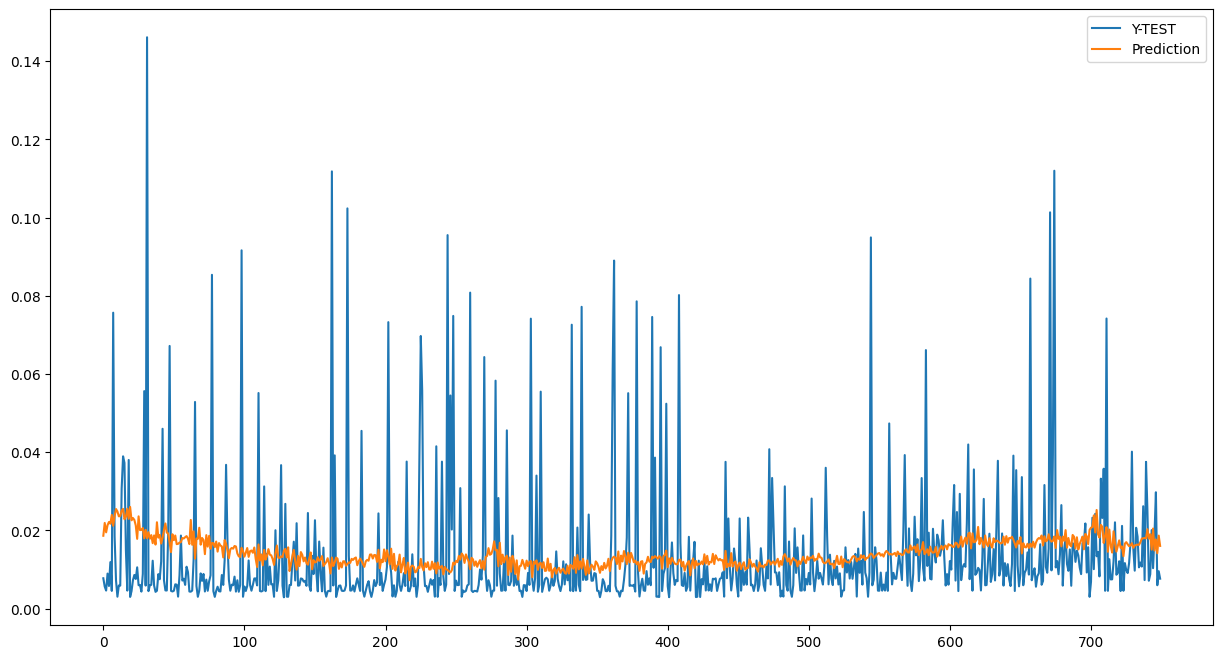

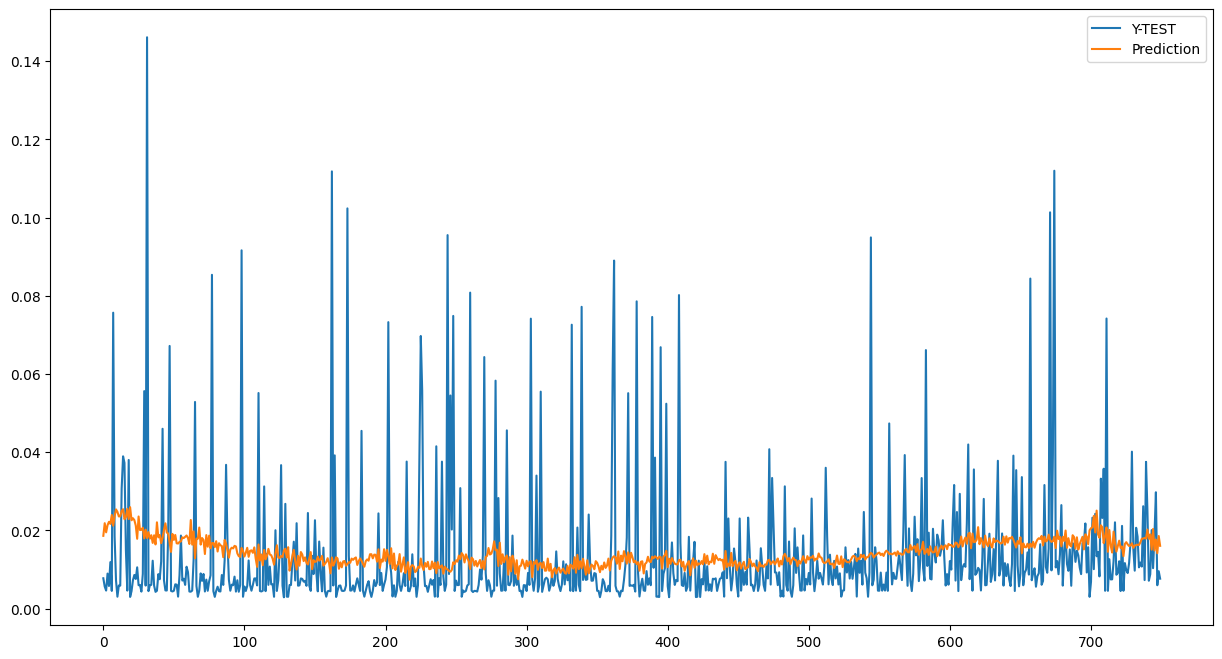

In [150]:
# Рисуем
for i in range(Ytest.shape[1]):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.savefig('foo10000.png')
  plt.show()

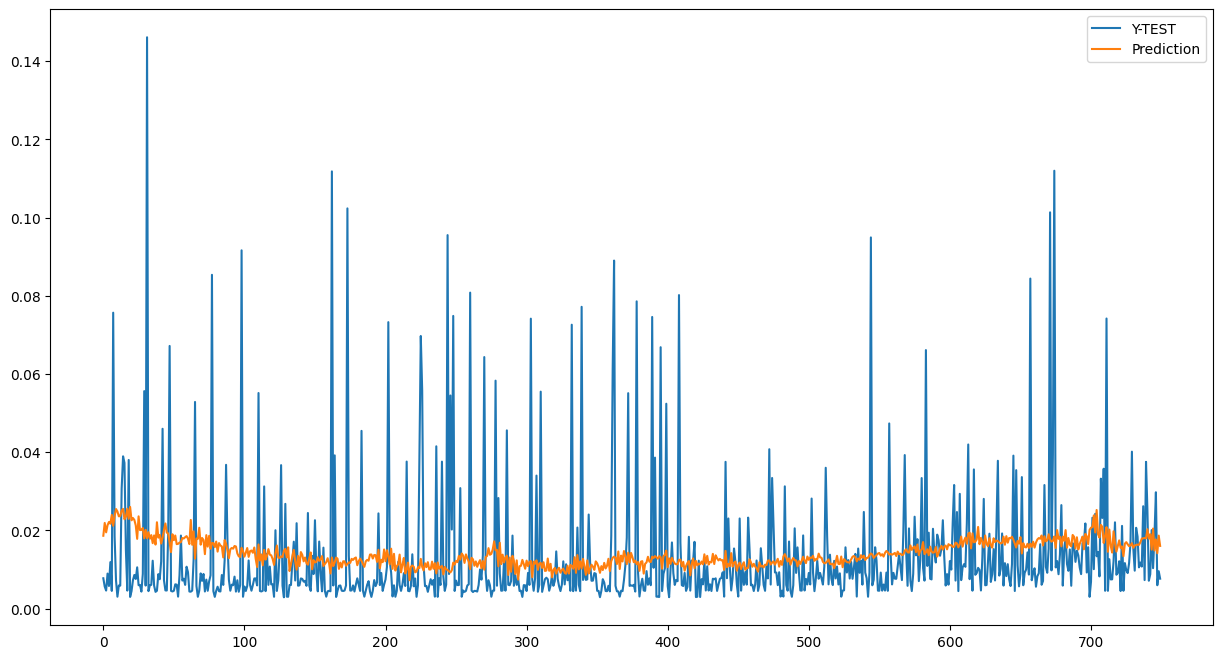

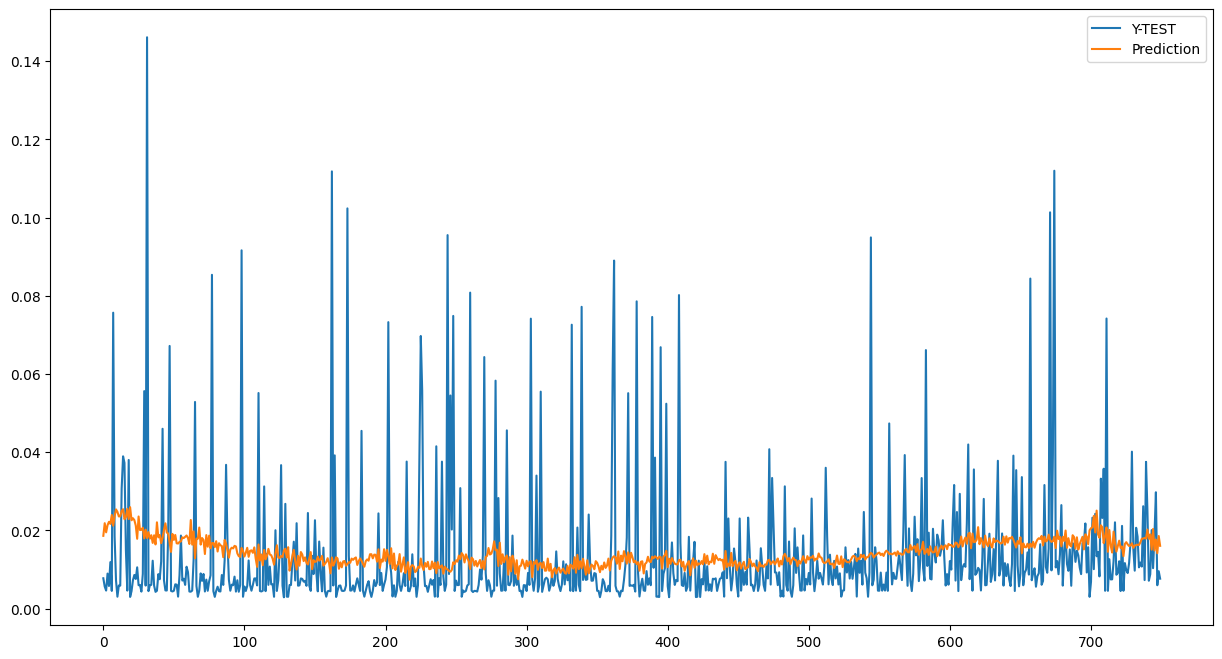

IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 1500x800 with 0 Axes>

In [151]:
for i in range(10):
  plt.figure(figsize=(15,8))
  plt.plot(Ytest[:ln,i], label = "Y-TEST")
  plt.plot(predict[:ln,i], label = "Prediction")
  plt.legend()
  plt.show()